# Recommendation System Deep Learning Research

* Reference Github:
    * https://github.com/wzhe06/SparrowRecSys/tree/master/TFRecModel/src/com/sparrowrecsys/offline/tensorflow
    * https://github.com/ZiyaoGeng/Recommender-System-with-TF2.0
    
    
* Content
    * Explore the data quality and preprocessing
    * Data Visualization
    * Model Establishment and Test
    * Real life recommendation movies that were not seen by user
    * Summary

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import pydot

# Import data set:
  * df_movie: contains the movie categories and types
  * df_user: contains user basic features
  * df_rating: contains the rate (1~5)that one user made to one moive

In [2]:
df_movie=pd.read_csv(r"E:\MBDS Materials\Trimester 1\BS6204-DEEP LEARNING FOR BIOMEDICAL SCIENCE\Project\ml-100k\movie.csv",encoding = 'gb18030')
df_user=pd.read_csv(r"E:\MBDS Materials\Trimester 1\BS6204-DEEP LEARNING FOR BIOMEDICAL SCIENCE\Project\ml-100k\user.csv")
df_rating=pd.read_csv(r"E:\MBDS Materials\Trimester 1\BS6204-DEEP LEARNING FOR BIOMEDICAL SCIENCE\Project\ml-100k\rating.csv")

In [3]:
print(df_movie.columns)

Index(['movie id ', ' movie title ', ' release date ', ' video release date ',
       ' IMDb URL ', ' unknown ', ' Action ', ' Adventure ', ' Animation ',
       'Children's ', ' Comedy ', ' Crime ', ' Documentary ', ' Drama ',
       ' Fantasy ', 'Film-Noir ', ' Horror ', ' Musical ', ' Mystery ',
       ' Romance ', ' Sci-Fi ', 'Thriller ', ' War ', ' Western '],
      dtype='object')


In [4]:
print(df_user.columns)

Index(['user id ', ' age ', ' gender ', ' occupation ', ' zip code'], dtype='object')


In [5]:
print(df_rating.columns)

Index(['user id ', ' item id ', ' rating ', ' timestamp'], dtype='object')


# Explore the data quality and preprocessing

The key point of recommendation deep learning model is to dig the user behaviours, product features based on the dataset.

In [6]:
#check the composition of files and their size
print(df_movie.shape)
print(df_user.shape)
print(df_rating.shape)


(1682, 24)
(943, 5)
(100000, 4)


* check whether there is null value


In [7]:
df_rating.isnull().sum() ##rating file doesnt have null value 

user id       0
 item id      0
 rating       0
 timestamp    0
dtype: int64

In [8]:
df_user.isnull().sum() ##user file doesnt have null value 

user id         0
 age            0
 gender         0
 occupation     0
 zip code       0
dtype: int64

In [9]:
df_movie.isnull().sum() ## movie file has null value in three columns

movie id                   0
 movie title               0
 release date              1
 video release date     1682
 IMDb URL                  3
 unknown                   0
 Action                    0
 Adventure                 0
 Animation                 0
Children's                 0
 Comedy                    0
 Crime                     0
 Documentary               0
 Drama                     0
 Fantasy                   0
Film-Noir                  0
 Horror                    0
 Musical                   0
 Mystery                   0
 Romance                   0
 Sci-Fi                    0
Thriller                   0
 War                       0
 Western                   0
dtype: int64

Text(0, 0.5, 'null count')

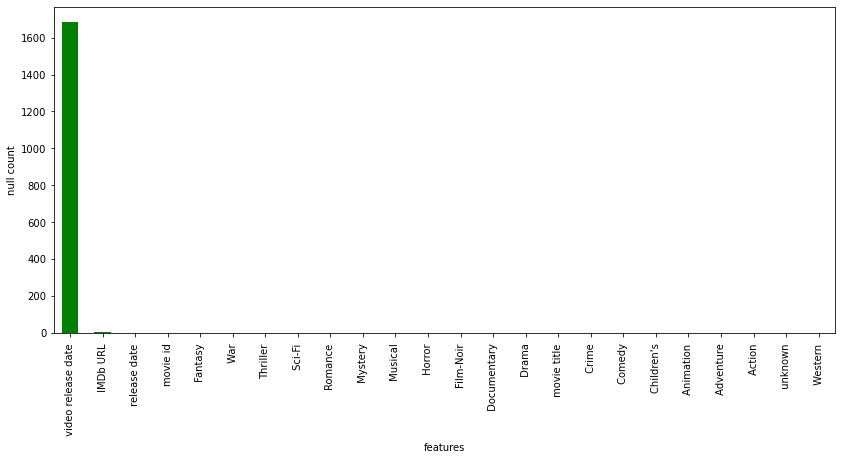

In [10]:
# null number visualization
null_value=(df_movie.isnull().sum()).sort_values(ascending=False)
null_value.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("features")
plt.ylabel("null count")

* It seems that "release date","video release date","IMDb URL" has null value. Considering the data we need, we could just drop the "IMDb URL", and the shape of movie dataset is 1682, which means "video release date" is all missed for every data, so this feature can also be eliminated. So we only need to fill the data in "release date"
* the columns contains a lot of space, we also need to eliminate them

In [11]:
def get_column_no_space(data):
    columns=[]
    for column in data.columns:
        columns.append(column.strip())
    return columns

In [12]:
#eliminate the space
df_movie.columns=get_column_no_space(df_movie)
df_user.columns=get_column_no_space(df_user)
df_rating.columns=get_column_no_space(df_rating)

In [13]:
df_rating

user id  item id  rating  timestamp
0          196      242       3  881250949
1          186      302       3  891717742
2           22      377       1  878887116
3          244       51       2  880606923
4          166      346       1  886397596
...        ...      ...     ...        ...
99995      880      476       3  880175444
99996      716      204       5  879795543
99997      276     1090       1  874795795
99998       13      225       2  882399156
99999       12      203       3  879959583

[100000 rows x 4 columns]

In [14]:
# drop the IMDb URL and video released date
movie=df_movie.drop(["IMDb URL","video release date"],axis=1)
movie

movie id                                movie title release date  \
0            1                           Toy Story (1995)     1-Jan-95   
1            2                           GoldenEye (1995)     1-Jan-95   
2            3                          Four Rooms (1995)     1-Jan-95   
3            4                          Get Shorty (1995)     1-Jan-95   
4            5                             Copycat (1995)     1-Jan-95   
...        ...                                        ...          ...   
1677      1678                          Mat' i syn (1997)     6-Feb-98   
1678      1679                           B. Monkey (1998)     6-Feb-98   
1679      1680                       Sliding Doors (1998)     1-Jan-98   
1680      1681                        You So Crazy (1994)     1-Jan-94   
1681      1682  Scream of Stone (Schrei aus Stein) (1991)     8-Mar-96   

      unknown  Action  Adventure  Animation  Children's  Comedy  Crime  ...  \
0           0       0          0          1           1       1      0  ...   
1           0       1          1          0           0       0      0  ...   
2           0       0          0          0           0       0      0  ...   
3           0       1          0          0           0       1      0  ...   
4           0       0          0          0           0       0      1  ...   
...       ...     ...        ...        ...         ...     ...    ...  ...   
1677        0       0          0          0           0       0      0  ...   
1678        0       0          0          0           0       0      0  ...   
1679        0       0          0          0           0       0      0  ...   
1680        0       0          0          0           0       1      0  ...   
1681        0       0          0          0           0       0      0  ...   

      Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  Thriller  \
0           0          0       0        0        0        0       0         0   
1           0          0       0        0        0        0       0         1   
2           0          0       0        0        0        0       0         1   
3           0          0       0        0        0        0       0         0   
4           0          0       0        0        0        0       0         1   
...       ...        ...     ...      ...      ...      ...     ...       ...   
1677        0          0       0        0        0        0       0         0   
1678        0          0       0        0        0        1       0         1   
1679        0          0       0        0        0        1       0         0   
1680        0          0       0        0        0        0       0         0   
1681        0          0       0        0        0        0       0         0   

      War  Western  
0       0        0  
1       0        0  
2       0        0  
3       0        0  
4       0        0  
...   ...      ...  
1677    0        0  
1678    0        0  
1679    0        0  
1680    0        0  
1681    0        0  

[1682 rows x 22 columns]

Then we need to find the NaN value in "release data"

In [15]:
# find the null value in "release date"
movie[movie["release date"].isnull()]

movie id movie title release date  unknown  Action  Adventure  Animation  \
266       267     unknown          NaN        1       0          0          0   

     Children's  Comedy  Crime  ...  Fantasy  Film-Noir  Horror  Musical  \
266           0       0      0  ...        0          0       0        0   

     Mystery  Romance  Sci-Fi  Thriller  War  Western  
266        0        0       0         0    0        0  

[1 rows x 22 columns]

In [16]:
df_rating[df_rating["item id"]==267] ## find the rating record of this movie

user id  item id  rating  timestamp
2172       130      267       5  875801239
3781         5      267       4  875635064
7245       268      267       3  875742077
12475      297      267       3  875409139
14756      319      267       4  875707690
15292        1      267       4  875692955
49295      532      267       3  875441348
93523      833      267       1  875655669
99723      422      267       4  875655986


The NO.267 Movie is a mystery with unknown movie title and missing release date, while some people seems really like it, so we will not delete it and could add a mean date to this table.To do this ,we need first check the dtype of all the features

* check the data type

In [17]:
movie.dtypes

movie id         int64
movie title     object
release date    object
unknown          int64
Action           int64
Adventure        int64
Animation        int64
Children's       int64
Comedy           int64
Crime            int64
Documentary      int64
Drama            int64
Fantasy          int64
Film-Noir        int64
Horror           int64
Musical          int64
Mystery          int64
Romance          int64
Sci-Fi           int64
Thriller         int64
War              int64
Western          int64
dtype: object

In [18]:
df_user.dtypes

user id        int64
age            int64
gender        object
occupation    object
zip code      object
dtype: object

In [19]:
df_rating.dtypes

user id      int64
item id      int64
rating       int64
timestamp    int64
dtype: object

* it seems the "release date" didn't have the proper type. What's more, we don't need the specific date and only year is enough. we change it to be an int64 with only years.

In [20]:
#split the "release date" to three columns 
movie[["day","month","year"]]=movie.drop(266,axis=0)["release date"].str.split("-",expand=True)

In [21]:
# and only year column is what we need
movie=movie.drop(["day","month","release date"],axis=1)

In [22]:
# fill the null value of no.267 movie with a mean year 
year=list(movie.drop(266,axis=0)["year"].astype("int64"))
year_266=round(np.mean(year))

year.insert(266,year_266)

#the year is only contians the last two digits, then we fix it into the standard way.
movie["year"]=year
movie["year"]=movie["year"]+1900

In [23]:
# show the year of these movie
np.sort(movie["year"].unique())

array([1922, 1926, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998], dtype=int64)

* we could see the moive is from 1992 to 1998, this data set is actually very old

## DIG the total movie(products) features from rating file
* add the number of users who rated this movie,show how popular this movie is.
* add the average rating of this movie, show how good this movie is.
* add the standard deviation of this movie, show how controversial this movie is.

In [24]:
#change the name of title
rating=df_rating
rating=rating.rename({"item id":"movie id"},axis=1)
rating

user id  movie id  rating  timestamp
0          196       242       3  881250949
1          186       302       3  891717742
2           22       377       1  878887116
3          244        51       2  880606923
4          166       346       1  886397596
...        ...       ...     ...        ...
99995      880       476       3  880175444
99996      716       204       5  879795543
99997      276      1090       1  874795795
99998       13       225       2  882399156
99999       12       203       3  879959583

[100000 rows x 4 columns]

In [25]:
#count number of users who rated this movie
count=rating.groupby("movie id").count().iloc[:,0]

#average rating of this movie,
mean_value=rating.groupby("movie id")["rating"].mean()

#standard deviation of this movie
std_value=rating.groupby("movie id")["rating"].std()

In [26]:
#add to the movie dataset
movie=pd.merge(movie,mean_value,on="movie id")
movie=pd.merge(movie,std_value,on="movie id")
movie=pd.merge(movie,count,on="movie id")

In [27]:
movie=movie.rename({"rating_x":"movieMeanRating","rating_y":"movieStd","user id":"ratingCount"},axis=1)

* notice when the situation that only one user rated a movie, the std whould be zero.So we need to fill the null to 0

In [28]:
movie["movieStd"]=movie["movieStd"].fillna(0)

In [29]:
movie.isnull().sum()

movie id           0
movie title        0
unknown            0
Action             0
Adventure          0
Animation          0
Children's         0
Comedy             0
Crime              0
Documentary        0
Drama              0
Fantasy            0
Film-Noir          0
Horror             0
Musical            0
Mystery            0
Romance            0
Sci-Fi             0
Thriller           0
War                0
Western            0
year               0
movieMeanRating    0
movieStd           0
ratingCount        0
dtype: int64

Now let's see what the movie with all the features looks like

In [30]:
movie

movie id                                movie title  unknown  Action  \
0            1                           Toy Story (1995)        0       0   
1            2                           GoldenEye (1995)        0       1   
2            3                          Four Rooms (1995)        0       0   
3            4                          Get Shorty (1995)        0       1   
4            5                             Copycat (1995)        0       0   
...        ...                                        ...      ...     ...   
1677      1678                          Mat' i syn (1997)        0       0   
1678      1679                           B. Monkey (1998)        0       0   
1679      1680                       Sliding Doors (1998)        0       0   
1680      1681                        You So Crazy (1994)        0       0   
1681      1682  Scream of Stone (Schrei aus Stein) (1991)        0       0   

      Adventure  Animation  Children's  Comedy  Crime  Documentary  ...  \
0             0          1           1       1      0            0  ...   
1             1          0           0       0      0            0  ...   
2             0          0           0       0      0            0  ...   
3             0          0           0       1      0            0  ...   
4             0          0           0       0      1            0  ...   
...         ...        ...         ...     ...    ...          ...  ...   
1677          0          0           0       0      0            0  ...   
1678          0          0           0       0      0            0  ...   
1679          0          0           0       0      0            0  ...   
1680          0          0           0       1      0            0  ...   
1681          0          0           0       0      0            0  ...   

      Mystery  Romance  Sci-Fi  Thriller  War  Western  year  movieMeanRating  \
0           0        0       0         0    0        0  1995         3.878319   
1           0        0       0         1    0        0  1995         3.206107   
2           0        0       0         1    0        0  1995         3.033333   
3           0        0       0         0    0        0  1995         3.550239   
4           0        0       0         1    0        0  1995         3.302326   
...       ...      ...     ...       ...  ...      ...   ...              ...   
1677        0        0       0         0    0        0  1998         1.000000   
1678        0        1       0         1    0        0  1998         3.000000   
1679        0        1       0         0    0        0  1998         2.000000   
1680        0        0       0         0    0        0  1994         3.000000   
1681        0        0       0         0    0        0  1996         3.000000   

      movieStd  ratingCount  
0     0.927897          452  
1     0.966497          131  
2     1.212760           90  
3     0.965069          209  
4     0.946446           86  
...        ...          ...  
1677  0.000000            1  
1678  0.000000            1  
1679  0.000000            1  
1680  0.000000            1  
1681  0.000000            1  

[1682 rows x 25 columns]

* we could see that the movie type is classified by the genres, but we want  to make these more dense, and the one hot progress will be done in tensorflow.feature_selection.
* in some recommendation model, it does not work if the one hot vector shows in the file above, it must become a one-hot vector groups.
  * for example:For NO.1 movie "Toy story":
    * [0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0] 
    * should be a group of belows:
    * [[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    * [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    * [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]]
* so in this case, we wiil flatten this into several columns named "movieGenre1" to "movieGenreN"

In [31]:
movie_types=["unknown","Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir",
             "Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]

In [32]:
# add the movie genres to new columns.
res_genres=[]
all_genres=movie.iloc[:,2:21] # movie genre
for i in range(movie.shape[0]):
    one_genres=[]
    for j in range(all_genres.shape[1]):
        if all_genres.iloc[i][j]==1:
            one_genres.append(movie_types[j])
    res_genres.append(one_genres)
movie["all_genres"]=res_genres

In [33]:
movie

movie id                                movie title  unknown  Action  \
0            1                           Toy Story (1995)        0       0   
1            2                           GoldenEye (1995)        0       1   
2            3                          Four Rooms (1995)        0       0   
3            4                          Get Shorty (1995)        0       1   
4            5                             Copycat (1995)        0       0   
...        ...                                        ...      ...     ...   
1677      1678                          Mat' i syn (1997)        0       0   
1678      1679                           B. Monkey (1998)        0       0   
1679      1680                       Sliding Doors (1998)        0       0   
1680      1681                        You So Crazy (1994)        0       0   
1681      1682  Scream of Stone (Schrei aus Stein) (1991)        0       0   

      Adventure  Animation  Children's  Comedy  Crime  Documentary  ...  \
0             0          1           1       1      0            0  ...   
1             1          0           0       0      0            0  ...   
2             0          0           0       0      0            0  ...   
3             0          0           0       1      0            0  ...   
4             0          0           0       0      1            0  ...   
...         ...        ...         ...     ...    ...          ...  ...   
1677          0          0           0       0      0            0  ...   
1678          0          0           0       0      0            0  ...   
1679          0          0           0       0      0            0  ...   
1680          0          0           0       1      0            0  ...   
1681          0          0           0       0      0            0  ...   

      Romance  Sci-Fi  Thriller  War  Western  year  movieMeanRating  \
0           0       0         0    0        0  1995         3.878319   
1           0       0         1    0        0  1995         3.206107   
2           0       0         1    0        0  1995         3.033333   
3           0       0         0    0        0  1995         3.550239   
4           0       0         1    0        0  1995         3.302326   
...       ...     ...       ...  ...      ...   ...              ...   
1677        0       0         0    0        0  1998         1.000000   
1678        1       0         1    0        0  1998         3.000000   
1679        1       0         0    0        0  1998         2.000000   
1680        0       0         0    0        0  1994         3.000000   
1681        0       0         0    0        0  1996         3.000000   

      movieStd  ratingCount                       all_genres  
0     0.927897          452  [Animation, Children's, Comedy]  
1     0.966497          131    [Action, Adventure, Thriller]  
2     1.212760           90                       [Thriller]  
3     0.965069          209          [Action, Comedy, Drama]  
4     0.946446           86         [Crime, Drama, Thriller]  
...        ...          ...                              ...  
1677  0.000000            1                          [Drama]  
1678  0.000000            1              [Romance, Thriller]  
1679  0.000000            1                 [Drama, Romance]  
1680  0.000000            1                         [Comedy]  
1681  0.000000            1                          [Drama]  

[1682 rows x 26 columns]

In [34]:
max_length_genres=0
for i in res_genres:
    #calculate the maximum length of the genre types of one specific movie
    max_length_genres=max(max_length_genres,len(i))

#then we add the corresponding genres to the movieGenre
#if one moive's genre is less than max length genres, then we will fill string 0 to the following genres.
for i in range(max_length_genres):
    genre=[]
    for genres in movie["all_genres"]:
        if i<len(genres):
            genre.append(genres[i])
        else:
            genre.append("0")
    movie["movieGenre"+str(i+1)]=genre

In [35]:
max_length_genres

6

In [36]:
# we now could drop the columns of movie_types and all_genres to finish our movie feature engineering
movie_finished=movie.drop(movie_types,axis=1)
movie_finished=movie_finished.drop("all_genres",axis=1)

* finished dig about the features of movies and output to the google drive for further use

In [37]:
#finished dig about the features of movies and output to the google drive for further use
movie_finished.to_csv(r"E:\MBDS Materials\Trimester 1\BS6204-DEEP LEARNING FOR BIOMEDICAL SCIENCE\Project\ml-100k\movie_features.csv",index=False)
movie_finished

movie id                                movie title  year  \
0            1                           Toy Story (1995)  1995   
1            2                           GoldenEye (1995)  1995   
2            3                          Four Rooms (1995)  1995   
3            4                          Get Shorty (1995)  1995   
4            5                             Copycat (1995)  1995   
...        ...                                        ...   ...   
1677      1678                          Mat' i syn (1997)  1998   
1678      1679                           B. Monkey (1998)  1998   
1679      1680                       Sliding Doors (1998)  1998   
1680      1681                        You So Crazy (1994)  1994   
1681      1682  Scream of Stone (Schrei aus Stein) (1991)  1996   

      movieMeanRating  movieStd  ratingCount movieGenre1 movieGenre2  \
0            3.878319  0.927897          452   Animation  Children's   
1            3.206107  0.966497          131      Action   Adventure   
2            3.033333  1.212760           90    Thriller           0   
3            3.550239  0.965069          209      Action      Comedy   
4            3.302326  0.946446           86       Crime       Drama   
...               ...       ...          ...         ...         ...   
1677         1.000000  0.000000            1       Drama           0   
1678         3.000000  0.000000            1     Romance    Thriller   
1679         2.000000  0.000000            1       Drama     Romance   
1680         3.000000  0.000000            1      Comedy           0   
1681         3.000000  0.000000            1       Drama           0   

     movieGenre3 movieGenre4 movieGenre5 movieGenre6  
0         Comedy           0           0           0  
1       Thriller           0           0           0  
2              0           0           0           0  
3          Drama           0           0           0  
4       Thriller           0           0           0  
...          ...         ...         ...         ...  
1677           0           0           0           0  
1678           0           0           0           0  
1679           0           0           0           0  
1680           0           0           0           0  
1681           0           0           0           0  

[1682 rows x 12 columns]

we could see that the max length of movie features are 6, and many movies do not have such long genres
* **From now, we finish the data cleaning and feature Engneering about the movie dataset.**
* Next, we will do the **user behaviour** digging

## DIG the total user features from rating and movie file
* add the number of movies that this user rates,show that how often and likely this user want to rate a movie.
* add the average rating of this user, show the baseline of this user rates.
* add the standard deviation of this user, show whether this user is critical or just be nice to every product.
* add the top 5 movie types this user probabily like.
* add the top 5 movie IDs that the user best like
* add the aevrage release year of good movies that user likes
* add the standard deviation of year of good movies that user likes

**it is differenct with movie**, user will rate the movie **in different time**. we need to calculate the mean and deviation of values **before** the time when user rates a new released movie. So we will allocate all the history values we need to list and then use the list to calculate statistical values like mean and diviation



In [38]:
df_rating["timestamp"]

0        881250949
1        891717742
2        878887116
3        880606923
4        886397596
           ...    
99995    880175444
99996    879795543
99997    874795795
99998    882399156
99999    879959583
Name: timestamp, Length: 100000, dtype: int64

we could see that the timestamp is not human readable, then we need to change it to the year-month-day type

In [39]:
import time
# define the function to change the time into standard type
def stamp_to_time(time_stamp):
    timeArray=time.localtime(time_stamp)
    return time.strftime("%Y-%m-%d %H:%M:%S",timeArray)

In [40]:
rating["time"]=rating["timestamp"].apply(stamp_to_time)

In [41]:
rating

user id  movie id  rating  timestamp                 time
0          196       242       3  881250949  1997-12-04 23:55:49
1          186       302       3  891717742  1998-04-05 03:22:22
2           22       377       1  878887116  1997-11-07 15:18:36
3          244        51       2  880606923  1997-11-27 13:02:03
4          166       346       1  886397596  1998-02-02 13:33:16
...        ...       ...     ...        ...                  ...
99995      880       476       3  880175444  1997-11-22 13:10:44
99996      716       204       5  879795543  1997-11-18 03:39:03
99997      276      1090       1  874795795  1997-09-21 06:49:55
99998       13       225       2  882399156  1997-12-18 06:52:36
99999       12       203       3  879959583  1997-11-20 01:13:03

[100000 rows x 5 columns]

Now we see the readable time when one user saw a movie and rated it, and next we could sort based on this "time" columns ,and allocate their history rating behaviours

In [42]:
import copy
import collections
# # this function is to allocate 
#       * the history rating of this user
#       * history movie id list that user already seen
#       * top5 movies user liked best
#               before the time he rates a new movie
def get_user_history(rating):
    rating=rating.sort_values(by="time")
    li=list(rating.groupby(by="user id"))
    #allocate all the history to "histories",the final shape of histories will be identical to rating,which is 10000 length
    #initialize the histories dataframe
    histories=pd.DataFrame(np.zeros((0,8)))
    columns=[]
    for column in rating.columns:
        columns.append(column)
    columns.append("history_rating")
    columns.append("user_think_good_movie_id")
    columns.append("top5_liked_movies")
    
    ## the framework of all the human behaviours
    histories.columns=columns
    
    #loop the list baesd on the user ID
    for user in li:
        
        # get this users all behavioures as df
        df=user[1]
        
        # histoty of rating,     type：list(list())
        res_rate=[]
        #history of movie id,    type:list(list())
        res_movie_id=[]
        #top 5 like movies
        res_top_5_like_movie=[]

        # history of current rating,   type:list()
        his_rate=[]
        
        # history of  movie ids when user think good (rating>3.5),   type:list()
        user_think_good_movie_id=[]
        #list of top 5 like movies
        movie_id_top5_like=collections.deque()

        user_rating=np.array(df["rating"])
        user_rating_movie=np.array(df["movie id"])
        time_list=list(df["time"])

        # treversal all the rating record of this user
        for i in range(df.shape[0]):
            if i==0:
                count=i
                interval=0
            else:
                #only the time is bigger than the previous record time, then the history will be add.
                if time_list[i]>time_list[i-1]:
                    for j in range(interval+1):
                        his_rate.append(user_rating[count+j])

                        #add to the list when the user think this movie is good(rating>3.5)
                        if user_rating[count+j]>3.5:
                            user_think_good_movie_id.append(user_rating_movie[count+j])

                            # update the top5 liked movie based on user rating, if all the ratings in this file are 5 and the
                            # size of this top 5 liked movie is already 5 ,then we wiil
                            # eliminate the oldest one and add the latest one into the tail of the deque
                            if len(movie_id_top5_like)==0:
                                movie_id_top5_like.append(user_rating_movie[count+j])
                            else:
                                right=movie_id_top5_like.pop()
                                if len(movie_id_top5_like)==4 and user_rating[list(user_rating_movie).index(right)]==5:
                                    # indicate the deque is full, only check whether we need to update the latest to list
                                    if user_rating[count+j]==5:#update
                                        movie_id_top5_like.popleft()
                                        movie_id_top5_like.append(right)
                                        movie_id_top5_like.append(user_rating_movie[count+j])
                                    else:# the latest movie is not good enough to join the top 5 liked movies
                                        # then we add the old one that we poped 
                                        movie_id_top5_like.append(right)
                                else:
                                    #in this condition,deque is not full with 5 length.
                                    movie_id_top5_like.append(right)
                                    # first check the head of the deque, if current movie rating is larger than the previous one,
                                    # add it to the head directly
                                    left=movie_id_top5_like.popleft()
                                    if user_rating[count+j]>user_rating[list(user_rating_movie).index(left)]:
                                        movie_id_top5_like.appendleft(left)
                                        movie_id_top5_like.appendleft(user_rating_movie[count+j])
                                    else:
                                        movie_id_top5_like.appendleft(left)

                                        q=collections.deque()
                                        # if the rating is not larger than the previous one,
                                        # then check whether the rating of this movie is larger than tail
                                        # if rating is larger than tail, keep pop things out to a new queue until the deque is empty 
                                        # or the rating is smaller than the tail, and add the current one to the tail,
                                        # add the movies in new queue back to tail. 
                                        while len(movie_id_top5_like)>0:
                                            right=movie_id_top5_like.pop()
                                            q.append(right)
                                            if user_rating[count+j]<=user_rating[list(user_rating_movie).index(right)]:
                                                break
                                        movie_id_top5_like.append(q.pop())
                                        movie_id_top5_like.append(user_rating_movie[count+j])
                                        while len(movie_id_top5_like)<5 and len(q)>0:
                                            movie_id_top5_like.append(q.pop())

                                #adjust the size of movie_id_top5_like to be 5.
                                while len(movie_id_top5_like)>5:
                                    movie_id_top5_like.pop()
                    count=i
                    interval=0
                else:
                    interval+=1
            #then we get the deep copy of the information we get above to the list that we will add to the DataFrame
            res_rate.append(copy.deepcopy(his_rate))
            res_movie_id.append(copy.deepcopy(user_think_good_movie_id))
            res_top_5_like_movie.append(copy.deepcopy(list(movie_id_top5_like)))
        ## add to the value to the specific user's columns
        df["history_rating"]=res_rate
        df["user_think_good_movie_id"]=res_movie_id
        df["top5_liked_movies"]=res_top_5_like_movie

        #update the histories
        histories=pd.concat([histories,df],axis=0)
    return histories

#### this "get_user_history" function above is to allocate 
  * the history rating of this user
  * history movie id list that user already saw and thought the movies were good(they rated >3.5 for this movie id)
  * top5 movies user liked best. if all the top 5 movies are all rated 5 by movie, and the newest movie id also was rated by 5, then the oldest movie will be deleted, the newest 5 rated movie will be added into this top 5 movie list(Like LRU)
* **before the time** when he rates this new movie

In [43]:
# we call the function above and get all the user behaviours
histories=get_user_history(rating)

In [44]:
#merge the rating with the histories
samples=pd.merge(rating,histories.drop(["rating","timestamp","time"],axis=1),on=["user id","movie id"])

In [45]:
samples.sort_values(by=["user id","time"])

user id  movie id  rating  timestamp                 time  \
59972        1       168       5  874965478  1997-09-23 05:57:58   
92487        1       172       5  874965478  1997-09-23 05:57:58   
74577        1       165       5  874965518  1997-09-23 05:58:38   
48214        1       156       4  874965556  1997-09-23 05:59:16   
15764        1       196       5  874965677  1997-09-23 06:01:17   
...        ...       ...     ...        ...                  ...   
93377      943       449       1  888693158  1998-03-01 03:12:38   
94914      943       229       2  888693158  1998-03-01 03:12:38   
95003      943       230       1  888693158  1998-03-01 03:12:38   
95291      943       228       3  888693158  1998-03-01 03:12:38   
92880      943       234       3  888693184  1998-03-01 03:13:04   

                                          history_rating  \
59972                                                 []   
92487                                                 []   
74577                                             [5, 5]   
48214                                          [5, 5, 5]   
15764                                       [5, 5, 5, 4]   
...                                                  ...   
93377  [5, 4, 4, 4, 5, 2, 5, 5, 4, 4, 2, 5, 4, 3, 3, ...   
94914  [5, 4, 4, 4, 5, 2, 5, 5, 4, 4, 2, 5, 4, 3, 3, ...   
95003  [5, 4, 4, 4, 5, 2, 5, 5, 4, 4, 2, 5, 4, 3, 3, ...   
95291  [5, 4, 4, 4, 5, 2, 5, 5, 4, 4, 2, 5, 4, 3, 3, ...   
92880  [5, 4, 4, 4, 5, 2, 5, 5, 4, 4, 2, 5, 4, 3, 3, ...   

                                user_think_good_movie_id  \
59972                                                 []   
92487                                                 []   
74577                                         [168, 172]   
48214                                    [168, 172, 165]   
15764                               [168, 172, 165, 156]   
...                                                  ...   
93377  [64, 181, 28, 174, 100, 127, 508, 763, 50, 475...   
94914  [64, 181, 28, 174, 100, 127, 508, 763, 50, 475...   
95003  [64, 181, 28, 174, 100, 127, 508, 763, 50, 475...   
95291  [64, 181, 28, 174, 100, 127, 508, 763, 50, 475...   
92880  [64, 181, 28, 174, 100, 127, 508, 763, 50, 475...   

            top5_liked_movies  
59972                      []  
92487                      []  
74577              [168, 172]  
48214         [168, 172, 165]  
15764    [168, 172, 165, 156]  
...                       ...  
93377  [92, 721, 239, 2, 672]  
94914  [92, 721, 239, 2, 672]  
95003  [92, 721, 239, 2, 672]  
95291  [92, 721, 239, 2, 672]  
92880  [92, 721, 239, 2, 672]  

[100000 rows x 8 columns]

from above we could see that based on the user id , and we add all the behaviours to the corresponding place, the first two rows contains null list in "history_rating","user_think_good_movie_id","top5_liked_movies", because they are the first two rating that user id 1 rated, so there is no any history for these rows for user id 1. 
#### Then we can dig our finall user behaviurs by calling the methods below 

In [46]:
## get the mean history rating value of 
def Mean(self):
    if len(self)==0:
        return 0
    else:
        return np.mean(self)

## get the standard deviation of history rating values
def Std(self):
    if len(self)==0:
        return 0
    else:
        return 0 if len(self)==1 else np.std(self,ddof=1)

## get top 5 movie genres of this user like based on "top5_liked_movies" on the DataFrame "samples"
def top5_movie_grenres(samples):
    def sort_by_value(d): 
        items=d.items() 
        backitems=[[v[1],v[0]] for v in items] 
        backitems.sort() 
        return [ backitems[i][1] for i in range(0,len(backitems)) if i<5]
    top5_movie_id_list=list(samples.top5_liked_movies)
    top5_movie_genres_like_list=[]
    for movie_list in top5_movie_id_list:
        top_5_movie_genres_like=[]
        if len(movie_list)==0:
            top_5_movie_genres_like.append("0")
        else:
            ## get the movie genres of this top 5 movie list
            ## dict key is movie genres, dict value is the count
            top_5_dict=dict()
            for movie_ in movie_list:
                movie_feature=movie[movie["movie id"]==movie_]
                for genre in movie_feature["all_genres"].iloc[0]:
                    if top_5_dict.__contains__(genre):
                        top_5_dict[genre]=top_5_dict[genre]+1
                    else:
                        top_5_dict[genre]=1

            #sort the dict based on the count value,and only get top 5 of the genres
            top_list=sort_by_value(top_5_dict)
            top_5_movie_genres_like=top_list
        top5_movie_genres_like_list.append(top_5_movie_genres_like)
    return top5_movie_genres_like_list

#get the mean and std value of years of movies that user thinks good
def mean_and_Std_ReleaseYear(samples):
    good_movie_id=list(samples.user_think_good_movie_id)
    aveYear=[]
    stdYear=[]

    for movie_id_list in good_movie_id:
        year=[]
        if len(movie_id_list)!=0:
            for movie_id in movie_id_list:
                year.append(movie[movie["movie id"]==movie_id]["year"].item())
        if len(year)==0:
            aveYear.append(0)
            stdYear.append(0)
        else:
            aveYear.append(round(np.mean(year)))
            stdYear.append(0 if len(year)==1 else np.std(year,ddof=1))
    return aveYear,stdYear

#get the top 5 movie the user likes and  and the movie id,and add concat them to the rate framework
def top_5_movie_IDs_or_Genres(samples,name):
    max_length_movies=0
    for i in samples[name]:
        max_length_movies=max(max_length_movies,len(i))

    for i in range(max_length_movies):
        movieId_or_genres=[]
        for movies in samples[name]:
            if i<len(movies):
                movieId_or_genres.append(movies[i])
            else:
                if name=="top5_liked_movies":
                    movieId_or_genres.append(0)
                else:
                    movieId_or_genres.append("0")
        string=""
        if name=="top5_liked_movies":
            string="userLikedTop5_movie_id_"
        else:
            string="userLiked_movie_genre_"
        samples[string+str(i+1)]=movieId_or_genres

* **After defined the functions above, then we call these functions and add the feature columns into the rating samples**

In [47]:
#the number of movies that this user rates
samples["userHistoryRatingCount"]=samples["history_rating"].apply(len)

# add the average history rating of this user
samples["userHistoryMeanRating"]=samples["history_rating"].apply(Mean)

# add the standard deviation history rating of this user
samples["userHistoryStdRating"]=samples["history_rating"].apply(Std)

# add the top 5 movie types this user probabily like.
samples["userHistoryTop5_liked_genres"]=top5_movie_grenres(samples)

# add the top 5 movie IDs that the user best like
top_5_movie_IDs_or_Genres(samples,"top5_liked_movies")


# add the top 5 movie genres that the user best like
top_5_movie_IDs_or_Genres(samples,"userHistoryTop5_liked_genres")



# add the aevrage release year of the movies user likes
# add the standard deviation of year of the best liked movie
aveYear,StrYear=mean_and_Std_ReleaseYear(samples)
samples["userRatingGoodMovieAveReleasedYear"]=aveYear
samples["userRatingGoodMovieStdReleasedYear"]=StrYear

*  After that, let's see a sample about one user of all the features,
* below is the user history behaviours we captured of user 943

In [48]:
samples[samples["user id"]==943].sort_values(by="time").head(50)

user id  movie id  rating  timestamp                 time  \
84323      943        64       5  875409939  1997-09-28 09:25:39   
93735      943        28       4  875409978  1997-09-28 09:26:18   
73174      943       181       4  875409978  1997-09-28 09:26:18   
80079      943       174       4  875410099  1997-09-28 09:28:19   
89206      943       100       5  875501725  1997-09-29 10:55:25   
68857      943      1067       2  875501756  1997-09-29 10:55:56   
73982      943       127       5  875501774  1997-09-29 10:56:14   
85483      943       508       5  875501795  1997-09-29 10:56:35   
97674      943       763       4  875501813  1997-09-29 10:56:53   
96160      943        50       4  875501835  1997-09-29 10:57:15   
73242      943       412       2  875501856  1997-09-29 10:57:36   
86629      943       475       5  875501889  1997-09-29 10:58:09   
78814      943       117       4  875501937  1997-09-29 10:58:57   
98335      943         9       3  875501960  1997-09-29 10:59:20   
77609      943       124       3  875501995  1997-09-29 10:59:55   
70821      943       685       4  875502042  1997-09-29 11:00:42   
76577      943       405       4  875502042  1997-09-29 11:00:42   
71726      943       471       5  875502042  1997-09-29 11:00:42   
98549      943       274       3  875502074  1997-09-29 11:01:14   
93148      943        24       4  875502074  1997-09-29 11:01:14   
80701      943       928       5  875502074  1997-09-29 11:01:14   
82954      943      1028       2  875502096  1997-09-29 11:01:36   
81889      943       121       3  875502096  1997-09-29 11:01:36   
97499      943       717       4  875502116  1997-09-29 11:01:56   
83451      943       756       2  875502146  1997-09-29 11:02:26   
99133      943      1047       2  875502146  1997-09-29 11:02:26   
67571      943       111       4  875502192  1997-09-29 11:03:12   
84518      943       284       2  875502192  1997-09-29 11:03:12   
92224      943       546       4  875502229  1997-09-29 11:03:49   
88367      943       282       5  875502230  1997-09-29 11:03:50   
99014      943       825       3  875502283  1997-09-29 11:04:43   
94083      943       831       2  875502283  1997-09-29 11:04:43   
78140      943       281       4  875502299  1997-09-29 11:04:59   
89050      943       824       4  875502483  1997-09-29 11:08:03   
72652      943      1011       2  875502560  1997-09-29 11:09:20   
83265      943       122       1  875502576  1997-09-29 11:09:36   
72218      943       595       2  875502597  1997-09-29 11:09:57   
89834      943       406       3  875502597  1997-09-29 11:09:57   
80689      943        23       4  888638897  1998-02-28 12:08:17   
97845      943       168       2  888638897  1998-02-28 12:08:17   
94410      943       419       2  888638920  1998-02-28 12:08:40   
73600      943        96       4  888638920  1998-02-28 12:08:40   
87254      943       172       4  888638940  1998-02-28 12:09:00   
94199      943       173       5  888638960  1998-02-28 12:09:20   
81296      943        98       5  888638980  1998-02-28 12:09:40   
70296      943       215       5  888639000  1998-02-28 12:10:00   
67673      943        11       4  888639000  1998-02-28 12:10:00   
85387      943        79       5  888639019  1998-02-28 12:10:19   
93678      943        22       4  888639042  1998-02-28 12:10:42   
98707      943       568       3  888639042  1998-02-28 12:10:42   

                                          history_rating  \
84323                                                 []   
93735                                                [5]   
73174                                                [5]   
80079                                          [5, 4, 4]   
89206                                       [5, 4, 4, 4]   
68857                                    [5, 4, 4, 4, 5]   
73982                                 [5, 4, 4, 4, 5, 2]   
85483                              [5, 4, 4, 4, 5, 2, 5]  

* From now on, we finally **dig and collect all the user behaviours** from user rating files.Now, it is time to combine all together and make our final dataset.

* In case of time limitation, we will output the files to the Google drive for convienence

In [49]:
samples.to_csv(r"E:\MBDS Materials\Trimester 1\BS6204-DEEP LEARNING FOR BIOMEDICAL SCIENCE\Project\train_local\human_behaviours_2.csv",index=False)

In [50]:
human_behaviours=pd.read_csv(r"E:\MBDS Materials\Trimester 1\BS6204-DEEP LEARNING FOR BIOMEDICAL SCIENCE\Project\ml-100k\human_behaviours_2.csv")

In [51]:
human_behaviours.columns

Index(['user id', 'movie id', 'rating', 'timestamp', 'time', 'history_rating',
       'user_think_good_movie_id', 'top5_liked_movies',
       'userHistoryRatingCount', 'userHistoryMeanRating',
       'userHistoryStdRating', 'userHistoryTop5_liked_genres',
       'userLikedTop5_movie_id_1', 'userLikedTop5_movie_id_2',
       'userLikedTop5_movie_id_3', 'userLikedTop5_movie_id_4',
       'userLikedTop5_movie_id_5', 'userLiked_movie_genre_1',
       'userLiked_movie_genre_2', 'userLiked_movie_genre_3',
       'userLiked_movie_genre_4', 'userLiked_movie_genre_5',
       'userRatingGoodMovieAveReleasedYear',
       'userRatingGoodMovieStdReleasedYear'],
      dtype='object')

In [52]:
human_behaviours.shape

(100000, 24)

In [53]:
movie_finished

movie id                                movie title  year  \
0            1                           Toy Story (1995)  1995   
1            2                           GoldenEye (1995)  1995   
2            3                          Four Rooms (1995)  1995   
3            4                          Get Shorty (1995)  1995   
4            5                             Copycat (1995)  1995   
...        ...                                        ...   ...   
1677      1678                          Mat' i syn (1997)  1998   
1678      1679                           B. Monkey (1998)  1998   
1679      1680                       Sliding Doors (1998)  1998   
1680      1681                        You So Crazy (1994)  1994   
1681      1682  Scream of Stone (Schrei aus Stein) (1991)  1996   

      movieMeanRating  movieStd  ratingCount movieGenre1 movieGenre2  \
0            3.878319  0.927897          452   Animation  Children's   
1            3.206107  0.966497          131      Action   Adventure   
2            3.033333  1.212760           90    Thriller           0   
3            3.550239  0.965069          209      Action      Comedy   
4            3.302326  0.946446           86       Crime       Drama   
...               ...       ...          ...         ...         ...   
1677         1.000000  0.000000            1       Drama           0   
1678         3.000000  0.000000            1     Romance    Thriller   
1679         2.000000  0.000000            1       Drama     Romance   
1680         3.000000  0.000000            1      Comedy           0   
1681         3.000000  0.000000            1       Drama           0   

     movieGenre3 movieGenre4 movieGenre5 movieGenre6  
0         Comedy           0           0           0  
1       Thriller           0           0           0  
2              0           0           0           0  
3          Drama           0           0           0  
4       Thriller           0           0           0  
...          ...         ...         ...         ...  
1677           0           0           0           0  
1678           0           0           0           0  
1679           0           0           0           0  
1680           0           0           0           0  
1681           0           0           0           0  

[1682 rows x 12 columns]

### combine user features, movie features and user behaviours(rating files) together
* Combine human behaviours, movie_finished and user together to become the final dataset

In [54]:
## combine the samples 
final_samples=pd.merge(human_behaviours,movie_finished,how='inner',on='movie id')
final_samples=pd.merge(final_samples,df_user,how='left',on='user id')
final_samples

user id  movie id  rating  timestamp                 time  \
0          196       242       3  881250949  1997-12-04 23:55:49   
1           63       242       3  875747190  1997-10-02 07:06:30   
2          226       242       5  883888671  1998-01-04 12:37:51   
3          154       242       3  879138235  1997-11-10 13:03:55   
4          306       242       5  876503793  1997-10-11 01:16:33   
...        ...       ...     ...        ...                  ...   
99995      840      1674       4  891211682  1998-03-30 06:48:02   
99996      655      1640       3  888474646  1998-02-26 14:30:46   
99997      655      1637       3  888984255  1998-03-04 12:04:15   
99998      655      1630       3  887428735  1998-02-14 11:58:55   
99999      655      1641       3  887427810  1998-02-14 11:43:30   

                                          history_rating  \
0                                                     []   
1      [3, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 2, 2, 2, 1, ...   
2                                                 [4, 4]   
3                                                     []   
4                                                 [5, 5]   
...                                                  ...   
99995  [4, 4, 5, 5, 5, 4, 5, 5, 4, 5, 5, 4, 4, 5, 4, ...   
99996  [4, 4, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, ...   
99997  [4, 4, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, ...   
99998  [4, 4, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, ...   
99999  [4, 4, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, ...   

                                user_think_good_movie_id  \
0                                                     []   
1                              [286, 262, 333, 301, 748]   
2                                             [286, 270]   
3                                                     []   
4                                             [306, 269]   
...                                                  ...   
99995  [272, 750, 303, 884, 100, 285, 14, 515, 221, 1...   
99996  [302, 315, 242, 50, 515, 298, 1380, 6, 275, 14...   
99997  [302, 315, 242, 50, 515, 298, 1380, 6, 275, 14...   
99998  [302, 315, 242, 50, 515, 298, 1380, 6, 275, 14...   
99999  [302, 315, 242, 50, 515, 298, 1380, 6, 275, 14...   

                top5_liked_movies  userHistoryRatingCount  \
0                              []                       0   
1       [301, 286, 262, 333, 748]                      21   
2                      [286, 270]                       2   
3                              []                       0   
4                      [306, 269]                       2   
...                           ...                     ...   
99995   [616, 653, 423, 443, 190]                     194   
99996  [504, 127, 1368, 187, 320]                     491   
99997   [1368, 187, 320, 30, 262]                     578   
99998    [302, 315, 242, 50, 515]                     154   
99999    [302, 315, 242, 50, 515]                     126   

       userHistoryMeanRating  ...  movieGenre1 movieGenre2  movieGenre3  \
0                   0.000000  ...       Comedy           0            0   
1                   2.904762  ...       Comedy           0            0   
2                   4.000000  ...       Comedy           0            0   
3                   0.000000  ...       Comedy           0            0   
4                   5.000000  ...       Comedy           0            0   
...                      ...  ...          ...         ...          ...   
99995               4.159794  ...        Drama           0            0   
99996               2.910387  ...        Drama           0            0   
99997               2.920415  ...        Drama           0            0   
99998               2.915584  ...        Drama           0            0   
99999               3.000000  ...  Documentary           0            0   

       movieGenre4  movieGenre5  movieGenre6  age gender  occupation zip code  
0                0            0   

We got a final samples with 39 columns( rating is label and other could be features).Then we check the NaN value again 

In [55]:
final_samples.isnull().sum()

user id                               0
movie id                              0
rating                                0
timestamp                             0
time                                  0
history_rating                        0
user_think_good_movie_id              0
top5_liked_movies                     0
userHistoryRatingCount                0
userHistoryMeanRating                 0
userHistoryStdRating                  0
userHistoryTop5_liked_genres          0
userLikedTop5_movie_id_1              0
userLikedTop5_movie_id_2              0
userLikedTop5_movie_id_3              0
userLikedTop5_movie_id_4              0
userLikedTop5_movie_id_5              0
userLiked_movie_genre_1               0
userLiked_movie_genre_2               0
userLiked_movie_genre_3               0
userLiked_movie_genre_4               0
userLiked_movie_genre_5               0
userRatingGoodMovieAveReleasedYear    0
userRatingGoodMovieStdReleasedYear    0
movie title                           0


## Eliminate columns we don't need in final dataset 
* Eliminate the columns duplicated like the columns of "top5_liked_movie", because we already faltten it to several columns from "userLikedTop5_movie_id_1" to "userLikedTop5_movie_id_5"

* Eliminate the columns we won't use like the names of movies

* Eliminate the first time that user start to rate, because we don't have their history data since they are rating movie from the beginning
  (or fill them with the average values of their behaiviours, that's all ok. herein we just delete them)

In [56]:
final_samples=final_samples.drop(["time","history_rating","user_think_good_movie_id","top5_liked_movies","userHistoryTop5_liked_genres",
                    "movie title"],axis=1)
final_samples=final_samples[final_samples["userHistoryRatingCount"]!=0]
final_samples.reset_index(drop=True,inplace=True)

In [57]:
final_samples

user id  movie id  rating  timestamp  userHistoryRatingCount  \
0           63       242       3  875747190                      21   
1          226       242       5  883888671                       2   
2          306       242       5  876503793                       2   
3          271       242       4  885844495                       5   
4          209       242       4  883589606                      28   
...        ...       ...     ...        ...                     ...   
97860      840      1674       4  891211682                     194   
97861      655      1640       3  888474646                     491   
97862      655      1637       3  888984255                     578   
97863      655      1630       3  887428735                     154   
97864      655      1641       3  887427810                     126   

       userHistoryMeanRating  userHistoryStdRating  userLikedTop5_movie_id_1  \
0                   2.904762              0.943650                       301   
1                   4.000000              0.000000                       286   
2                   5.000000              0.000000                       306   
3                   4.000000              0.707107                       302   
4                   3.357143              1.193013                       127   
...                      ...                   ...                       ...   
97860               4.159794              0.788671                       616   
97861               2.910387              0.756006                       504   
97862               2.920415              0.749742                      1368   
97863               2.915584              0.615182                       302   
97864               3.000000              0.565685                       302   

       userLikedTop5_movie_id_2  userLikedTop5_movie_id_3  ...  movieGenre1  \
0                           286                       262  ...       Comedy   
1                           270                         0  ...       Comedy   
2                           269                         0  ...       Comedy   
3                           690                       269  ...       Comedy   
4                           285                       813  ...       Comedy   
...                         ...                       ...  ...          ...   
97860                       653                       423  ...        Drama   
97861                       127                      1368  ...        Drama   
97862                       187                       320  ...        Drama   
97863                       315                       242  ...        Drama   
97864                       315                       242  ...  Documentary   

       movieGenre2 movieGenre3 movieGenre4 movieGenre5 movieGenre6 age  \
0                0           0           0           0           0  31   
1                0           0           0           0           0  28   
2                0           0           0           0           0  45   
3                0           0           0           0           0  51   
4                0           0           0           0           0  33   
...            ...         ...         ...         ...         ...  ..   
97860            0           0           0           0           0  39   
97861            0           0           0           0           0  50   
97862            0           0           0           0           0  50   
97863            0           0           0           0           0  50   
97864            0           0           0           0           0  50   

       gender  occupation  zip code  
0           M   marketing     75240  
1           M     student     92103  
2           M       other     73132  
3           M    engineer     22932  
4           F    educator     85710  
...       ...         ...       ...  
97860       M      artist     55406  
97861       F  healthcare     60657  
97862       F

In [58]:
final_samples.columns

Index(['user id', 'movie id', 'rating', 'timestamp', 'userHistoryRatingCount',
       'userHistoryMeanRating', 'userHistoryStdRating',
       'userLikedTop5_movie_id_1', 'userLikedTop5_movie_id_2',
       'userLikedTop5_movie_id_3', 'userLikedTop5_movie_id_4',
       'userLikedTop5_movie_id_5', 'userLiked_movie_genre_1',
       'userLiked_movie_genre_2', 'userLiked_movie_genre_3',
       'userLiked_movie_genre_4', 'userLiked_movie_genre_5',
       'userRatingGoodMovieAveReleasedYear',
       'userRatingGoodMovieStdReleasedYear', 'year', 'movieMeanRating',
       'movieStd', 'ratingCount', 'movieGenre1', 'movieGenre2', 'movieGenre3',
       'movieGenre4', 'movieGenre5', 'movieGenre6', 'age', 'gender',
       'occupation', 'zip code'],
      dtype='object')

### Add the binary label to final set and output to Google drive
* if the rate is larger than 3.5, then we consider this user liked this movie， if don't, then user don't like this movie

In [59]:
label=[]
for rate in final_samples["rating"]:
    if rate>3.5:
        label.append(1.0)
    else:
        label.append(0.0)
final_samples["label"]=label
#rename the columns since space can not be used in followsing deep learning models
final_samples=final_samples.rename({"user id":"user_id","movie id":"movie_id","zip code":"zip_code"},axis=1)

#output our final_samples
final_samples.to_csv(r"E:\MBDS Materials\Trimester 1\BS6204-DEEP LEARNING FOR BIOMEDICAL SCIENCE\Project\train_local\final_samples.csv",index=False)

# Data Visualization
Since we already dig all the feature in the rating, movie, user features, then it is time to explore what the data looks like

In [60]:
final_samples=pd.read_csv(r"E:\MBDS Materials\Trimester 1\BS6204-DEEP LEARNING FOR BIOMEDICAL SCIENCE\Project\train_local\final_samples.csv")
movie_features=pd.read_csv(r"E:\MBDS Materials\Trimester 1\BS6204-DEEP LEARNING FOR BIOMEDICAL SCIENCE\Project\train_local\movie_features.csv")
movie_features

C:\Users\Warden\Anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


movie id                                movie title  year  \
0            1                           Toy Story (1995)  1995   
1            2                           GoldenEye (1995)  1995   
2            3                          Four Rooms (1995)  1995   
3            4                          Get Shorty (1995)  1995   
4            5                             Copycat (1995)  1995   
...        ...                                        ...   ...   
1677      1678                          Mat' i syn (1997)  1998   
1678      1679                           B. Monkey (1998)  1998   
1679      1680                       Sliding Doors (1998)  1998   
1680      1681                        You So Crazy (1994)  1994   
1681      1682  Scream of Stone (Schrei aus Stein) (1991)  1996   

      movieMeanRating  movieStd  ratingCount movieGenre1 movieGenre2  \
0            3.878319  0.927897          452   Animation  Children's   
1            3.206107  0.966497          131      Action   Adventure   
2            3.033333  1.212760           90    Thriller           0   
3            3.550239  0.965069          209      Action      Comedy   
4            3.302326  0.946446           86       Crime       Drama   
...               ...       ...          ...         ...         ...   
1677         1.000000  0.000000            1       Drama           0   
1678         3.000000  0.000000            1     Romance    Thriller   
1679         2.000000  0.000000            1       Drama     Romance   
1680         3.000000  0.000000            1      Comedy           0   
1681         3.000000  0.000000            1       Drama           0   

     movieGenre3 movieGenre4 movieGenre5 movieGenre6  
0         Comedy           0           0           0  
1       Thriller           0           0           0  
2              0           0           0           0  
3          Drama           0           0           0  
4       Thriller           0           0           0  
...          ...         ...         ...         ...  
1677           0           0           0           0  
1678           0           0           0           0  
1679           0           0           0           0  
1680           0           0           0           0  
1681           0           0           0           0  

[1682 rows x 12 columns]

### popular movie and not popular movies
* first let's the most popular top 10 movies

Text(0, 0.5, 'rating count')

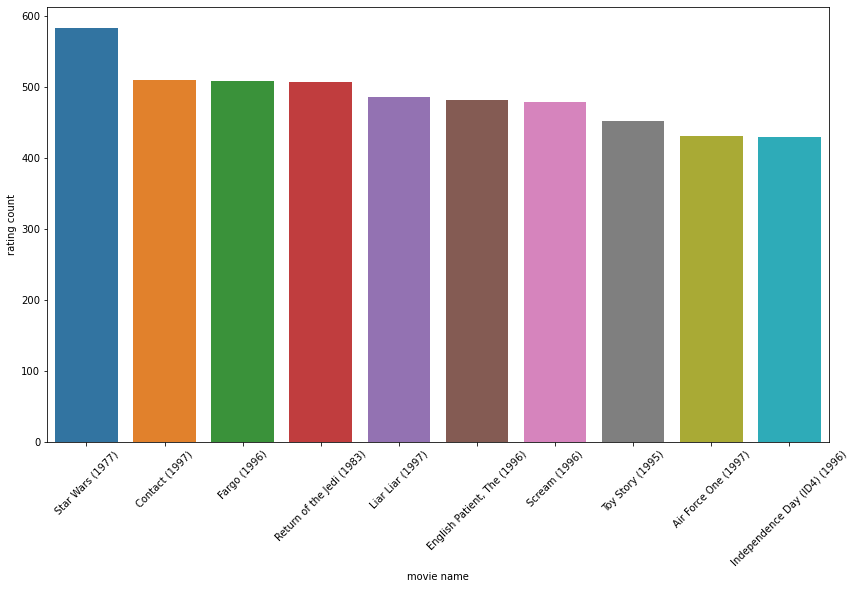

In [61]:
# first let's the most popular top 10 movies
plt.figure(figsize=(14,8))
sns.barplot(x=movie_features.sort_values(by='ratingCount',ascending=False).head(10)["movie title"],
            y=movie_features.sort_values(by='ratingCount',ascending=False).head(10)["ratingCount"])
plt.xlabel("movie name")
plt.xticks(rotation=45)
plt.ylabel("rating count")

 We could see that star wars is the most popular movie between this period, and Contact is the second. We could also see "Return to the Jedi", which is the another movie of star war. It is obviouly that fiction and action movie is the most poplular one and people who saw these movies were all so excited and wanted to rate.
 

* then let's the least popular top 10 movies

Text(0, 0.5, 'rating count')

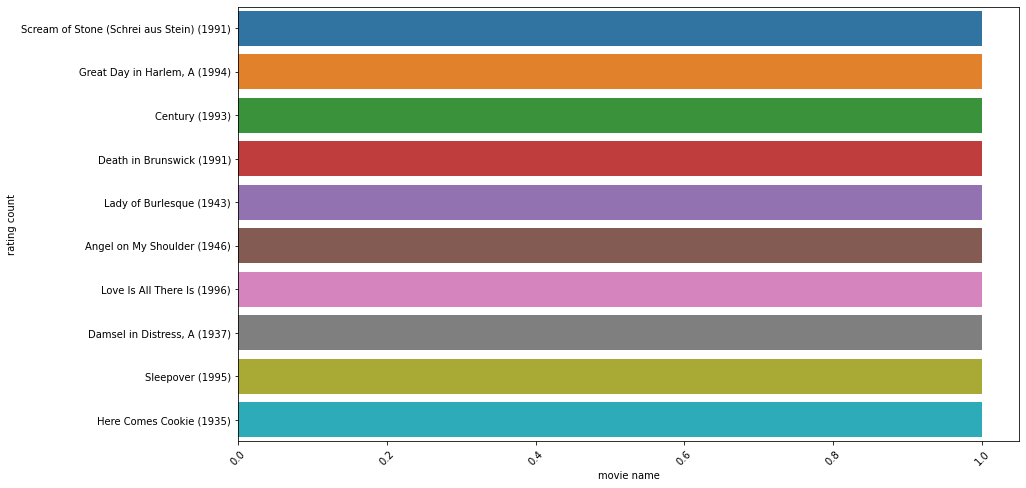

In [62]:
# then let's the least popular top 10 movies
plt.figure(figsize=(14,8))
sns.barplot(x=movie_features.sort_values(by='ratingCount').head(10)["ratingCount"],
            y=movie_features.sort_values(by='ratingCount').head(10)["movie title"],orient='h')
plt.xlabel("movie name")
plt.xticks(rotation=45)
plt.ylabel("rating count")

These top 10 movies are all got one rated by one user, it seems these movies are not such popular like the above graph.

### movie released year

C:\Users\Warden\Anaconda3\envs\DeepLearning\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'proportion of movie release year')

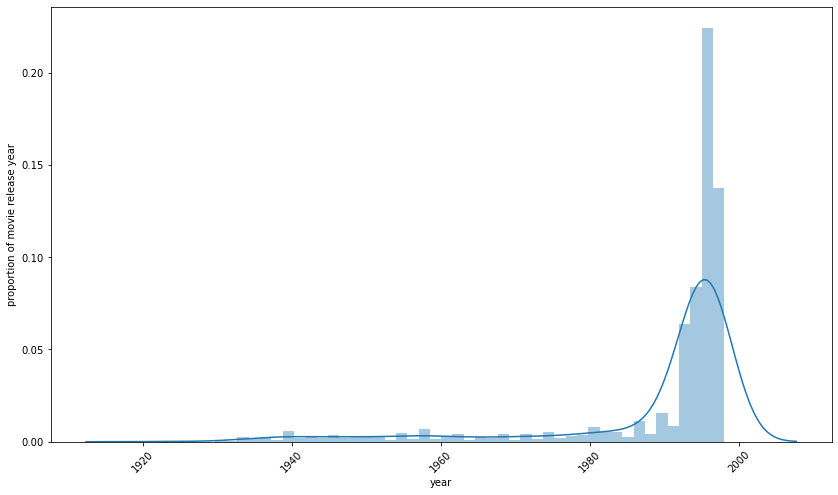

In [63]:
plt.figure(figsize=(14,8))
sns.distplot(movie_features['year'])
plt.xticks(rotation=45)
plt.ylabel("proportion of movie release year")

It seems that before 1991, the number of movie is not large, and after 1991, so many movie are released and people can enjoy a lot. It is because many movie need a special effection which need advanced techonology, and at the beginning from 1920 to 1980, movies are hard to shot
### movie genres

C:\Users\Warden\Anaconda3\envs\DeepLearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count Number')

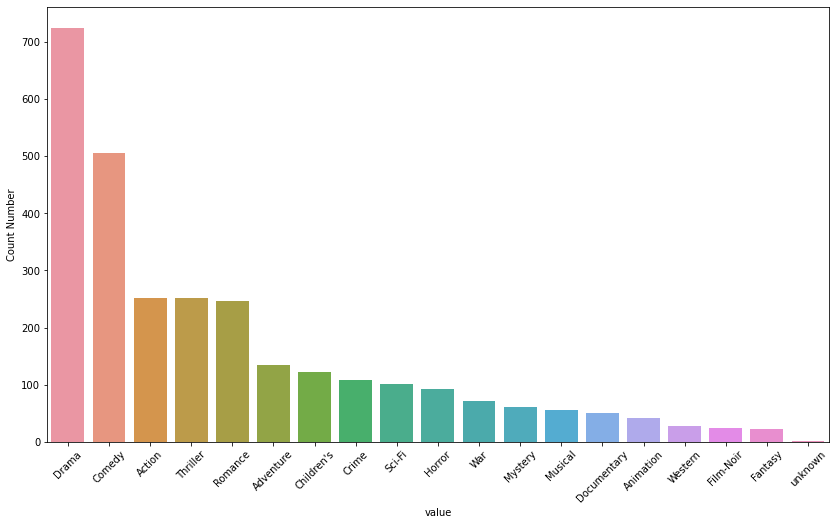

In [64]:
# then lets see the popular movie genres that direcor likes
plt.figure(figsize=(14,8))
# we melt movieGenre1 to movieGenre6 as two clumns, one is the genre strin ,one is the column name
movie_types_count=pd.melt(movie_features,id_vars=["movie id","movie title","year","movieMeanRating","movieStd","ratingCount"])

# then we eliminate the string 0 ,because it is useless
movie_types_count=movie_types_count[movie_types_count["value"]!='0']

# finally we calculate the number of movie genres of all the movies to find which gnere is the most popular one that directors like to shot
sns.countplot(movie_types_count["value"],order=movie_types_count["value"].value_counts().index)
plt.xticks(rotation=45)
plt.ylabel("Movie type")
plt.ylabel("Count Number")

* from the countplot above, we could see that "drama" is the movie type that most direcors like to shot, then is "comedy" which suprised us.Action is the third one. We could see that fiction（Sci-Fi） movie is far away, even not in top5. One of this reason is maybe technological limitaion. That's also why star war is such popular.
* in the old time, directors are really like to shoot drama comedy,may be that is the most easy movie to shoot and the people really want to see this movie type

**lets' now pay more attention on the user behaviours**

In [65]:
final_samples

user_id  movie_id  rating  timestamp  userHistoryRatingCount  \
0           63       242       3  875747190                      21   
1          226       242       5  883888671                       2   
2          306       242       5  876503793                       2   
3          271       242       4  885844495                       5   
4          209       242       4  883589606                      28   
...        ...       ...     ...        ...                     ...   
97860      840      1674       4  891211682                     194   
97861      655      1640       3  888474646                     491   
97862      655      1637       3  888984255                     578   
97863      655      1630       3  887428735                     154   
97864      655      1641       3  887427810                     126   

       userHistoryMeanRating  userHistoryStdRating  userLikedTop5_movie_id_1  \
0                   2.904762              0.943650                       301   
1                   4.000000              0.000000                       286   
2                   5.000000              0.000000                       306   
3                   4.000000              0.707107                       302   
4                   3.357143              1.193013                       127   
...                      ...                   ...                       ...   
97860               4.159794              0.788671                       616   
97861               2.910387              0.756006                       504   
97862               2.920415              0.749742                      1368   
97863               2.915584              0.615182                       302   
97864               3.000000              0.565685                       302   

       userLikedTop5_movie_id_2  userLikedTop5_movie_id_3  ...  movieGenre2  \
0                           286                       262  ...            0   
1                           270                         0  ...            0   
2                           269                         0  ...            0   
3                           690                       269  ...            0   
4                           285                       813  ...            0   
...                         ...                       ...  ...          ...   
97860                       653                       423  ...            0   
97861                       127                      1368  ...            0   
97862                       187                       320  ...            0   
97863                       315                       242  ...            0   
97864                       315                       242  ...            0   

       movieGenre3 movieGenre4 movieGenre5 movieGenre6 age gender  occupation  \
0                0           0           0           0  31      M   marketing   
1                0           0           0           0  28      M     student   
2                0           0           0           0  45      M       other   
3                0           0           0           0  51      M    engineer   
4                0           0           0           0  33      F    educator   
...            ...         ...         ...         ...  ..    ...         ...   
97860            0           0           0           0  39      M      artist   
97861            0           0           0           0  50      F  healthcare   
97862            0           0           0           0  50      F  healthcare   
97863            0           0           0           0  50      F  healthcare   
97864            0           0           0           0  50      F  healthcare   

       zip_code  label  
0         75240    0.0  
1         92103    1.0  
2         73132    1.0  
3         22932    1.0  
4         85710    1.0  
...         ...    ...  
97860     55406    1.0  
97861     60657    0.0  
97862     60657    0.0  
97863     60657    0.

C:\Users\Warden\Anaconda3\envs\DeepLearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

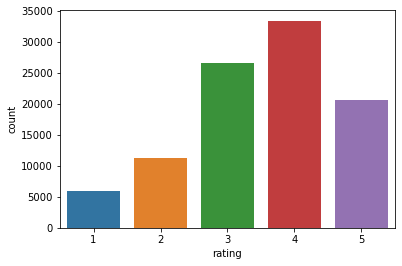

In [66]:
sns.countplot(final_samples["rating"])

The countplot of rating shows in this data set, most peole will rate 4, and least people will rate 1, it is a left skewed distribution but very similar to normal ditribution.
Then we find which user likes to rate movies,and check his or her characteristics

C:\Users\Warden\Anaconda3\envs\DeepLearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

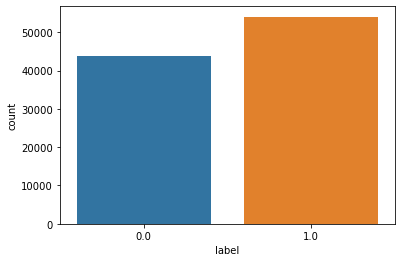

In [67]:
sns.countplot(final_samples["label"])

* The above gragh is the label with 0 and 1 that present whether user liked that movie or not, we could see that these data is not very imbalanced, the label with 0 is about 45000,and label with 1 is about 55000 out of 10k records, In this case, there is no need to do oversampling for trainning data. We could use these data as train and test data directly.


### Top 10 user who liked to watched and rated movie best

In [68]:
user_like_to_rate=final_samples.sort_values(by='userHistoryRatingCount',ascending=False).groupby("user_id").first().reset_index()
top_10_user_like_to_rate=user_like_to_rate.sort_values(by='userHistoryRatingCount',ascending=False).head(10)
top_10_user_like_to_rate

user_id  movie_id  rating  timestamp  userHistoryRatingCount  \
404      405      1591       1  885549943                     736   
654      655       131       2  893002283                     684   
12        13       916       4  892870589                     634   
449      450       245       4  892141986                     539   
275      276       264       3  892436418                     517   
415      416       354       4  893214333                     488   
536      537       550       2  886032246                     486   
302      303       330       3  879552065                     483   
233      234       301       3  892826947                     479   
392      393       539       3  891364757                     447   

     userHistoryMeanRating  userHistoryStdRating  userLikedTop5_movie_id_1  \
404               1.835598              1.345745                        99   
654               2.909357              0.732412                      1368   
12                3.097792              1.417526                       316   
449               3.864564              0.863460                      1221   
275               3.466151              1.017919                       272   
415               3.844262              1.098967                       658   
536               2.868313              0.975549                       134   
302               3.366460              1.232459                       387   
233               3.123173              0.921311                       479   
392               3.337808              0.817399                       316   

     userLikedTop5_movie_id_2  userLikedTop5_movie_id_3  ...  movieGenre2  \
404                      1063                       418  ...            0   
654                       187                       320  ...      Romance   
12                        900                       909  ...       Sci-Fi   
449                       478                       142  ...        Drama   
275                       853                         9  ...     Thriller   
415                       313                       345  ...      Romance   
536                       543                       135  ...     Thriller   
302                        67                        41  ...            0   
233                      1121                       473  ...            0   
392                       787                       143  ...       Comedy   

     movieGenre3 movieGenre4 movieGenre5 movieGenre6 age gender  occupation  \
404            0           0           0           0  22      F  healthcare   
654            0           0           0           0  50      F  healthcare   
12      Thriller           0           0           0  47      M    educator   
449     Thriller         War           0           0  35      F    educator   
275            0           0           0           0  21      M     student   
415            0           0           0           0  20      F     student   
536            0           0           0           0  36      M    engineer   
302            0           0           0           0  19      M     student   
233            0           0           0           0  60      M     retired   
392            0           0           0           0  19      M     student   

     zip_code  label  
404     10019    0.0  
654     60657    0.0  
12      29206    1.0  
449     11758    1.0  
275     95064    0.0  
415     92626    1.0  
536     22902    0.0  
302     14853    0.0  
233     94702    0.0  
392     83686    0.0  

[10 rows x 34 columns]

<AxesSubplot:xlabel='user_id', ylabel='userHistoryRatingCount'>

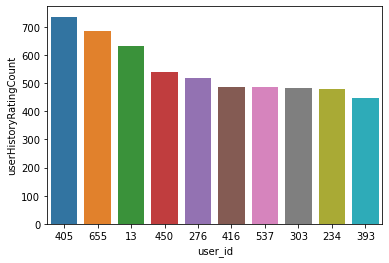

In [69]:
sns.barplot(x="user_id",y="userHistoryRatingCount",data=top_10_user_like_to_rate,order=top_10_user_like_to_rate["user_id"])

* user 405 definitely likes to rate movies, there are only 1682 movies and he/she already saw nearly half of them, which is about 736 movies.And we saw below that 405 is a female and she is only 22 years old at that time, her job is healthcare and may have much boring time, then she starts to watch movie. Which meet our expectation

In [70]:
df_user[df_user["user id"]==405]

user id  age gender  occupation zip code
404      405   22      F  healthcare    10019

### Top 10 user who didn't like to watch and rate movie

In [71]:
top_10_user_dont_like_to_rate=user_like_to_rate.sort_values(by='userHistoryRatingCount',ascending=False).tail(10)
top_10_user_dont_like_to_rate

user_id  movie_id  rating  timestamp  userHistoryRatingCount  \
728      729       689       4  893286638                      14   
735      736       127       4  878709365                      14   
368      369       900       4  889428642                      13   
18        19       153       4  885412840                      13   
807      808       750       5  883949986                      13   
731      732       321       3  882590201                      12   
131      132       664       5  891278996                      12   
35        36       358       5  882157581                      12   
557      558       285       5  879436396                      10   
739      740       300       4  879523187                      10   

     userHistoryMeanRating  userHistoryStdRating  userLikedTop5_movie_id_1  \
728               2.428571              1.283881                       354   
735               2.071429              1.071612                       246   
368               3.384615              0.869718                       316   
18                3.461538              0.877058                         8   
807               3.461538              0.877058                       333   
731               4.666667              0.492366                       304   
131               3.333333              0.492366                       100   
35                3.000000              1.044466                       307   
557               3.600000              0.699206                       286   
739               2.600000              0.699206                         0   

     userLikedTop5_movie_id_2  userLikedTop5_movie_id_3  ...  movieGenre2  \
728                       322                       362  ...     Thriller   
735                         0                         0  ...        Crime   
368                       346                       752  ...            0   
18                        887                       319  ...            0   
807                       286                       270  ...            0   
731                       332                       882  ...            0   
131                       484                        12  ...            0   
35                        333                       288  ...    Adventure   
557                       124                       275  ...            0   
739                         0                         0  ...     Thriller   

     movieGenre3 movieGenre4 movieGenre5 movieGenre6 age gender  occupation  \
728            0           0           0           0  19      M     student   
735        Drama           0           0           0  48      F      writer   
368            0           0           0           0  24      M     student   
18             0           0           0           0  40      M   librarian   
807            0           0           0           0  45      M    salesman   
731            0           0           0           0  28      F       other   
131            0           0           0           0  24      M       other   
35        Sci-Fi    Thriller           0           0  19      F     student   
557            0           0           0           0  56      F      writer   
739            0           0           0           0  25      F    educator   

     zip_code  label  
728     56567    1.0  
735     94618    1.0  
368     91335    1.0  
18       2138    1.0  
807     90016    1.0  
731     98405    0.0  
131     94612    1.0  
35      93117    1.0  
557     63132    1.0  
739     22206    1.0  

[10 rows x 34 columns]

<AxesSubplot:xlabel='user_id', ylabel='userHistoryRatingCount'>

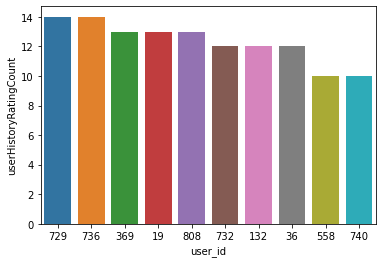

In [72]:
sns.barplot(x="user_id",y="userHistoryRatingCount",data=top_10_user_dont_like_to_rate,order=top_10_user_dont_like_to_rate["user_id"])

* User 740 and 558 is definitely didn't like to watch and rate movies, in the whold 1682 movies, they already watched and rated 10


### User mean rating values about most top 10 and least top 10

Text(0, 0.5, 'least 10 rating meaning')

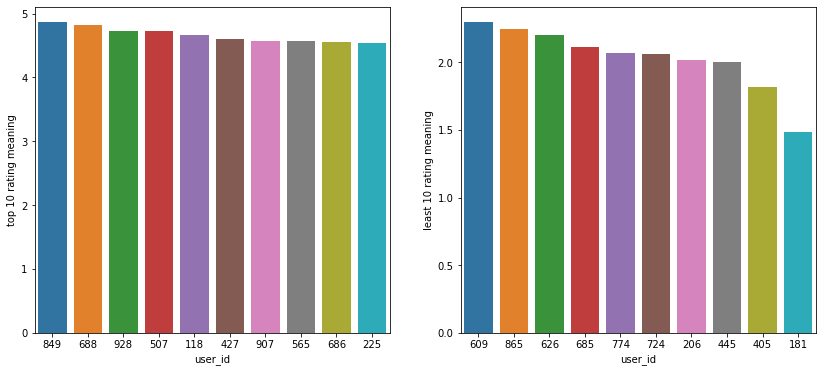

In [73]:
user_rating_mean=final_samples.groupby("user_id").mean().sort_values(by='rating',ascending=False)
top_10_user_rating_mean=user_rating_mean.reset_index().head(10)

tail_10_user_rating_mean=user_rating_mean.reset_index().tail(10)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.barplot(x="user_id",y="rating",data=top_10_user_rating_mean,order=top_10_user_rating_mean["user_id"])
plt.ylabel("top 10 rating meaning")
plt.subplot(1,2,2)
sns.barplot(x="user_id",y="rating",data=tail_10_user_rating_mean,order=tail_10_user_rating_mean["user_id"])
plt.ylabel("least 10 rating meaning")

* From above we could see that user 849 is a very nice person, all his mean rating is about 4.86, very close to 5.Actually, all the user in top 10 meaning rating seems all nice. 
* However, the least ten people are much more critical, the mean id of user 181 is only 1.5, shows he didn't like neary most of the movie he watched. 
* We are surprised that user 405 which is the person saw most movies in the critical gragh. It is extremelly surprised that she is the second least one that her mean rate is only nearly about 1.8 with 736 differenct movies! She seems really like to watch movies but then only watch movies that she did not like, which is very weird

In [74]:
final_samples.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'userHistoryRatingCount',
       'userHistoryMeanRating', 'userHistoryStdRating',
       'userLikedTop5_movie_id_1', 'userLikedTop5_movie_id_2',
       'userLikedTop5_movie_id_3', 'userLikedTop5_movie_id_4',
       'userLikedTop5_movie_id_5', 'userLiked_movie_genre_1',
       'userLiked_movie_genre_2', 'userLiked_movie_genre_3',
       'userLiked_movie_genre_4', 'userLiked_movie_genre_5',
       'userRatingGoodMovieAveReleasedYear',
       'userRatingGoodMovieStdReleasedYear', 'year', 'movieMeanRating',
       'movieStd', 'ratingCount', 'movieGenre1', 'movieGenre2', 'movieGenre3',
       'movieGenre4', 'movieGenre5', 'movieGenre6', 'age', 'gender',
       'occupation', 'zip_code', 'label'],
      dtype='object')

# Model Establishment and Test

## Build training set and testing set 

In [75]:
## upload files to colab local network for hoping the GPU to run faster.
## but yet, it is still slower than my 800$ PC and I don't know why
'''!mkdir ./train_local
!cp /content/drive/MyDrive/BS6204_Project/final_samples.zip ./train_local/
!cd ./train_local && unzip final_samples.zip'''

'!mkdir ./train_local\n!cp /content/drive/MyDrive/BS6204_Project/final_samples.zip ./train_local/\n!cd ./train_local && unzip final_samples.zip'

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#import the final features
final_samples=pd.read_csv("train_local/final_samples.csv")

human_behaviour=pd.read_csv("train_local/human_behaviours_2.csv")
human_behaviour

C:\Users\Warden\Anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


user id  movie id  rating  timestamp                 time  \
0          196       242       3  881250949  1997-12-04 23:55:49   
1          186       302       3  891717742  1998-04-05 03:22:22   
2           22       377       1  878887116  1997-11-07 15:18:36   
3          244        51       2  880606923  1997-11-27 13:02:03   
4          166       346       1  886397596  1998-02-02 13:33:16   
...        ...       ...     ...        ...                  ...   
99995      880       476       3  880175444  1997-11-22 13:10:44   
99996      716       204       5  879795543  1997-11-18 03:39:03   
99997      276      1090       1  874795795  1997-09-21 06:49:55   
99998       13       225       2  882399156  1997-12-18 06:52:36   
99999       12       203       3  879959583  1997-11-20 01:13:03   

                                          history_rating  \
0                                                     []   
1      [5, 1, 5, 3, 4, 3, 4, 2, 4, 5, 3, 3, 2, 2, 1, ...   
2      [5, 1, 1, 1, 3, 5, 5, 5, 5, 4, 4, 5, 3, 3, 4, ...   
3      [5, 3, 4, 2, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, ...   
4                                     [3, 5, 3, 5, 1, 4]   
...                                                  ...   
99995  [5, 4, 3, 3, 4, 3, 4, 4, 4, 4, 3, 4, 5, 4, 5, ...   
99996  [5, 3, 1, 5, 4, 5, 4, 4, 5, 5, 4, 4, 2, 3, 4, ...   
99997  [5, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 5, 5, ...   
99998  [4, 3, 2, 2, 2, 3, 3, 4, 3, 3, 4, 3, 5, 5, 2, ...   
99999  [4, 4, 4, 4, 5, 5, 5, 3, 4, 4, 5, 4, 5, 5, 4, ...   

                                user_think_good_movie_id  \
0                                                     []   
1      [300, 322, 291, 591, 100, 925, 281, 79, 203, 9...   
2      [258, 173, 186, 238, 153, 154, 201, 455, 692, ...   
3      [268, 294, 886, 324, 258, 772, 856, 721, 42, 3...   
4                                        [313, 347, 258]   
...                                                  ...   
99995  [302, 288, 258, 294, 328, 301, 689, 948, 181, ...   
99996  [300, 50, 222, 1, 181, 293, 127, 515, 248, 283...   
99997  [258, 300, 328, 294, 288, 324, 919, 508, 298, ...   
99998  [310, 268, 305, 302, 874, 270, 262, 303, 98, 5...   
99999  [300, 328, 754, 381, 69, 174, 28, 392, 50, 98,...   

               top5_liked_movies  userHistoryRatingCount  \
0                             []                       0   
1         [470, 77, 38, 159, 71]                      73   
2       [204, 208, 435, 523, 85]                      50   
3      [154, 652, 584, 200, 217]                     176   
4                [313, 347, 258]                       6   
...                          ...                     ...   
99995    [68, 194, 208, 204, 42]                     227   
99996   [52, 496, 611, 511, 494]                     126   
99997  [143, 419, 603, 156, 653]                     341   
99998    [427, 423, 87, 28, 404]                     491   
99999  [157, 591, 132, 196, 161]                      28   

       userHistoryMeanRating  ...  userLikedTop5_movie_id_3  \
0                   0.000000  ...                         0   
1                   3.342466  ...                        38   
2                   3.620000  ...                       435   
3                   3.772727  ...                       584   
4                   3.500000  ...                       258   
...                      ...  ...                       ...   
99995               3.378855  ...                       208   
99996               3.888889  ...                       611   
99997               3.563050  ...                       603   
99998               3.164969  ...                        87   
99999               4.285714  ...                       132   

      userLikedTop5_movie_id_4  userLikedTop5_movie_id_5  \
0                            0                         0   
1                          159                        71   
2                          523                        85   
3                          200

* **User behaviours** is the list of movie ids that user recently saw which is needed in "DIN" model, but our "final_samples" do not have this features. We need to add then into our samples. Actually the features "userLikedTop5_movie_id" can considered as user behaviour, but top 5 movies are too critical and maybe old.For example, some users may recently only rate 4 for some movies, which means the userLikedTop5_movie_id may not be updated by this recent user behaviour.In this case we will use the most recent 5 movies and "userLikedTop5_movie_id" movied both (up to 10 movie ids) as the user behaviours. 

* Although the dataset "final_samples" did not have user recent movie id list, fortunately we already get them in the file "human_behaviours_2" and we already output it, then we just could input it again and add it to this "final_samples" file

* **The "user_think_good_movie_id" columns is what we need, we can only consider the recent 5 movies that this user think good(>3.5).This is highly based on personal preference, all of them could aslo be considered. Here we only choose the most recent 5 good movies.**
* besides, these 5 column features is only used in "DIN" model beacuse that model need a sequence inputs

### add "User_recent_rated_and_liked_movie_id" to our dataset

In [77]:
human_behaviour = pd.merge(human_behaviour, final_samples[['user_id','movie_id','timestamp']],  how='right', left_on=['user id','movie id','timestamp'], right_on = ['user_id','movie_id','timestamp']).iloc[:,:-2]
human_behaviour

user id  movie id  rating  timestamp                 time  \
0           63       242       3  875747190  1997-10-02 07:06:30   
1          226       242       5  883888671  1998-01-04 12:37:51   
2          306       242       5  876503793  1997-10-11 01:16:33   
3          271       242       4  885844495  1998-01-27 03:54:55   
4          209       242       4  883589606  1998-01-01 01:33:26   
...        ...       ...     ...        ...                  ...   
97860      840      1674       4  891211682  1998-03-30 06:48:02   
97861      655      1640       3  888474646  1998-02-26 14:30:46   
97862      655      1637       3  888984255  1998-03-04 12:04:15   
97863      655      1630       3  887428735  1998-02-14 11:58:55   
97864      655      1641       3  887427810  1998-02-14 11:43:30   

                                          history_rating  \
0      [3, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 2, 2, 2, 1, ...   
1                                                 [4, 4]   
2                                                 [5, 5]   
3                                        [4, 3, 4, 4, 5]   
4      [2, 4, 4, 4, 3, 3, 5, 5, 5, 2, 2, 4, 2, 4, 5, ...   
...                                                  ...   
97860  [4, 4, 5, 5, 5, 4, 5, 5, 4, 5, 5, 4, 4, 5, 4, ...   
97861  [4, 4, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, ...   
97862  [4, 4, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, ...   
97863  [4, 4, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, ...   
97864  [4, 4, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, ...   

                                user_think_good_movie_id  \
0                              [286, 262, 333, 301, 748]   
1                                             [286, 270]   
2                                             [306, 269]   
3                                   [690, 269, 346, 302]   
4      [1137, 181, 408, 50, 127, 285, 1086, 293, 813,...   
...                                                  ...   
97860  [272, 750, 303, 884, 100, 285, 14, 515, 221, 1...   
97861  [302, 315, 242, 50, 515, 298, 1380, 6, 275, 14...   
97862  [302, 315, 242, 50, 515, 298, 1380, 6, 275, 14...   
97863  [302, 315, 242, 50, 515, 298, 1380, 6, 275, 14...   
97864  [302, 315, 242, 50, 515, 298, 1380, 6, 275, 14...   

                top5_liked_movies  userHistoryRatingCount  \
0       [301, 286, 262, 333, 748]                      21   
1                      [286, 270]                       2   
2                      [306, 269]                       2   
3            [302, 690, 269, 346]                       5   
4         [127, 285, 813, 251, 1]                      28   
...                           ...                     ...   
97860   [616, 653, 423, 443, 190]                     194   
97861  [504, 127, 1368, 187, 320]                     491   
97862   [1368, 187, 320, 30, 262]                     578   
97863    [302, 315, 242, 50, 515]                     154   
97864    [302, 315, 242, 50, 515]                     126   

       userHistoryMeanRating  ...  userLikedTop5_movie_id_3  \
0                   2.904762  ...                       262   
1                   4.000000  ...                         0   
2                   5.000000  ...                         0   
3                   4.000000  ...                       269   
4                   3.357143  ...                       813   
...                      ...  ...                       ...   
97860               4.159794  ...                       423   
97861               2.910387  ...                      1368   
97862               2.920415  ...                       320   
97863               2.915584  ...                       242   
97864               3.000000  ...                       242   

      userLikedTop5_movie_id_4  userLikedTop5_movie_id_5  \
0                          333                       748   
1                            0                         0   
2                            0                         0   
3                 

In [78]:
recent_movie_list_length=5
movie_lists=[]
for i in range(1,recent_movie_list_length+1):
    movie_lists.append([])

for movie_id_list in human_behaviour["user_think_good_movie_id"]:
    # because we input our file from the disk, unfortunately all the list are transfered to str type, and we can not
    # use the list function, then we need to transfer it back to list
    
    movie_id_list=movie_id_list[1:len(movie_id_list)-1] #eliminate the bracket "[" "]",
    movie_id_list=movie_id_list.split(",") # split the string into list based on ","
    
    # skip the null value
    if(len(movie_id_list)==1 and movie_id_list[0]==''):
        for i in range(recent_movie_list_length):
            movie_lists[i].append(0)
        continue
    
    # add the most recent movie into movie_list[0], second into movie_list[1],and so on
    length=len(movie_id_list)
    for i in range(recent_movie_list_length):
        if length>=i+1:
            recent_see_movie_id=int(movie_id_list[length-i-1].strip())
            movie_lists[i].append(recent_see_movie_id)
        else:
            movie_lists[i].append(0)

# add the movie_list[0,1,2,3,4] into the "User_recent_rated_and_liked_movie_id_i" columns
for i in range(1,recent_movie_list_length+1):
    print(i)
    final_samples["User_recent_rated_and_liked_movie_id_"+str(i)]=movie_lists[i-1]

1
2
3
4
5


In [79]:
final_samples

user_id  movie_id  rating  timestamp  userHistoryRatingCount  \
0           63       242       3  875747190                      21   
1          226       242       5  883888671                       2   
2          306       242       5  876503793                       2   
3          271       242       4  885844495                       5   
4          209       242       4  883589606                      28   
...        ...       ...     ...        ...                     ...   
97860      840      1674       4  891211682                     194   
97861      655      1640       3  888474646                     491   
97862      655      1637       3  888984255                     578   
97863      655      1630       3  887428735                     154   
97864      655      1641       3  887427810                     126   

       userHistoryMeanRating  userHistoryStdRating  userLikedTop5_movie_id_1  \
0                   2.904762              0.943650                       301   
1                   4.000000              0.000000                       286   
2                   5.000000              0.000000                       306   
3                   4.000000              0.707107                       302   
4                   3.357143              1.193013                       127   
...                      ...                   ...                       ...   
97860               4.159794              0.788671                       616   
97861               2.910387              0.756006                       504   
97862               2.920415              0.749742                      1368   
97863               2.915584              0.615182                       302   
97864               3.000000              0.565685                       302   

       userLikedTop5_movie_id_2  userLikedTop5_movie_id_3  ...  age  gender  \
0                           286                       262  ...   31       M   
1                           270                         0  ...   28       M   
2                           269                         0  ...   45       M   
3                           690                       269  ...   51       M   
4                           285                       813  ...   33       F   
...                         ...                       ...  ...  ...     ...   
97860                       653                       423  ...   39       M   
97861                       127                      1368  ...   50       F   
97862                       187                       320  ...   50       F   
97863                       315                       242  ...   50       F   
97864                       315                       242  ...   50       F   

       occupation zip_code label User_recent_rated_and_liked_movie_id_1  \
0       marketing    75240   0.0                                    748   
1         student    92103   1.0                                    270   
2           other    73132   1.0                                    269   
3        engineer    22932   1.0                                    302   
4        educator    85710   1.0                                    321   
...           ...      ...   ...                                    ...   
97860      artist    55406   1.0                                    949   
97861  healthcare    60657   0.0                                    320   
97862  healthcare    60657   0.0                                    447   
97863  healthcare    60657   0.0                                    216   
97864  healthcare    60657   0.0                                   1211   

      User_recent_rated_and_liked_movie_id_2  \
0                                        301   
1                                        286   
2                                        306   
3                                        346   
4                                        766   
...                                      ...   
97860  

In [80]:
final_samples['movieGenre6']=final_samples['movieGenre6'].apply(str)

### perpare the train and test dataset

In [81]:
#extract the numerical features
numerical_features=[
                    "userHistoryRatingCount",
                "userHistoryMeanRating",
                "userHistoryStdRating",
                "userRatingGoodMovieAveReleasedYear",
                "userRatingGoodMovieStdReleasedYear",
                "year",
                "movieMeanRating",
                "movieStd",
                "ratingCount",
                "age"
]

# standard normalization to numerical features
sc=StandardScaler()
final_samples[numerical_features]=sc.fit_transform(final_samples[numerical_features])

#drop the values we don't need
X=final_samples.drop(["label","rating",'timestamp'],axis=1)
y=final_samples["label"]

#set the batch size
batch_size=30

#split train and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)
#split train into train and valid set
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.1,stratify=y_train,random_state=1)

In [82]:
#set dataset as tensoflow.Dataset
train_dataset_0=tf.data.Dataset.from_tensor_slices((dict(X_train),y_train))

valid_dataset_0=tf.data.Dataset.from_tensor_slices((dict(X_valid),y_valid))

test_dataset_0=tf.data.Dataset.from_tensor_slices((dict(X_test),y_test))


# random shuffle the data
train_dataset=train_dataset_0.shuffle(100)
valid_dataset=valid_dataset_0.shuffle(100)
test_dataset=test_dataset_0.shuffle(100)

#set the batch size of each iteration of the dataset
train_dataset=train_dataset_0.batch(batch_size)
valid_dataset=valid_dataset_0.batch(batch_size)
test_dataset=test_dataset_0.batch(batch_size)

## Deep learning Model

 Here we implement many classical deep learning  model in Recommendation Systems like：
 * BaseEmbedding model,
 * Deep Crossing, 
 * Deep CF, 
 * Wide&Deep,
 * AFM, 
 * DIN. 
 
 * We will follow the structures about these models and change the neron numbers to let the model more suitable for our dataset.

## Base Model: Embedding+MLP
 * the base model in recommendation system is the embeddeing layers followed by some MLP,then we first implement the base model and find the best hyperparameter for base model, it can help us to fine tune the next few models

#### Load features

In [83]:
len(final_samples['user_id'].unique())

943

In [84]:
#perpare for embedding layer parameters
Gender=["F","M"]

movie_types=["unknown","Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir",
             "Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]

Occupation=["administrator","artist","doctor","educator","engineer","entertainment","executive","healthcare","homemaker","lawyer","librarian",
          "marketing","none","other","programmer","retired","salesman","scientist","student","technician","writer"]

Zip_code=final_samples["zip_code"].unique().tolist()

Moive_id=final_samples["movie_id"].unique().tolist()

ALL_FEATURES={ 'userLiked_movie_genre_1': movie_types, 
          'userLiked_movie_genre_2': movie_types, 
          'userLiked_movie_genre_3': movie_types, 
          'userLiked_movie_genre_4': movie_types, 
          'userLiked_movie_genre_5': movie_types, 
          'movieGenre1': movie_types,
          'movieGenre2': movie_types, 
          'movieGenre3': movie_types, 
          'movieGenre4': movie_types, 
          'movieGenre5': movie_types, 
          'movieGenre6': movie_types,
          "userLikedTop5_movie_id_1":Moive_id,
          "userLikedTop5_movie_id_2":Moive_id,
          "userLikedTop5_movie_id_3":Moive_id,
          "userLikedTop5_movie_id_4":Moive_id,
          "userLikedTop5_movie_id_5":Moive_id,
          "zip_code": Zip_code,
          "occupation":Occupation}

categorical_cols=[]
dim_stack=0

#embedding categorical values to low 10 dimension and update the total dimension (dim_stack)
for column,vocab in ALL_FEATURES.items():
    col=tf.feature_column.categorical_column_with_vocabulary_list(
         key=column,vocabulary_list=vocab
      )
    cat_embedding=tf.feature_column.embedding_column(col,10)
    dim_stack+=10
    categorical_cols.append(cat_embedding)

#embedding movie id,there are 1682 movies so we set the num_buckets a little bit larger.
movie_id_one_hot=tf.feature_column.categorical_column_with_identity(key="movie_id",num_buckets=1683)
movieId=tf.feature_column.embedding_column(movie_id_one_hot,10)
dim_stack+=10
#embedding user id,there are 943 user so we set the num_buckets a little bit larger.
user_id_one_hot=tf.feature_column.categorical_column_with_identity(key="user_id",num_buckets=944)
userId=tf.feature_column.embedding_column(user_id_one_hot,10)
dim_stack+=10
categorical_cols.append(movieId)
categorical_cols.append(userId)


#because gender dimension is lower than 10,we add them directly 
gender_one_hot=tf.feature_column.categorical_column_with_vocabulary_list(key="gender",vocabulary_list=Gender)
gender_indicator=tf.feature_column.indicator_column(gender_one_hot)
categorical_cols.append(gender_indicator)
dim_stack+=2

In [85]:
for c in categorical_cols:
    print(c.categorical_column.key)

userLiked_movie_genre_1
userLiked_movie_genre_2
userLiked_movie_genre_3
userLiked_movie_genre_4
userLiked_movie_genre_5
movieGenre1
movieGenre2
movieGenre3
movieGenre4
movieGenre5
movieGenre6
userLikedTop5_movie_id_1
userLikedTop5_movie_id_2
userLikedTop5_movie_id_3
userLikedTop5_movie_id_4
userLikedTop5_movie_id_5
zip_code
occupation
movie_id
user_id
gender


### function to save and reload model for further usage

In [86]:
import h5py
from tensorflow.keras.models import load_model
def save_model_and_history_to(model,history,name):
    ##save the model to google drive for further usage
    MODEL_PATH = name+'_model.h5'
    model.save_weights(MODEL_PATH)

    ## save the history of model while training

    pd.DataFrame(history.history).to_csv(name+"_history.csv")
    
def reload_model_and_history(name,model,test_dataset,parameter=None):
    # re-load the model.
    # the tf has a bug about load the model with DenseFeature layers
    # this is the only anwser I find on Internet that can work, which is initializing the same model and train it once
    # then the model can be successfully loaded.
    if parameter==None:
        load_model=model()
    elif name=='Nerual_CF':
        load_model=model(movie_columns_mf=[parameter[0]],user_columns_mf=[parameter[1]],dropout=parameter[2],regularizer=parameter[3])
    else:
        load_model=model(parameter)
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
    load_model.compile(loss="binary_crossentropy",
                           optimizer=optimizer,
                           metrics=["accuracy",tf.keras.metrics.AUC(curve="ROC")])
    history = load_model.fit(test_dataset, batch_size=1, epochs=1)
    load_model.load_weights(name+"_model.h5")
    history=pd.read_csv(name+"_history.csv")
    return load_model,history

In [87]:
#add numerical directly to the layers

numerical_cols=[tf.feature_column.numeric_column("userHistoryRatingCount"),
                tf.feature_column.numeric_column("userHistoryMeanRating"),
                tf.feature_column.numeric_column("userHistoryStdRating"),
                tf.feature_column.numeric_column("userRatingGoodMovieAveReleasedYear"),
                tf.feature_column.numeric_column("userRatingGoodMovieStdReleasedYear"),
                tf.feature_column.numeric_column("year"),
                tf.feature_column.numeric_column("movieMeanRating"),
                tf.feature_column.numeric_column("movieStd"),
                tf.feature_column.numeric_column("ratingCount"),
                tf.feature_column.numeric_column("age"),             
          ]
# keep updating the embedding layer dimension
dim_stack+=10

#### Define Model and complie

In [88]:

preprocessing_layer = tf.keras.layers.DenseFeatures(numerical_cols + categorical_cols)

def MyEMBED_MLP_Model():
    model = tf.keras.Sequential([
    preprocessing_layer, 
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
    return model
model=MyEMBED_MLP_Model()

In [89]:
def demo(example_batch):
    print(preprocessing_layer(example_batch).numpy().shape)

In [90]:
demo(next(iter(train_dataset))[0])

(30, 212)


In [91]:
history_two_layers_EMB_MLP=model.fit(train_dataset,epochs=30,validation_data=valid_dataset)

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2340/2349 [============================>.] - ETA: 0s - loss: 0.5756 - accuracy: 0.6965 - auc: 0.7583WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_33:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_19:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_21:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_22:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_23:0' shape=(None, 1) dtype

#### Output the model evaluation

In [92]:
#output the model evaluation
_,acc,auc=model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (acc,auc))

653/653 [==============================] - 1s 2ms/step - loss: 3.4239 - accuracy: 0.6635 - auc: 0.6992
The evaluation of this model shows the accuracy of this model is 0.664, auc of roc curve is 0.699.


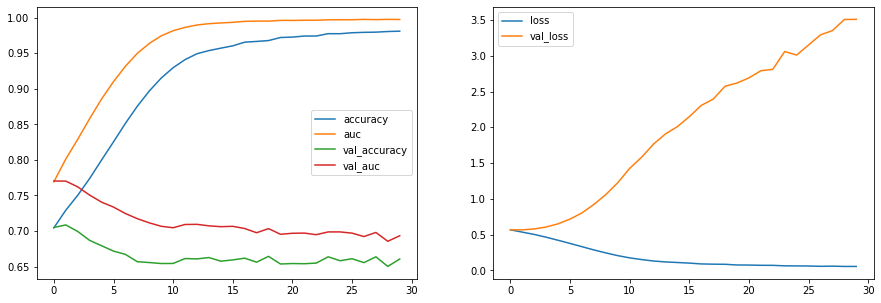

In [93]:
plt.figure(figsize=(15,5))
    #metrics
plt.subplot(1,2,1)
plt.plot(range(30),history_two_layers_EMB_MLP.history["accuracy"])
plt.plot(range(30),history_two_layers_EMB_MLP.history["auc"])

plt.plot(range(30),history_two_layers_EMB_MLP.history["val_accuracy"])
plt.plot(range(30),history_two_layers_EMB_MLP.history["val_auc"])
plt.legend(["accuracy","auc","val_accuracy","val_auc"])

#loss
plt.subplot(1,2,2)
plt.plot(range(30),history_two_layers_EMB_MLP.history["loss"])
plt.plot(range(30),history_two_layers_EMB_MLP.history["val_loss"])
plt.legend(["loss","val_loss"])

The first 4-layer model is overfited too much, the accuracy and auc is extremely high , valid metrics keep decreasing all the time and loss is also very high. The validation auc is 0.6774 and the final test auc is 0.680, but the train auc is 0.9978

### Symplify model

In [94]:
def MyEMBED_MLP_Model():
    model = tf.keras.Sequential([
    preprocessing_layer, 
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
    return model
model=MyEMBED_MLP_Model()

In [95]:
history_simp_EMB_MLP=model.fit(train_dataset,epochs=30,validation_data=valid_dataset)

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2341/2349 [============================>.] - ETA: 0s - loss: 0.5189 - accuracy: 0.7346 - auc_1: 0.8115WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_33:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_19:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_21:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_22:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_23:0' shape=(None, 1) dty

In [96]:
#output the model evaluation
_,acc,auc=model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (acc,auc))

653/653 [==============================] - 1s 2ms/step - loss: 3.9114 - accuracy: 0.6619 - auc_1: 0.6882
The evaluation of this model shows the accuracy of this model is 0.662, auc of roc curve is 0.688.


In [97]:
def plot_loss_and_metric_values(history,epoch,count):
    plt.figure(figsize=(15,5))
    #metrics
    plt.subplot(1,2,1)
    plt.plot(range(epoch),history.history["accuracy"])
    plt.plot(range(epoch),history.history["auc_"+str(count)])

    plt.plot(range(epoch),history.history["val_accuracy"])
    plt.plot(range(epoch),history.history["val_auc_"+str(count)])
    plt.legend(["accuracy","auc","val_accuracy","val_auc"])

    #loss
    plt.subplot(1,2,2)
    plt.plot(range(epoch),history.history["loss"])
    plt.plot(range(epoch),history.history["val_loss"])
    plt.legend(["loss","val_loss"])

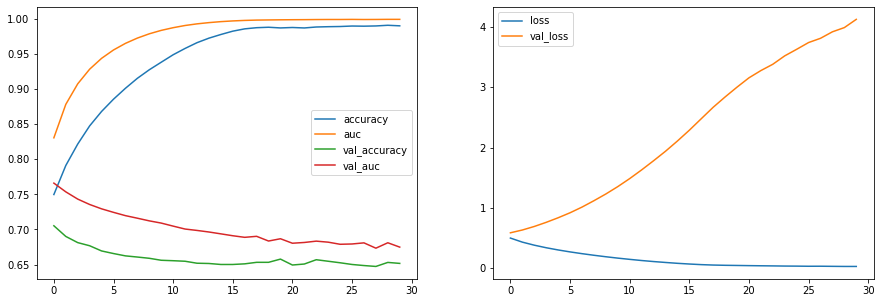

In [98]:
plot_loss_and_metric_values(history_simp_EMB_MLP,30,1)

The validation auc is 0.6735 and the final test auc is 0.684, but the train auc is 0.9995,The 3-layer model also is overfited too much, the accuracy and auc is extremely high , valid metrics keep decreasing all the time and loss is also very high. 

### Add Dropout Layers

In [99]:
def MyEMBED_MLP_Model():
    model = tf.keras.Sequential([
    preprocessing_layer, 
    tf.keras.layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
    return model
model=MyEMBED_MLP_Model()

In [100]:
history_add_drop_out_EMB_MLP=model.fit(train_dataset,epochs=30,validation_data=valid_dataset)

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2346/2349 [============================>.] - ETA: 0s - loss: 0.5567 - accuracy: 0.7084 - auc_2: 0.7747WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_33:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_19:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_21:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_22:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_23:0' shape=(None, 1) dty

In [101]:
#output the model evaluation
_,acc,auc=model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (acc,auc))

653/653 [==============================] - 1s 2ms/step - loss: 1.2410 - accuracy: 0.6832 - auc_2: 0.7376
The evaluation of this model shows the accuracy of this model is 0.683, auc of roc curve is 0.738.


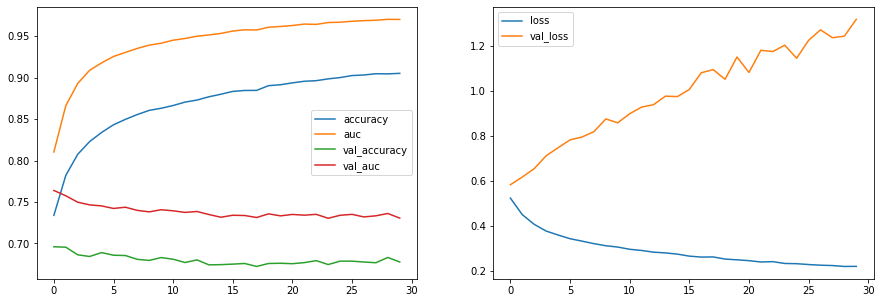

In [102]:
plot_loss_and_metric_values(history_add_drop_out_EMB_MLP,30,2)

The validation auc is 0.7255 and the final test auc is 0.733, but the train auc is 0.9719,The 4-layer model with dropout also is overfited , ,the accuracy and auc is extremely high , valid metrics keep decreasing all the time and loss is also very high, we could see in the validation loss, it actually always keep increasing.

### Add regularizers in Dense layers

In [103]:
def MyEMBED_MLP_Model():
    model = tf.keras.Sequential([
    preprocessing_layer, 
    tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.3)),
    tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.3)),
    tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
    return model
model=MyEMBED_MLP_Model()

In [104]:
history_add_regularization_EMB_MLP=model.fit(train_dataset,epochs=30,validation_data=valid_dataset)

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2340/2349 [============================>.] - ETA: 0s - loss: 7.8072 - accuracy: 0.6097 - auc_3: 0.6862WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_33:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_19:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_21:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_22:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_23:0' shape=(None, 1) dty

In [105]:
#output the model evaluation
_,acc,auc=model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (acc,auc))

653/653 [==============================] - 1s 2ms/step - loss: 0.9227 - accuracy: 0.6357 - auc_3: 0.6791
The evaluation of this model shows the accuracy of this model is 0.636, auc of roc curve is 0.679.


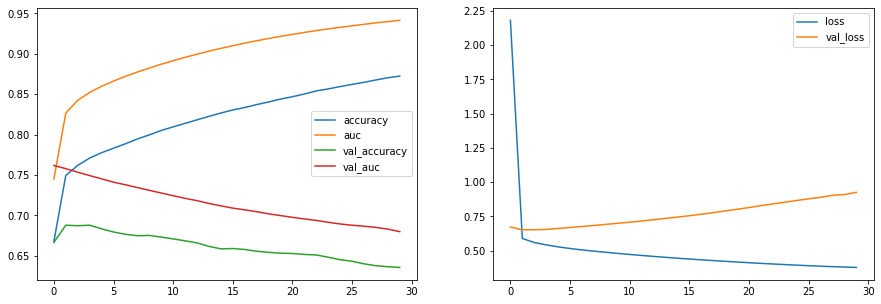

In [106]:
plot_loss_and_metric_values(history_add_regularization_EMB_MLP,30,3)

The validation auc is 0.6822 and the final test auc is 0.683, but the train auc is 0.9424 ,The 4-layer model with regularizer also is overfited , the accuracy and auc is extremely high , valid metrics keep decreasing all the time and loss is also very high, we could see in the validation loss, it also always keep increasing.

turns out that all the methods is not good enough, then we try to combine them together

### Combine useful methods (dropout and regularization)  together


In [107]:
def MyEMBED_MLP_Model():
    model = tf.keras.Sequential([
    preprocessing_layer, 
    tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.4)),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.4)),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    return model
model=MyEMBED_MLP_Model()

In [108]:
model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])

history_add_regularization_and_dropout_EMB_MLP=model.fit(train_dataset,epochs=30,validation_data=valid_dataset)

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2347/2349 [============================>.] - ETA: 0s - loss: 10.0700 - accuracy: 0.5583 - auc_4: 0.5375WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_33:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_19:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_21:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_22:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_23:0' shape=(None, 1) dt

In [109]:
#output the model evaluation
_,acc,auc=model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (acc,auc))

653/653 [==============================] - 1s 2ms/step - loss: 0.6877 - accuracy: 0.5524 - auc_4: 0.5000
The evaluation of this model shows the accuracy of this model is 0.552, auc of roc curve is 0.500.


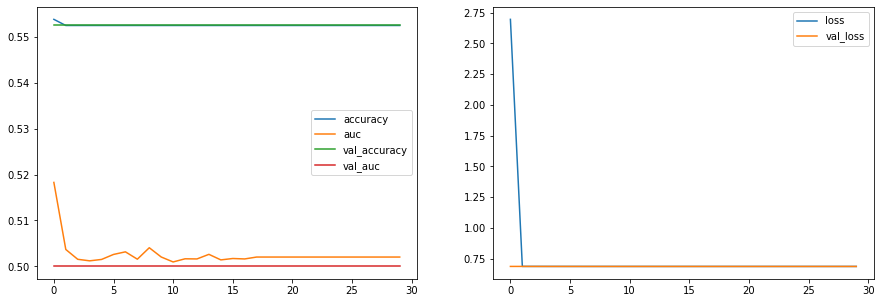

In [110]:
plot_loss_and_metric_values(history_add_regularization_and_dropout_EMB_MLP,30,4)

from the above ,we could see that when we combine the methods together, it actually could help, at least the validation loss stop to increase and vibrate in abound 1.3. Auc and accuracy also reach the plateau. but we could see that validation auc is still low ,only 0.6814,test auc is 0.679, but tha train auc is high, about 0.9527 . We also could see that at the begining, the validation loss already starts to increase. So next, we will change our neron numbers of hidden layer to find a good model

### adjust number of hiddenlayer
from above we now that these method above could help to tune the base model, but the value of hyperparameter seems not good enough,then we adjust the number of hidden layer to see the performance 

In [111]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [112]:
def MyEMBED_MLP_Model(layer_number=0,hidden_layer_neruals=128):
    model = tf.keras.Sequential()
    model.add(preprocessing_layer)
    
    ## use a for loop to decide how many hidden layers should we build
    for _ in range(layer_number):
        
        #hidden_layer_neruals means the output neuron number of the Dense Layer
        model.add(tf.keras.layers.Dense(hidden_layer_neruals,activation='relu')) 
        model.add(layers.Dropout(0.5))
        
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
    return model


#prepare the number candidate
layer_numbers=[1,2,3]
hidden_layers=[16,32,64,128]

history_loss_collection=[]

# double for loop to get the best pyrameter groups about the candidate above.
# and collect the validation loss of each group to decide which parameter group is best
for layer_number in layer_numbers:
    for hidden_layer in hidden_layers:
        model=MyEMBED_MLP_Model(layer_number,hidden_layer)
        history=model.fit(train_dataset,epochs=30,validation_data=valid_dataset,callbacks=[es])
        history_loss_collection.append(history.history["val_loss"])

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2345/2349 [============================>.] - ETA: 0s - loss: 0.5358 - accuracy: 0.7254 - auc_5: 0.7975WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_33:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_19:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_21:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_22:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_23:0' shape=(None, 1) dty

C:\Users\Warden\Anaconda3\envs\DeepLearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'val_loss')

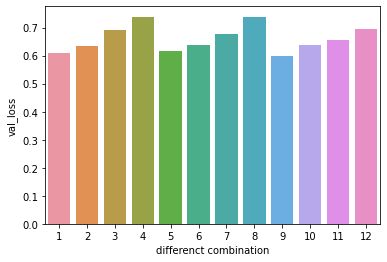

In [113]:
#visualization the validation loss
min_value=[]
for mi in history_loss_collection:
    min_value.append(np.min(mi))
sns.barplot(list(range(1,13)),min_value)
plt.xlabel("differenct combination")
plt.ylabel("val_loss")

From above we could see that when the neuron number increase, the validation loss starts to increase, So 16 is the best, for each group. Then we could find out result shows that 3 layers with 16 neurons are the best 

**Then we change the layer to 3, neron number of each hidden layer to 16, and then fine tune the best dropout probability**

In [114]:
#Then we change the layer to 3, neron number of each hidden layer to 16, and then fine tune the best dropout probability
def MyEMBED_MLP_Model(dropout):
    model = tf.keras.Sequential()
    model.add(preprocessing_layer)
    
    for _ in range(3):
        model.add(tf.keras.layers.Dense(16,activation='relu'))
        model.add(layers.Dropout(dropout))
        
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
    return model

dropouts=[0.2,0.4,0.5,0.6,0.8,0.9]


history_loss_collection_drop_out=[]

for dropout in dropouts:
    model=MyEMBED_MLP_Model(dropout)
    history=model.fit(train_dataset,epochs=30,validation_data=valid_dataset,callbacks=[es])
    history_loss_collection_drop_out.append(history.history["val_loss"])

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2338/2349 [============================>.] - ETA: 0s - loss: 0.5159 - accuracy: 0.7280 - auc_17: 0.8106WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_33:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_19:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_21:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_22:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_23:0' shape=(None, 1) dt

C:\Users\Warden\Anaconda3\envs\DeepLearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'val_loss')

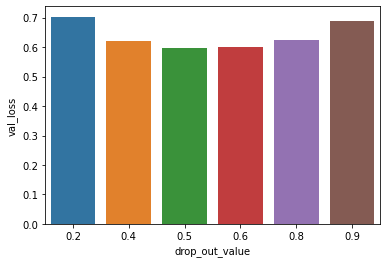

In [115]:
min_value_dropout=[]
for mi in history_loss_collection_drop_out:
    min_value_dropout.append(np.min(mi))
sns.barplot(dropouts,min_value_dropout)
plt.xlabel("drop_out_value")
plt.ylabel("val_loss")

The barplot shows 0.4 has the lowset validation loss and may the best drop probablity

then our base model finally is 3-hidden-layers with 16 neurons in each hidden-layers, and the dropout probablity is 0.4,regularizer is no need since we add "early stopping" callbacks and performance of models is already good at the begining,  then we finally use these hyerparameters to bulid our final model and use test data to show the performance

In [116]:
def MyEMBED_MLP_Model():
    model = tf.keras.Sequential()
    model.add(preprocessing_layer)
    
    for _ in range(3):
        model.add(tf.keras.layers.Dense(16,activation='relu'))
        model.add(layers.Dropout(0.4))
        
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

model=MyEMBED_MLP_Model()

In [117]:
model.compile( loss='binary_crossentropy',  optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
history_final_base_model=model.fit(train_dataset,epochs=30,validation_data=valid_dataset,callbacks=[es])

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2339/2349 [============================>.] - ETA: 0s - loss: 0.5773 - accuracy: 0.6875 - auc_23: 0.7541WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_33:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_19:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_21:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_22:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_23:0' shape=(None, 1) dt

In [118]:
#output the model evaluation
_,acc_base,auc_base=model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (acc_base,auc_base))

653/653 [==============================] - 1s 2ms/step - loss: 0.6915 - accuracy: 0.6894 - auc_23: 0.7426
The evaluation of this model shows the accuracy of this model is 0.689, auc of roc curve is 0.743.


In [119]:
history_final_base_model

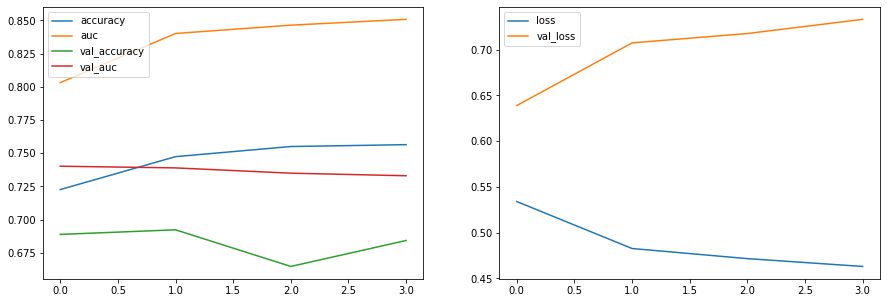

In [120]:
plot_loss_and_metric_values(history_final_base_model,4,23)

From the above tune methods, we get a base model with ROC AUC 0.744 and accuracy 0.6905, which seems not high

### save model

In [121]:
save_model_and_history_to(model,history_final_base_model,"EMBED_MLP")

## Deep Crossing

Deep crossing changes the MLP layer into Residual Layer, whose output is the combination of the inputs and the outputs of two dense layers.The combination will get more information about the inputs

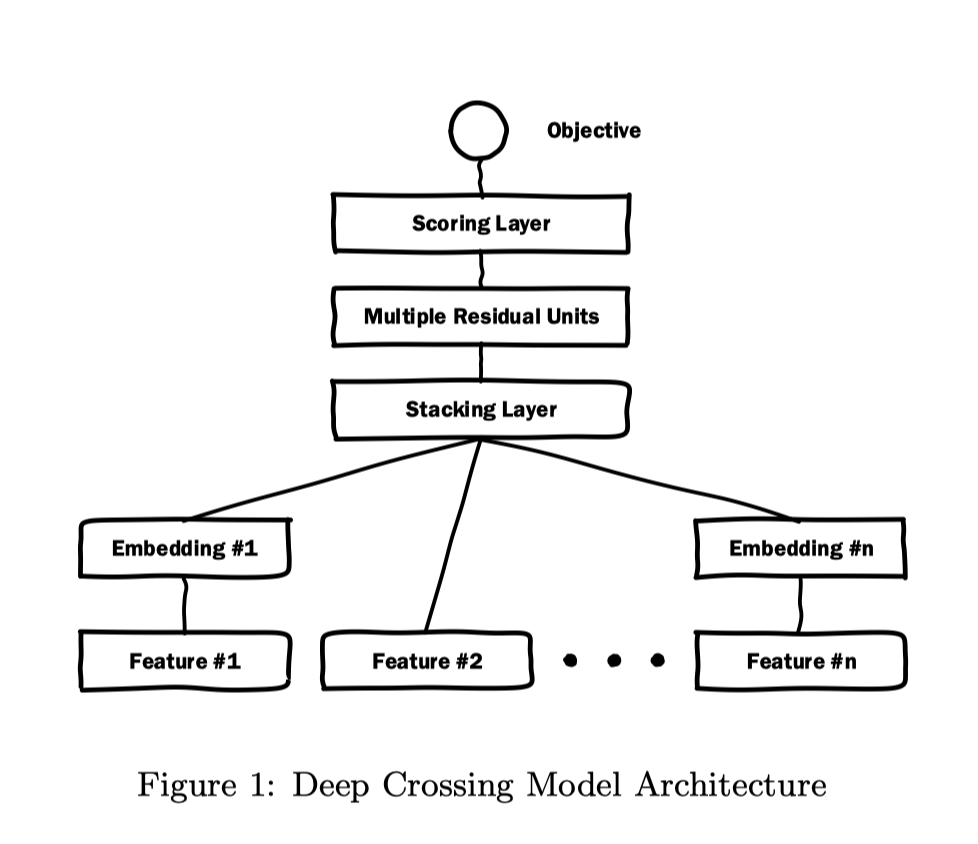

In [122]:
from tensorflow.keras import regularizers
class Residual_Units(layers.Layer):
    def __init__(self,hidden_unit,dim_stack_layer):
        super(Residual_Units,self).__init__()
        self.layer1=layers.Dense(units=hidden_unit,activation='relu',kernel_regularizer=regularizers.l2(1))
        self.layer2=layers.Dense(units=dim_stack_layer,kernel_regularizer=regularizers.l2(1))
        self.relu=layers.ReLU()
        
    def call(self,inputs):
        x=self.layer1(inputs)
        x=self.layer2(x)
        output=self.relu(x+inputs)
        return output 

In [123]:
len(numerical_cols)

10

In [124]:
len(categorical_cols)

21

In [125]:
dim_stack

212

In [126]:
def Deep_Crossing(dim_stack): 
    inputs={
        ## numerical input layers
        'userHistoryMeanRating': tf.keras.layers.Input(name='userHistoryMeanRating', shape=(), dtype='float32'),
        'userHistoryStdRating': tf.keras.layers.Input(name='userHistoryStdRating', shape=(), dtype='float32'),
        'userRatingGoodMovieAveReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieAveReleasedYear', shape=(), dtype='int32'),
        'userRatingGoodMovieStdReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieStdReleasedYear', shape=(), dtype='float32'),
        'year': tf.keras.layers.Input(name='year', shape=(), dtype='int32'),
        'movieMeanRating': tf.keras.layers.Input(name='movieMeanRating', shape=(), dtype='float32'),
        'movieStd': tf.keras.layers.Input(name='movieStd', shape=(), dtype='float32'),

        'ratingCount': tf.keras.layers.Input(name='ratingCount', shape=(), dtype='int32'),
        'age': tf.keras.layers.Input(name='age', shape=(), dtype='int32'),
        'userHistoryRatingCount': tf.keras.layers.Input(name='userHistoryRatingCount', shape=(), dtype='int32'),

        ## categorical input layers
        'movie_id': tf.keras.layers.Input(name='movie_id', shape=(), dtype='int32'),
        'user_id': tf.keras.layers.Input(name='user_id', shape=(), dtype='int32'),
        'gender': tf.keras.layers.Input(name='gender', shape=(), dtype='string'),
        
        
        'userLiked_movie_genre_1': tf.keras.layers.Input(name='userLiked_movie_genre_1', shape=(), dtype='string'),
        'userLiked_movie_genre_2': tf.keras.layers.Input(name='userLiked_movie_genre_2', shape=(), dtype='string'),
        'userLiked_movie_genre_3': tf.keras.layers.Input(name='userLiked_movie_genre_3', shape=(), dtype='string'),
        'userLiked_movie_genre_4': tf.keras.layers.Input(name='userLiked_movie_genre_4', shape=(), dtype='string'),
        'userLiked_movie_genre_5': tf.keras.layers.Input(name='userLiked_movie_genre_5', shape=(), dtype='string'),
        'movieGenre1': tf.keras.layers.Input(name='movieGenre1', shape=(), dtype='string'),
        'movieGenre2': tf.keras.layers.Input(name='movieGenre2', shape=(), dtype='string'),
        'movieGenre3': tf.keras.layers.Input(name='movieGenre3', shape=(), dtype='string'),
        'movieGenre4': tf.keras.layers.Input(name='movieGenre4', shape=(), dtype='string'),
        'movieGenre5': tf.keras.layers.Input(name='movieGenre5', shape=(), dtype='string'),
        'movieGenre6': tf.keras.layers.Input(name='movieGenre6', shape=(), dtype='string'),
        'userLikedTop5_movie_id_1': tf.keras.layers.Input(name='userLikedTop5_movie_id_1', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_2': tf.keras.layers.Input(name='userLikedTop5_movie_id_2', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_3': tf.keras.layers.Input(name='userLikedTop5_movie_id_3', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_4': tf.keras.layers.Input(name='userLikedTop5_movie_id_4', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_5': tf.keras.layers.Input(name='userLikedTop5_movie_id_5', shape=(), dtype='int32'),
        'zip_code': tf.keras.layers.Input(name='zip_code', shape=(), dtype='string'),
        'occupation': tf.keras.layers.Input(name='occupation', shape=(), dtype='string'),
    }
    #embedding layer
    embedding_layer=layers.DenseFeatures(numerical_cols + categorical_cols)(inputs)

    #residual layer
    residual_output=Residual_Units(64,dim_stack)(embedding_layer)
    #add an drop function
    drop_out_layer=layers.Dropout(0.5)(residual_output)
    #output layer
    output_layer=layers.Dense(1,activation='sigmoid')(drop_out_layer)
    
    model=keras.Model(inputs,output_layer)
    return model

dp_model=Deep_Crossing(dim_stack)

2021-08-05

In [127]:
dp_model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
history_dp_crossing=dp_model.fit(train_dataset,epochs=30,validation_data=valid_dataset,callbacks=[es])

Epoch 1/30


C:\Users\Warden\Anaconda3\envs\DeepLearning\lib\site-packages\tensorflow\python\keras\engine\functional.py:592: UserWarning: Input dict contained keys ['User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


2349/2349 [==============================] - 17s 5ms/step - loss: 17.2690 - accuracy: 0.6034 - auc_24: 0.6356 - val_loss: 0.6026 - val_accuracy: 0.6828 - val_auc_24: 0.7447
Epoch 2/30
2349/2349 [==============================] - 9s 4ms/step - loss: 0.6115 - accuracy: 0.6654 - auc_24: 0.7186 - val_loss: 0.5883 - val_accuracy: 0.6889 - val_auc_24: 0.7516
Epoch 3/30
2349/2349 [==============================] - 9s 4ms/step - loss: 0.5886 - accuracy: 0.6889 - auc_24: 0.7477 - val_loss: 0.5831 - val_accuracy: 0.6963 - val_auc_24: 0.7555
Epoch 4/30
2349/2349 [==============================] - 9s 4ms/step - loss: 0.5804 - accuracy: 0.6981 - auc_24: 0.7582 - val_loss: 0.5803 - val_accuracy: 0.6968 - val_auc_24: 0.7575
Epoch 5/30
2349/2349 [==============================] - 9s 4ms/step - loss: 0.5717 - accuracy: 0.7020 - auc_24: 0.7673 - val_loss: 0.5795 - val_accuracy: 0.6973 - val_auc_24: 0.7578
Epoch 6/30
2349/2349 [==============================] - 9s 4ms/step - loss: 0.5664 - accuracy: 0.70

In [128]:
dp_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
age (InputLayer)                [(None,)]            0                                            
__________________________________________________________________________________________________
gender (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
movieGenre1 (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
movieGenre2 (InputLayer)        [(None,)]            0                                            
______________________________________________________________________________________________

In [129]:
#output the model evaluation
dc_loss,dc_acc,dc_auc=dp_model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (dc_acc,dc_auc))

653/653 [==============================] - 1s 2ms/step - loss: 0.5687 - accuracy: 0.7064 - auc_24: 0.7702
The evaluation of this model shows the accuracy of this model is 0.706, auc of roc curve is 0.770.


ValueError: x and y must have same first dimension, but have shapes (10,) and (12,)

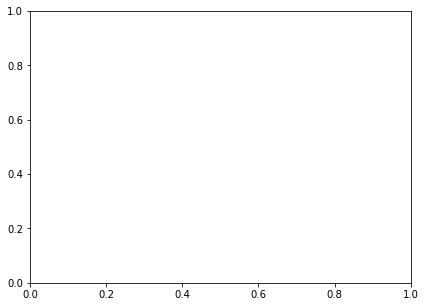

In [130]:
plot_loss_and_metric_values(history_dp_crossing,10,24)

### Save Deep-Crossing model

In [ ]:
save_model_and_history_to(dp_model,history_dp_crossing,"Deep_Crossing")

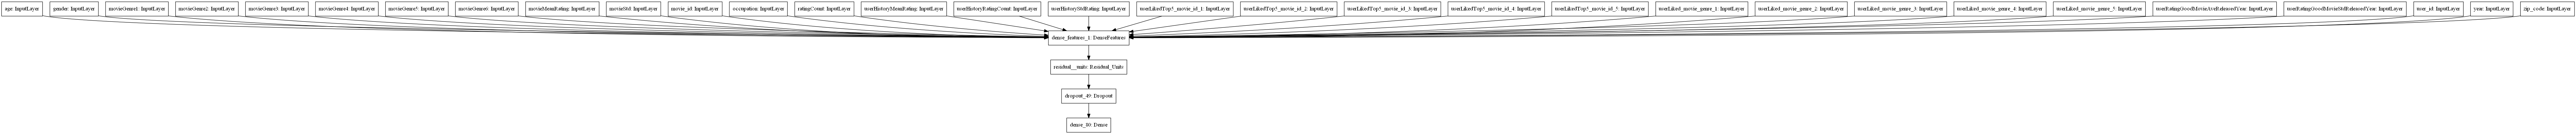

In [ ]:
keras.utils.plot_model(dp_model) 
# we want to plot the model gragh, 
# but this function seems have a lot of bugs and can not work well even we ask on the Internet

##  Neural CF
 Neural CF only need "movie id", "user id" as inputs, and label as label. it changes the classical CF into deep learning model,There are two towers, the first tower is MLP layer with the embedding layers of Movie id and user id, the another tower is the Element- wise product of Embediing layers of Movie id and user id, and then concatenate outputs of two towers as one to predict the label.
* use the first 2 columns in "final_samples" to build the import dataset of Neural CF

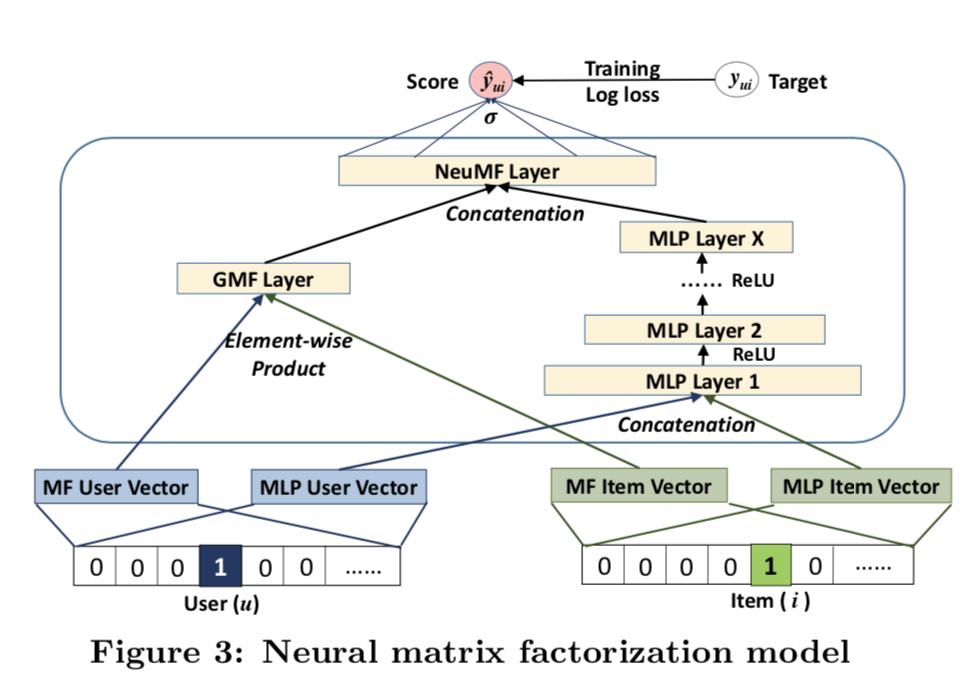

In [ ]:
# MLP Embeding
movieId_mlp=movieId
userId_mlp=userId


#MF Embedding (Element wise embedeing layer number is different with the MLP embedding layer)

hidden_vector_dim=32
movieId_mf=tf.feature_column.embedding_column(movie_id_one_hot,hidden_vector_dim)
userId_mf=tf.feature_column.embedding_column(user_id_one_hot,hidden_vector_dim)


In [ ]:
def NerualCF(movie_columns_mlp=[movieId_mlp], user_columns_mlp=[userId_mlp],movie_columns_mf=[movieId_mf], user_columns_mf=[userId_mf],hidden_unit=[10,10],dropout=0.7,regularizer=regularizers.l2(1)):
    inputs={
        "movie_id":layers.Input(name="movie_id",shape=(), dtype='int32'),
        "user_id":layers.Input(name="user_id",shape=(), dtype='int32'),
    }
    
    #MLP embeding layer
    movie_embeding_mlp=layers.DenseFeatures(movie_columns_mlp)(inputs) # dim (1,10)
    user_embeding_mlp=layers.DenseFeatures(user_columns_mlp)(inputs) # dim (1,10)
    
    mlp_layers=layers.concatenate([movie_embeding_mlp,user_embeding_mlp]) # dim (1,10+10)
    
    #MLP layers
    for unit in hidden_unit:
        mlp_layers=layers.Dense(unit,activation="relu",kernel_regularizer=regularizer)(mlp_layers) #dim (1,hidden_unit)
    mlp_layers=layers.Dropout(dropout)(mlp_layers)
    
    #MF embeding layer
    movie_embeding_mf=layers.DenseFeatures(movie_columns_mf)(inputs) #dim(1,hidden_vector_dim)
    user_embeding_mf=layers.DenseFeatures(user_columns_mf)(inputs) #dim(1,hidden_vector_dim)
    
    #GMF layers
    mf_layers=tf.multiply(movie_embeding_mf,user_embeding_mf) #dim(1,hidden_vector_dim)(element wise product)
    
    # concate MF and MLP layers together 
    concate_layer=layers.concatenate([mlp_layers,mf_layers]) #dim(1,hidden_vector_dim + hidden_unit)
    
    #output the result
    output_layer=layers.Dropout(dropout)(concate_layer)
    output_layer=layers.Dense(1,activation='sigmoid')(output_layer)
    
    
    nerual_cf_model=keras.Model(inputs,output_layer)
    return nerual_cf_model

In [ ]:
ncf_model=NerualCF([movieId_mlp],[userId_mlp],[movieId_mf],[userId_mf],[10,10],0.7,regularizers.l2(1))

ncf_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy",tf.keras.metrics.AUC(curve='ROC')])

In [ ]:
ncf_history=ncf_model.fit(train_dataset,epochs=50,validation_data=valid_dataset)

Epoch 1/50


C:\Users\Warden\Anaconda3\envs\DeepLearning\lib\site-packages\tensorflow\python\keras\engine\functional.py:592: UserWarning: Input dict contained keys ['userHistoryRatingCount', 'userHistoryMeanRating', 'userHistoryStdRating', 'userLikedTop5_movie_id_1', 'userLikedTop5_movie_id_2', 'userLikedTop5_movie_id_3', 'userLikedTop5_movie_id_4', 'userLikedTop5_movie_id_5', 'userLiked_movie_genre_1', 'userLiked_movie_genre_2', 'userLiked_movie_genre_3', 'userLiked_movie_genre_4', 'userLiked_movie_genre_5', 'userRatingGoodMovieAveReleasedYear', 'userRatingGoodMovieStdReleasedYear', 'year', 'movieMeanRating', 'movieStd', 'ratingCount', 'movieGenre1', 'movieGenre2', 'movieGenre3', 'movieGenre4', 'movieGenre5', 'movieGenre6', 'age', 'gender', 'occupation', 'zip_code', 'User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5'] which did not match any m

2349/2349 [==============================] - 7s 3ms/step - loss: 6.2311 - accuracy: 0.5436 - auc_25: 0.5002 - val_loss: 0.6877 - val_accuracy: 0.5525 - val_auc_25: 0.5014
Epoch 2/50
2349/2349 [==============================] - 5s 2ms/step - loss: 0.6851 - accuracy: 0.5547 - auc_25: 0.5463 - val_loss: 0.6874 - val_accuracy: 0.5524 - val_auc_25: 0.5113
Epoch 3/50
2349/2349 [==============================] - 6s 2ms/step - loss: 0.6775 - accuracy: 0.5681 - auc_25: 0.5973 - val_loss: 0.6831 - val_accuracy: 0.5549 - val_auc_25: 0.5544
Epoch 4/50
2349/2349 [==============================] - 5s 2ms/step - loss: 0.6571 - accuracy: 0.6122 - auc_25: 0.6553 - val_loss: 0.6695 - val_accuracy: 0.5802 - val_auc_25: 0.6087
Epoch 5/50
2349/2349 [==============================] - 5s 2ms/step - loss: 0.6241 - accuracy: 0.6518 - auc_25: 0.7085 - val_loss: 0.6503 - val_accuracy: 0.6086 - val_auc_25: 0.6524
Epoch 6/50
2349/2349 [==============================] - 5s 2ms/step - loss: 0.5918 - accuracy: 0.6839

In [ ]:
#output the model evaluation
ncf_loss,ncf_acc,ncf_auc=ncf_model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (ncf_acc,ncf_auc))

653/653 [==============================] - 1s 2ms/step - loss: 0.5759 - accuracy: 0.7039 - auc_25: 0.7726
The evaluation of this model shows the accuracy of this model is 0.704, auc of roc curve is 0.773.


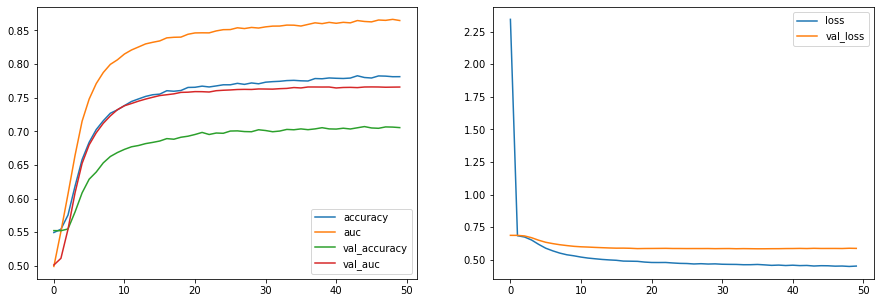

In [ ]:
plot_loss_and_metric_values(ncf_history,50,25)

In [ ]:
save_model_and_history_to(ncf_model,ncf_history,"Nerual_CF")

#### Change the hidden vector dimension

In [ ]:
# change the dimension of hidden vecotor to 64
hidden_vector_dim=64
movieId_mf_64=tf.feature_column.embedding_column(movie_id_one_hot,hidden_vector_dim)
userId_mf_64=tf.feature_column.embedding_column(user_id_one_hot,hidden_vector_dim)

In [ ]:
ncf_model_64=NerualCF([movieId_mlp],[userId_mlp],[movieId_mf_64],[userId_mf_64],[10,10],0.8,regularizers.l2(1.2))

ncf_model_64.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy",tf.keras.metrics.AUC(curve='ROC')])

In [ ]:
ncf_history_64=ncf_model_64.fit(train_dataset,epochs=50,validation_data=valid_dataset)

Epoch 1/50
2349/2349 [==============================] - 8s 3ms/step - loss: 6.6046 - accuracy: 0.5470 - auc_26: 0.5025 - val_loss: 0.6876 - val_accuracy: 0.5525 - val_auc_26: 0.5069
Epoch 2/50
2349/2349 [==============================] - 6s 3ms/step - loss: 0.6850 - accuracy: 0.5546 - auc_26: 0.5516 - val_loss: 0.6870 - val_accuracy: 0.5525 - val_auc_26: 0.5242
Epoch 3/50
2349/2349 [==============================] - 6s 3ms/step - loss: 0.6768 - accuracy: 0.5700 - auc_26: 0.6065 - val_loss: 0.6809 - val_accuracy: 0.5549 - val_auc_26: 0.5830
Epoch 4/50
2349/2349 [==============================] - 6s 3ms/step - loss: 0.6540 - accuracy: 0.6150 - auc_26: 0.6664 - val_loss: 0.6624 - val_accuracy: 0.5964 - val_auc_26: 0.6470
Epoch 5/50
2349/2349 [==============================] - 6s 3ms/step - loss: 0.6169 - accuracy: 0.6594 - auc_26: 0.7206 - val_loss: 0.6394 - val_accuracy: 0.6296 - val_auc_26: 0.6855
Epoch 6/50
2349/2349 [==============================] - 6s 3ms/step - loss: 0.5824 - accur

In [ ]:
#output the model evaluation
ncf64_loss,ncf64_acc,ncf64_auc=ncf_model_64.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (ncf64_acc,ncf64_auc))

653/653 [==============================] - 1s 2ms/step - loss: 0.5701 - accuracy: 0.7116 - auc_26: 0.7772
The evaluation of this model shows the accuracy of this model is 0.712, auc of roc curve is 0.777.


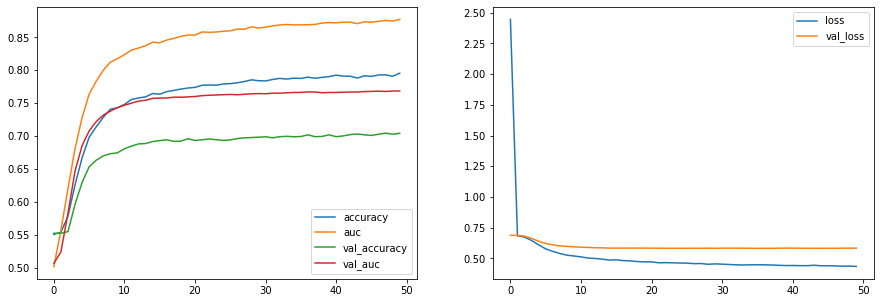

In [ ]:
plot_loss_and_metric_values(ncf_history_64,50,26)

In [ ]:
# change the dimension of hidden vecotor to 16
hidden_vector_dim=16
movieId_mf=tf.feature_column.embedding_column(movie_id_one_hot,hidden_vector_dim)
userId_mf=tf.feature_column.embedding_column(user_id_one_hot,hidden_vector_dim)

In [ ]:
ncf_model_16=NerualCF([movieId_mlp],[userId_mlp],[movieId_mf],[userId_mf],[10,10],0.7,regularizers.l2(1))

ncf_model_16.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy",tf.keras.metrics.AUC(curve='ROC')])

In [ ]:
ncf_history_16=ncf_model_16.fit(train_dataset,epochs=50,validation_data=valid_dataset)

Epoch 1/50
2349/2349 [==============================] - 7s 2ms/step - loss: 5.7757 - accuracy: 0.5400 - auc_27: 0.4979 - val_loss: 0.6878 - val_accuracy: 0.5525 - val_auc_27: 0.5000
Epoch 2/50
2349/2349 [==============================] - 5s 2ms/step - loss: 0.6865 - accuracy: 0.5539 - auc_27: 0.5229 - val_loss: 0.6878 - val_accuracy: 0.5525 - val_auc_27: 0.5033
Epoch 3/50
2349/2349 [==============================] - 5s 2ms/step - loss: 0.6846 - accuracy: 0.5561 - auc_27: 0.5440 - val_loss: 0.6874 - val_accuracy: 0.5527 - val_auc_27: 0.5126
Epoch 4/50
2349/2349 [==============================] - 5s 2ms/step - loss: 0.6782 - accuracy: 0.5697 - auc_27: 0.5833 - val_loss: 0.6853 - val_accuracy: 0.5599 - val_auc_27: 0.5362
Epoch 5/50
2349/2349 [==============================] - 5s 2ms/step - loss: 0.6683 - accuracy: 0.5873 - auc_27: 0.6092 - val_loss: 0.6792 - val_accuracy: 0.5716 - val_auc_27: 0.5701
Epoch 6/50
2349/2349 [==============================] - 5s 2ms/step - loss: 0.6538 - accur

In [ ]:
#output the model evaluation
ncf16_loss,ncf16_acc,ncf16_auc=ncf_model_16.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (ncf16_acc,ncf16_auc))

653/653 [==============================] - 1s 2ms/step - loss: 0.5666 - accuracy: 0.7068 - auc_27: 0.7733
The evaluation of this model shows the accuracy of this model is 0.707, auc of roc curve is 0.773.


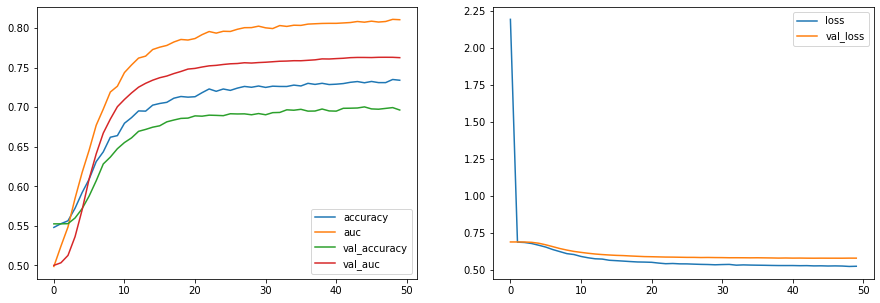

In [ ]:
plot_loss_and_metric_values(ncf_history_16,50,27)

From above we could see that the performance of model became best in 64 of hidden vector,  then we choose Nerual_CF with 64 hidden vector number to save

In [ ]:
save_model_and_history_to(ncf_model_64,ncf_history,"Nerual_CF")

## Wide & Deep

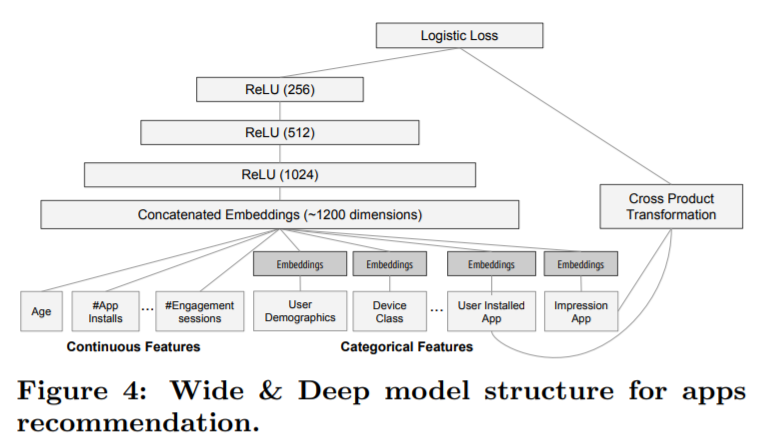

* this model is combine by deep model and wide model
    * deep model is Embedding + MLP 
    * wide is the crossing between **movie id user already saw** and the **movie id user tend to see** 

In [ ]:
def Wide_And_Deep(dropout=0.2,regularizer=None):
    
    # define input for keras model
    inputs = {
        ## numerical input layers
        'userHistoryMeanRating': tf.keras.layers.Input(name='userHistoryMeanRating', shape=(), dtype='float32'),
        'userHistoryStdRating': tf.keras.layers.Input(name='userHistoryStdRating', shape=(), dtype='float32'),
        'userRatingGoodMovieAveReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieAveReleasedYear', shape=(), dtype='int32'),
        'userRatingGoodMovieStdReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieStdReleasedYear', shape=(), dtype='float32'),
        'year': tf.keras.layers.Input(name='year', shape=(), dtype='int32'),
        'movieMeanRating': tf.keras.layers.Input(name='movieMeanRating', shape=(), dtype='float32'),
        'movieStd': tf.keras.layers.Input(name='movieStd', shape=(), dtype='float32'),

        'ratingCount': tf.keras.layers.Input(name='ratingCount', shape=(), dtype='int32'),
        'age': tf.keras.layers.Input(name='age', shape=(), dtype='int32'),
        'userHistoryRatingCount': tf.keras.layers.Input(name='userHistoryRatingCount', shape=(), dtype='int32'),

        ## categorical input layers
        'movie_id': tf.keras.layers.Input(name='movie_id', shape=(), dtype='int32'),
        'user_id': tf.keras.layers.Input(name='user_id', shape=(), dtype='int32'),
        'gender': tf.keras.layers.Input(name='gender', shape=(), dtype='string'),
        
        
        'userLiked_movie_genre_1': tf.keras.layers.Input(name='userLiked_movie_genre_1', shape=(), dtype='string'),
        'userLiked_movie_genre_2': tf.keras.layers.Input(name='userLiked_movie_genre_2', shape=(), dtype='string'),
        'userLiked_movie_genre_3': tf.keras.layers.Input(name='userLiked_movie_genre_3', shape=(), dtype='string'),
        'userLiked_movie_genre_4': tf.keras.layers.Input(name='userLiked_movie_genre_4', shape=(), dtype='string'),
        'userLiked_movie_genre_5': tf.keras.layers.Input(name='userLiked_movie_genre_5', shape=(), dtype='string'),
        'movieGenre1': tf.keras.layers.Input(name='movieGenre1', shape=(), dtype='string'),
        'movieGenre2': tf.keras.layers.Input(name='movieGenre2', shape=(), dtype='string'),
        'movieGenre3': tf.keras.layers.Input(name='movieGenre3', shape=(), dtype='string'),
        'movieGenre4': tf.keras.layers.Input(name='movieGenre4', shape=(), dtype='string'),
        'movieGenre5': tf.keras.layers.Input(name='movieGenre5', shape=(), dtype='string'),
        'movieGenre6': tf.keras.layers.Input(name='movieGenre6', shape=(), dtype='string'),
        'userLikedTop5_movie_id_1': tf.keras.layers.Input(name='userLikedTop5_movie_id_1', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_2': tf.keras.layers.Input(name='userLikedTop5_movie_id_2', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_3': tf.keras.layers.Input(name='userLikedTop5_movie_id_3', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_4': tf.keras.layers.Input(name='userLikedTop5_movie_id_4', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_5': tf.keras.layers.Input(name='userLikedTop5_movie_id_5', shape=(), dtype='int32'),
        'zip_code': tf.keras.layers.Input(name='zip_code', shape=(), dtype='string'),
        'occupation': tf.keras.layers.Input(name='occupation', shape=(), dtype='string'),
    }
    
    ## deep model
    ### we directly use the base model 
    deep_input_layer=layers.DenseFeatures(numerical_cols + categorical_cols)(inputs)
    deep_layer1=layers.Dense(64,activation="relu",kernel_regularizer=regularizer)(deep_input_layer)
    
    deep_dropout1=layers.Dropout(dropout)(deep_layer1)
    deep_layer2=layers.Dense(64,activation="relu",kernel_regularizer=regularizer)(deep_dropout1)
    deep_dropout2=layers.Dropout(dropout)(deep_layer2)
    
    ## wide model
    ## this is the movie user will see and rate
    movie_id_will_see=movie_id_one_hot
    ## this is the movie user already saw and thought it is good.
    movie_id_saw=tf.feature_column.categorical_column_with_identity(key="userLikedTop5_movie_id_1",num_buckets=1683)
    ## calculate the cross products 
    cross_feature=tf.feature_column.crossed_column([movie_id_will_see,movie_id_saw],10000) 
    cross_feature=tf.feature_column.indicator_column(cross_feature)
    
    wide_layer=layers.DenseFeatures(cross_feature)(inputs)
    
    
    #concatenate both layers as one and output
    concate_layer=layers.concatenate([deep_dropout2,wide_layer])
    
    output_layer=layers.Dense(1,activation="sigmoid")(concate_layer)
    
    model=keras.Model(inputs,output_layer)
    return model


In [ ]:
wide_and_deep_model=Wide_And_Deep(0.2,regularizers.l2(0.08))
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

wide_and_deep_model.compile(loss="binary_crossentropy",
                           optimizer=optimizer,
                           metrics=["accuracy",tf.keras.metrics.AUC(curve="ROC")])

In [ ]:
wd_hitory=wide_and_deep_model.fit(train_dataset,epochs=20,validation_data=valid_dataset,callbacks=[es])

Epoch 1/20
2349/2349 [==============================] - 21s 7ms/step - loss: 6.8396 - accuracy: 0.5604 - auc_28: 0.5863 - val_loss: 0.7692 - val_accuracy: 0.5525 - val_auc_28: 0.7181
Epoch 2/20
2349/2349 [==============================] - 13s 5ms/step - loss: 0.7158 - accuracy: 0.5582 - auc_28: 0.7093 - val_loss: 0.6743 - val_accuracy: 0.6554 - val_auc_28: 0.7427
Epoch 3/20
2349/2349 [==============================] - 13s 5ms/step - loss: 0.6611 - accuracy: 0.6791 - auc_28: 0.7524 - val_loss: 0.6453 - val_accuracy: 0.6927 - val_auc_28: 0.7524
Epoch 4/20
2349/2349 [==============================] - 13s 5ms/step - loss: 0.6373 - accuracy: 0.6979 - auc_28: 0.7604 - val_loss: 0.6336 - val_accuracy: 0.6950 - val_auc_28: 0.7558
Epoch 5/20
2349/2349 [==============================] - 13s 6ms/step - loss: 0.6253 - accuracy: 0.7026 - auc_28: 0.7658 - val_loss: 0.6264 - val_accuracy: 0.6996 - val_auc_28: 0.7583
Epoch 6/20
2349/2349 [==============================] - 13s 6ms/step - loss: 0.6169 -

In [ ]:
#output the model evaluation
wad_loss,wad_acc,wad_auc=wide_and_deep_model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (wad_acc,wad_auc))

653/653 [==============================] - 2s 4ms/step - loss: 0.5885 - accuracy: 0.7121 - auc_28: 0.7790
The evaluation of this model shows the accuracy of this model is 0.712, auc of roc curve is 0.779.


In [ ]:
wd_hitory.history['auc_28']

[0.6002099514007568,
 0.7151466608047485,
 0.7530691027641296,
 0.7614419460296631,
 0.7661885023117065,
 0.7708849906921387,
 0.7741521596908569,
 0.7792275547981262,
 0.7827246189117432,
 0.7852606773376465,
 0.7884703874588013,
 0.7910406589508057,
 0.7942707538604736,
 0.7972160577774048,
 0.7993441224098206,
 0.8008918762207031,
 0.8034891486167908,
 0.8052951097488403,
 0.8075615763664246,
 0.8094530701637268]

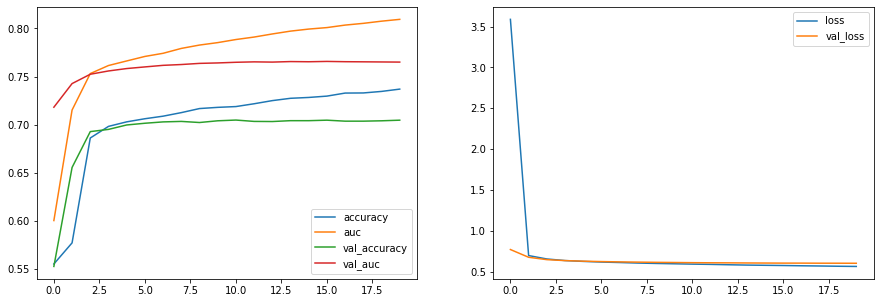

In [ ]:
plot_loss_and_metric_values(wd_hitory,20,28)

### save wide&deep model

In [ ]:
save_model_and_history_to(wide_and_deep_model,wd_hitory,"Wide_and_deep")

## AFM

AFM is the Factorization Machine with attention layer. It is combined by 
* Embedding layer,
* pair-wise interaction layer,
* Attention-based pooling,
* output layer. 

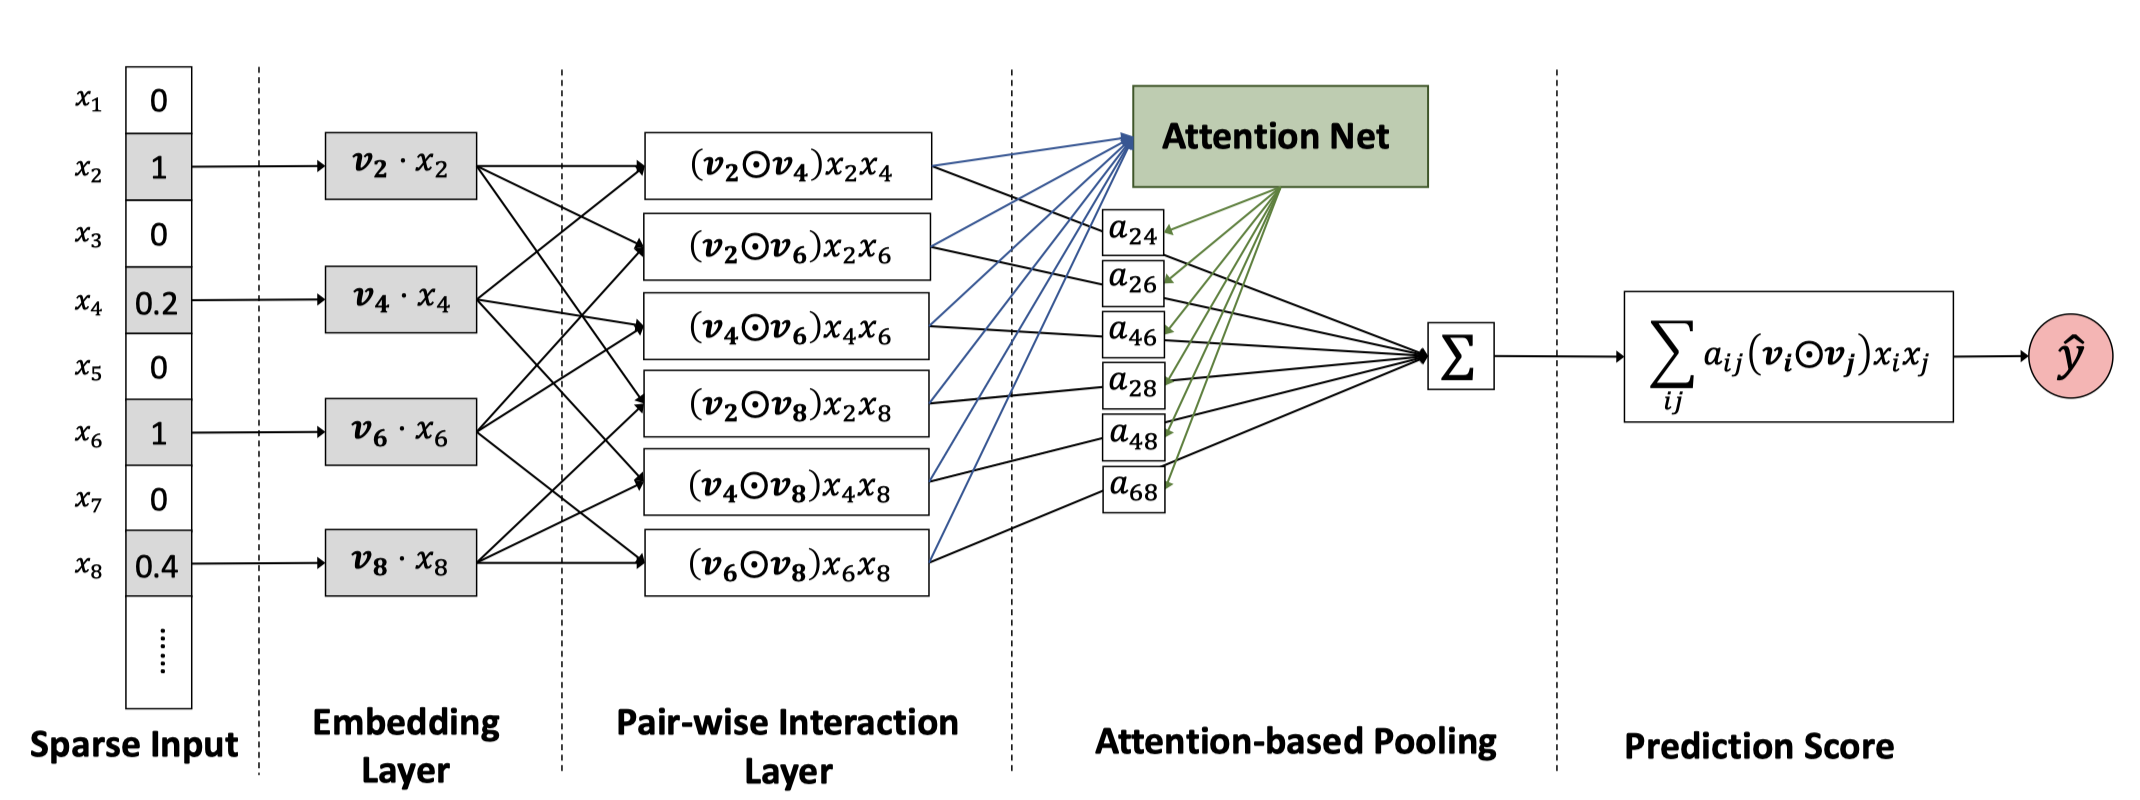

In [ ]:
import itertools

def AFM():
    #AFM only use sparce features to do the pair-wise interation and attention, In this case numerical features and gender(only two dim)
    # is not needed in this model, then we could eliminate then 
    
    # define input for AFM about sparce features
    inputs = {
        ## categorical input layers
        'movie_id': tf.keras.layers.Input(name='movie_id', shape=(), dtype='int32'),
        'user_id': tf.keras.layers.Input(name='user_id', shape=(), dtype='int32'),
        
        
        'userLiked_movie_genre_1': tf.keras.layers.Input(name='userLiked_movie_genre_1', shape=(), dtype='string'),
        'userLiked_movie_genre_2': tf.keras.layers.Input(name='userLiked_movie_genre_2', shape=(), dtype='string'),
        'userLiked_movie_genre_3': tf.keras.layers.Input(name='userLiked_movie_genre_3', shape=(), dtype='string'),
        'userLiked_movie_genre_4': tf.keras.layers.Input(name='userLiked_movie_genre_4', shape=(), dtype='string'),
        'userLiked_movie_genre_5': tf.keras.layers.Input(name='userLiked_movie_genre_5', shape=(), dtype='string'),
        'movieGenre1': tf.keras.layers.Input(name='movieGenre1', shape=(), dtype='string'),
        'movieGenre2': tf.keras.layers.Input(name='movieGenre2', shape=(), dtype='string'),
        'movieGenre3': tf.keras.layers.Input(name='movieGenre3', shape=(), dtype='string'),
        'movieGenre4': tf.keras.layers.Input(name='movieGenre4', shape=(), dtype='string'),
        'movieGenre5': tf.keras.layers.Input(name='movieGenre5', shape=(), dtype='string'),
        'movieGenre6': tf.keras.layers.Input(name='movieGenre6', shape=(), dtype='string'),
        'userLikedTop5_movie_id_1': tf.keras.layers.Input(name='userLikedTop5_movie_id_1', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_2': tf.keras.layers.Input(name='userLikedTop5_movie_id_2', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_3': tf.keras.layers.Input(name='userLikedTop5_movie_id_3', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_4': tf.keras.layers.Input(name='userLikedTop5_movie_id_4', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_5': tf.keras.layers.Input(name='userLikedTop5_movie_id_5', shape=(), dtype='int32'),
        'zip_code': tf.keras.layers.Input(name='zip_code', shape=(), dtype='string'),
        'occupation': tf.keras.layers.Input(name='occupation', shape=(), dtype='string'),
    }
    
    embedding_all=[] # allocate all the embbeing layers.    

    # movie_id_embeding
    movid_one_hot=tf.feature_column.categorical_column_with_identity(key="movie_id",num_buckets=1683)
    movie_embedding_layer=tf.feature_column.embedding_column(movid_one_hot,10) #(None,10)
    # user_id_embedding
    userid_one_hot=tf.feature_column.categorical_column_with_identity(key="user_id",num_buckets=944)
    userid_embedding_layer=tf.feature_column.embedding_column(userid_one_hot,10) #embedding layer dim,(None,10)

    embedding_all.append(movie_embedding_layer)
    embedding_all.append(userid_embedding_layer)

    for key, vocab in ALL_FEATURES.items():
        col=tf.feature_column.categorical_column_with_vocabulary_list(key=key,vocabulary_list=vocab)
        embedding_sparce_layer=tf.feature_column.embedding_column(col,10)
        embedding_all.append(embedding_sparce_layer)

    embedding_layers=layers.DenseFeatures(embedding_all)(inputs) ## dim (None.10*20)
    
    #reshape the embedding_lauers
    embedding_layers=tf.reshape(embedding_layers,(-1,10,20)) # dim(None, 10,20)
    embedding_layers=layers.Permute((2,1))(embedding_layers) # change the dimension to dim(None,20,10)
    
    #pair-wise layer, there are 20 embedding layers, we will multiply each of two in 20 embedding layers.
    row=[]
    col=[]
    for x,y in itertools.combinations(range(len(embedding_all)),2):
        # this is to gather the index of these two pair,
        # for example: [1,2,3], there are [1,2],[1,3],[2,3], then row is[1,1,2] and col is [2,3,3]

        row.append(x)    # beacuse the embeding layer list is 20 ,then row length should be 20*19/2=190
        col.append(y)    #col length is the same ,length should be 190

    ## 得到所有特征组合    
    pair_wise_1=tf.gather(embedding_layers,row,axis=1) #extract layers of the corresponding row index
    pair_wise_2=tf.gather(embedding_layers,col,axis=1) #extract layers of the corresponding col index

    pair_wise_layer=layers.Multiply()([pair_wise_1,pair_wise_2]) #(element_wise_product) dim (None,len(embed)*(len(embed)-1)/2,10)
    
    # attention layer 
    def Attention(pair_wise_layer):
        attention_output=layers.Dense(10,activation='relu',use_bias=True)(pair_wise_layer) #dim(None,190,10)
        attention_output=layers.Dense(1)(attention_output) #dim(None,190,1)
        #softmax in the 190 dimension
        attention_output=layers.Softmax(axis=1)(attention_output) #dim(None,190,1)
        
        #element-wise product with pair-wise-layer and attention-output layer
        attention_output=layers.Multiply()([pair_wise_layer,attention_output]) #dim(None,190,10)
        
        attention_output=tf.reduce_sum(attention_output,axis=1) #add the 190 element together and reduce the dimention (None,10)
        return attention_output
    attention_output_layer=Attention(pair_wise_layer) # dim(None,10)
        
    outputs=layers.Dense(1,activation="sigmoid")(attention_output_layer)
    
    medel=keras.Model(inputs=inputs,outputs=outputs)
        
    return medel

In [ ]:
afm_model=AFM()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
afm_model.compile(loss="binary_crossentropy",
                           optimizer=optimizer,
                           metrics=["accuracy",tf.keras.metrics.AUC(curve="ROC")])

In [ ]:
afm_history=afm_model.fit(train_dataset,epochs=30,validation_data=valid_dataset,callbacks=[es])

Epoch 1/30


C:\Users\Warden\Anaconda3\envs\DeepLearning\lib\site-packages\tensorflow\python\keras\engine\functional.py:592: UserWarning: Input dict contained keys ['userHistoryRatingCount', 'userHistoryMeanRating', 'userHistoryStdRating', 'userRatingGoodMovieAveReleasedYear', 'userRatingGoodMovieStdReleasedYear', 'year', 'movieMeanRating', 'movieStd', 'ratingCount', 'age', 'gender', 'User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


2349/2349 [==============================] - 16s 5ms/step - loss: 0.6916 - accuracy: 0.5489 - auc_29: 0.5045 - val_loss: 0.6887 - val_accuracy: 0.5525 - val_auc_29: 0.5292
Epoch 2/30
2349/2349 [==============================] - 10s 4ms/step - loss: 0.6879 - accuracy: 0.5541 - auc_29: 0.5358 - val_loss: 0.6868 - val_accuracy: 0.5525 - val_auc_29: 0.5637
Epoch 3/30
2349/2349 [==============================] - 10s 4ms/step - loss: 0.6858 - accuracy: 0.5541 - auc_29: 0.5891 - val_loss: 0.6850 - val_accuracy: 0.5525 - val_auc_29: 0.6086
Epoch 4/30
2349/2349 [==============================] - 10s 4ms/step - loss: 0.6834 - accuracy: 0.5541 - auc_29: 0.6375 - val_loss: 0.6820 - val_accuracy: 0.5525 - val_auc_29: 0.6403
Epoch 5/30
2349/2349 [==============================] - 10s 4ms/step - loss: 0.6792 - accuracy: 0.5544 - auc_29: 0.6736 - val_loss: 0.6767 - val_accuracy: 0.5573 - val_auc_29: 0.6621
Epoch 6/30
2349/2349 [==============================] - 10s 4ms/step - loss: 0.6721 - accuracy: 

In [ ]:
#output the model evaluation

afm_loss,afm_acc,afm_auc=afm_model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (afm_acc,afm_auc))

653/653 [==============================] - 2s 2ms/step - loss: 0.6103 - accuracy: 0.6732 - auc_29: 0.7242
The evaluation of this model shows the accuracy of this model is 0.673, auc of roc curve is 0.724.


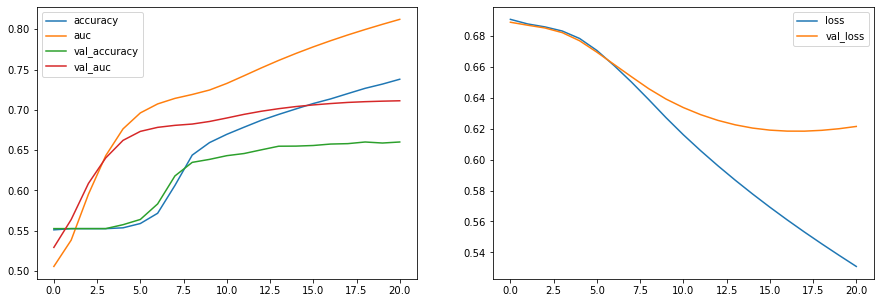

In [ ]:
plot_loss_and_metric_values(afm_history,21,29)

#### save model

In [ ]:
save_model_and_history_to(afm_model,afm_history,"AFM")

## DIN
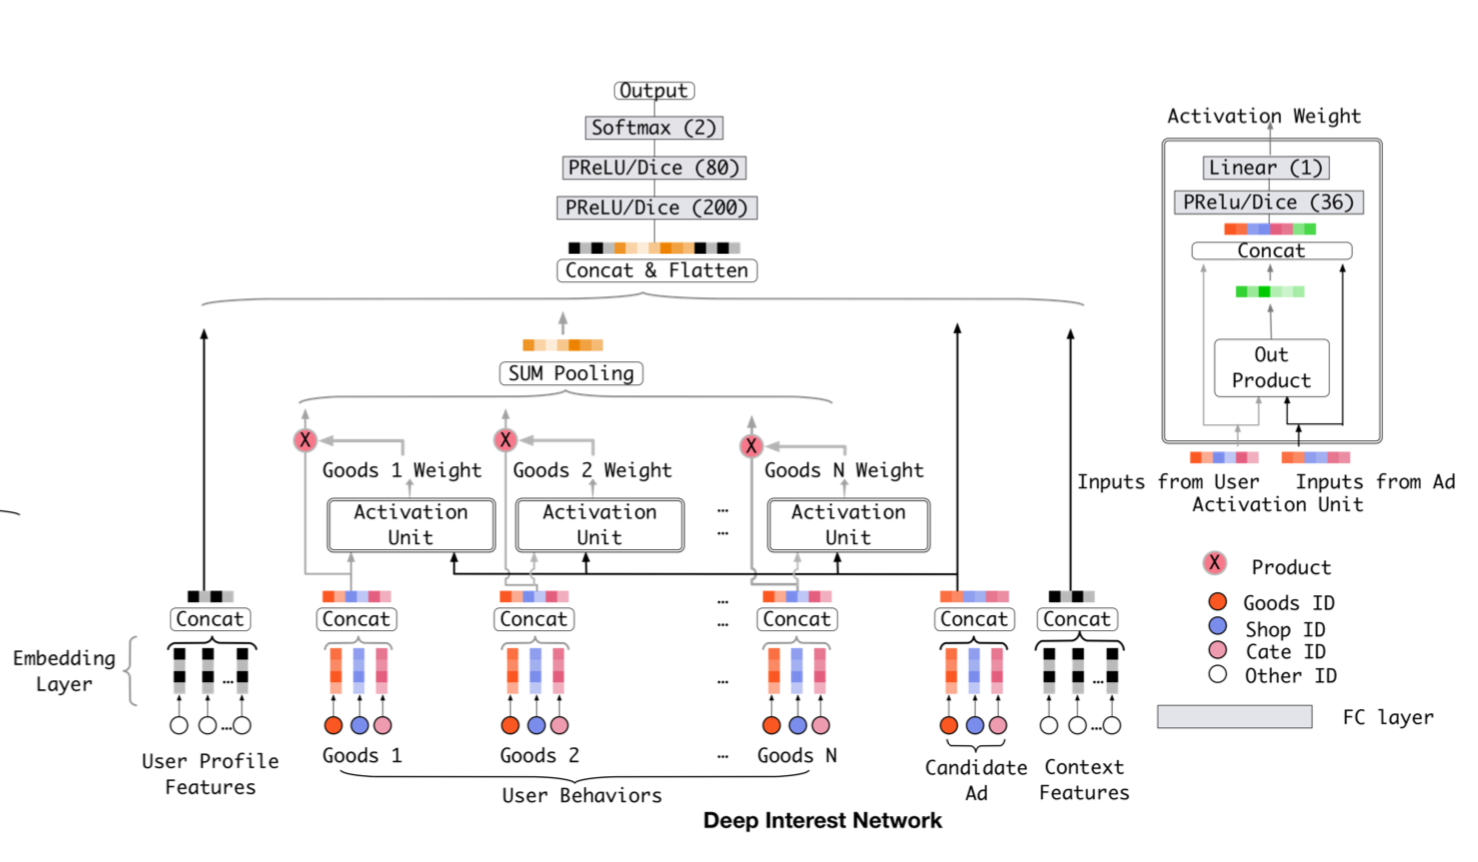

DIN is the short of Deep Interest Network, this model use attention between user behaviour and candidate product to find whether user will be interested in the candidate one. Model contains:
* Input Embedding layers( user features,user behaviours(here is the 5 recent movie user rated and liked, top 5 user liked movie ids), candidate product (movie id),and context features(movie features)
* An attention layer between candidate movie and user behaviours
* sum pooling about the output of attention layer to let the length of all user same
* concatanate layer of user features, attention output, candidate product and contest features
* MLP with PRelu as activation function

In [131]:
def Deep_Interest_Network():
    
    def Attention(user_behaviour_embedding,candidate_embedding):
        # here implement the attention layers,with human behaviours(which is the movie id list) and the candidate movie id
        candidate_repeat_layer=layers.RepeatVector(10)(candidate_embedding) #dim(None,10,10) match with user behaviour for operation
        
        sub_layer=layers.Subtract()([user_behaviour_embedding,candidate_repeat_layer])
        mlutiply_layer=layers.Multiply()([user_behaviour_embedding,candidate_repeat_layer])
        
        #combine them together [k,q,k-q,q*k], the function that the paper use.
        concat_layer=layers.concatenate([user_behaviour_embedding,candidate_repeat_layer,sub_layer,mlutiply_layer])# dim(None,10,10+10+10+10)
        
        #use MLP to output 
        output_layer=layers.Dense(16)(concat_layer)#dim (None,10,16)
        output_layer=layers.PReLU()(output_layer)
        output_layer=layers.Dense(1,activation='sigmoid')(output_layer)#dim (None,10,1)
        
            
        output_layer = tf.keras.layers.Flatten()(output_layer) #dim(None,10) attention number for the 10 lengther user behaviour layer
        output_layer = tf.keras.layers.RepeatVector(10)(output_layer)#dim(None,10(layer number),10(attention number)) 
        output_layer = tf.keras.layers.Permute((2, 1))(output_layer)#change attention dim and layer dim, dim(None,10(attention number),10) 
        output_layer = tf.keras.layers.Multiply()([user_behaviour_embedding, output_layer]) #dim(None,10,10), 
                                                                                            # attention number multiply
                                                                                            # with each user behaviour in the dim 1, 
    
        return output_layer
    
    
    # define input for keras model
    inputs = {
        ## numerical input layers
        'userHistoryMeanRating': tf.keras.layers.Input(name='userHistoryMeanRating', shape=(), dtype='float32'),
        'userHistoryStdRating': tf.keras.layers.Input(name='userHistoryStdRating', shape=(), dtype='float32'),
        'userRatingGoodMovieAveReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieAveReleasedYear', shape=(), dtype='int32'),
        'userRatingGoodMovieStdReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieStdReleasedYear', shape=(), dtype='float32'),
        'year': tf.keras.layers.Input(name='year', shape=(), dtype='int32'),
        'movieMeanRating': tf.keras.layers.Input(name='movieMeanRating', shape=(), dtype='float32'),
        'movieStd': tf.keras.layers.Input(name='movieStd', shape=(), dtype='float32'),

        'ratingCount': tf.keras.layers.Input(name='ratingCount', shape=(), dtype='int32'),
        'age': tf.keras.layers.Input(name='age', shape=(), dtype='int32'),
        'userHistoryRatingCount': tf.keras.layers.Input(name='userHistoryRatingCount', shape=(), dtype='int32'),

        ## categorical input layers
        'movie_id': tf.keras.layers.Input(name='movie_id', shape=(), dtype='int32'),
        'user_id': tf.keras.layers.Input(name='user_id', shape=(), dtype='int32'),
        'gender': tf.keras.layers.Input(name='gender', shape=(), dtype='string'),
        
        'User_recent_rated_and_liked_movie_id_1': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_1', shape=(), dtype='int32'),
        'User_recent_rated_and_liked_movie_id_2': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_2', shape=(), dtype='int32'),
        'User_recent_rated_and_liked_movie_id_3': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_3', shape=(), dtype='int32'),
        'User_recent_rated_and_liked_movie_id_4': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_4', shape=(), dtype='int32'),
        'User_recent_rated_and_liked_movie_id_5': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_5', shape=(), dtype='int32'),
        
        
        'userLiked_movie_genre_1': tf.keras.layers.Input(name='userLiked_movie_genre_1', shape=(), dtype='string'),
        'userLiked_movie_genre_2': tf.keras.layers.Input(name='userLiked_movie_genre_2', shape=(), dtype='string'),
        'userLiked_movie_genre_3': tf.keras.layers.Input(name='userLiked_movie_genre_3', shape=(), dtype='string'),
        'userLiked_movie_genre_4': tf.keras.layers.Input(name='userLiked_movie_genre_4', shape=(), dtype='string'),
        'userLiked_movie_genre_5': tf.keras.layers.Input(name='userLiked_movie_genre_5', shape=(), dtype='string'),
        'movieGenre1': tf.keras.layers.Input(name='movieGenre1', shape=(), dtype='string'),
        'movieGenre2': tf.keras.layers.Input(name='movieGenre2', shape=(), dtype='string'),
        'movieGenre3': tf.keras.layers.Input(name='movieGenre3', shape=(), dtype='string'),
        'movieGenre4': tf.keras.layers.Input(name='movieGenre4', shape=(), dtype='string'),
        'movieGenre5': tf.keras.layers.Input(name='movieGenre5', shape=(), dtype='string'),
        'movieGenre6': tf.keras.layers.Input(name='movieGenre6', shape=(), dtype='string'),
        'userLikedTop5_movie_id_1': tf.keras.layers.Input(name='userLikedTop5_movie_id_1', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_2': tf.keras.layers.Input(name='userLikedTop5_movie_id_2', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_3': tf.keras.layers.Input(name='userLikedTop5_movie_id_3', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_4': tf.keras.layers.Input(name='userLikedTop5_movie_id_4', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_5': tf.keras.layers.Input(name='userLikedTop5_movie_id_5', shape=(), dtype='int32'),
        'zip_code': tf.keras.layers.Input(name='zip_code', shape=(), dtype='string'),
        'occupation': tf.keras.layers.Input(name='occupation', shape=(), dtype='string'),
    }
    
    # initialized 3 base input list,other base ipnut user-behaviour will be carried out next
    user_features=[]
    product_features=[] # the movie features
    candidate_embed=[]  # the movie user will rate
    
    # add the movie_id embedding into candidate_embed list
    movie_id_one_hot=tf.feature_column.categorical_column_with_identity(key="movie_id",num_buckets=1683)
    movieId=tf.feature_column.embedding_column(movie_id_one_hot,10)
    candidate_embed.append(movieId)
    
    # add the user_id embedding into user_feature list
    user_id_one_hot=tf.feature_column.categorical_column_with_identity(key="user_id",num_buckets=944)
    userId=tf.feature_column.embedding_column(user_id_one_hot,10)
    user_features.append(userId)
    
    
    
    Zip_code=final_samples["zip_code"].unique().tolist()
    User_profiles_categorical={ 
         'userLiked_movie_genre_1': movie_types, 
          'userLiked_movie_genre_2': movie_types, 
          'userLiked_movie_genre_3': movie_types, 
          'userLiked_movie_genre_4': movie_types, 
          'userLiked_movie_genre_5': movie_types, 
          "zip_code": Zip_code,
          "occupation":Occupation}
    
    
    context_features_categorical={
         'movieGenre1': movie_types,
          'movieGenre2': movie_types, 
          'movieGenre3': movie_types, 
          'movieGenre4': movie_types, 
          'movieGenre5': movie_types, 
          'movieGenre6': movie_types, 
    }
    
    
    
    #add user categorical features into user_features
    for features,vocab in User_profiles_categorical.items():
        col=tf.feature_column.categorical_column_with_vocabulary_list(key=features,vocabulary_list=vocab )
        cat_embedding=tf.feature_column.embedding_column(col,10)
        user_features.append(cat_embedding)
        
    #add movie categorical features into product_features
    for features,vocab in context_features_categorical.items():
        col=tf.feature_column.categorical_column_with_vocabulary_list(key=features,vocabulary_list=vocab )
        cat_embedding=tf.feature_column.embedding_column(col,10)
        product_features.append(cat_embedding)
    
    #get all the user features including categorical and numerical features
    
    user_numerical_features=[
        'userRatingGoodMovieAveReleasedYear',
        'userRatingGoodMovieStdReleasedYear',
        'userHistoryMeanRating',
        'userHistoryStdRating',
        "ratingCount",
        'age',
        'userHistoryRatingCount',
    ]
    for user_numerical_feature in user_numerical_features:
        user_features.append(tf.feature_column.numeric_column(user_numerical_feature))
    
    user_features.append(gender_indicator)# add gender features (dim=2<10, so don't need to embedding, we add it into features directly)
    
    
    #get all product features including categorical and numerical features 
    product_numerical_features=[
        'year',
        'movieMeanRating',
        'movieStd',
    ]
    for product_numerical_feature in product_numerical_features:
        user_features.append(tf.feature_column.numeric_column(product_numerical_feature))
    
    #user behaviours, the movie ids that user recently rated and liked, and the movie ids user best liked
    user_behaviours=[
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_1", default_value=0),
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_2", default_value=0),
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_3", default_value=0),
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_4", default_value=0),
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_5", default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_1", default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_2", default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_3", default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_4", default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_5", default_value=0),  
    ]
    #base layer:
    user_behaviours_embed=layers.DenseFeatures(user_behaviours)(inputs) # dim(None,10) here 10 is the length of user behaviours
    
    #embedding layer
    context_embeding_layer=layers.DenseFeatures(product_features)(inputs) # dim(None,6*10) there 6 embedding layere with 10dim
    user_embeding_layer=layers.DenseFeatures(user_features)(inputs) #dim(None,92) there 9 embedding layere with 10dim  and 1 layer(gender) with 2 dim
    candidate_embeding_layer=layers.DenseFeatures(candidate_embed)(inputs) #dim(None,10)
    user_behaviour_embeding_layer=layers.Embedding(input_dim=1683,output_dim=10,mask_zero=True)(user_behaviours_embed)#mask zero #dim(None,10,embeding)
    
    #use attention
    attention_output_layer=Attention(user_behaviour_embeding_layer,candidate_embeding_layer) #dim(None.10,10)
    
    #sum pooling/ element sum in the 1 dimension and reduce dimension, this aimed to let the length of different user behaviour to be total equal.
    user_behaviors_pooled_layers = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(attention_output_layer)# dim(None，10)
    
    #concatence layer
    all_concat=layers.concatenate([user_embeding_layer,user_behaviors_pooled_layers,context_embeding_layer,candidate_embeding_layer])
    
    #MLP layers
    output_layer=layers.Dense(64)(all_concat)#dim (None,64)
    output_layer=layers.PReLU()(output_layer)
    output_layer=layers.Dense(1,activation='sigmoid')(output_layer)#dim (None,1)
    
    model=keras.Model(inputs=inputs,outputs=output_layer)
    
    return model

In [132]:
din_model=Deep_Interest_Network()

In [133]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

din_model.compile(loss="binary_crossentropy",
                           optimizer=optimizer,
                           metrics=["accuracy",tf.keras.metrics.AUC(curve="ROC")])

In [134]:
din_history=din_model.fit(train_dataset,epochs=30,validation_data=valid_dataset,callbacks=[es])

Epoch 1/30
2349/2349 [==============================] - 14s 4ms/step - loss: 0.6096 - accuracy: 0.6757 - auc_25: 0.7276 - val_loss: 0.5765 - val_accuracy: 0.7008 - val_auc_25: 0.7596
Epoch 2/30
2349/2349 [==============================] - 8s 3ms/step - loss: 0.5652 - accuracy: 0.7075 - auc_25: 0.7710 - val_loss: 0.5702 - val_accuracy: 0.7050 - val_auc_25: 0.7664
Epoch 3/30
2349/2349 [==============================] - 8s 3ms/step - loss: 0.5541 - accuracy: 0.7159 - auc_25: 0.7820 - val_loss: 0.5686 - val_accuracy: 0.7040 - val_auc_25: 0.7685
Epoch 4/30
2349/2349 [==============================] - 8s 3ms/step - loss: 0.5470 - accuracy: 0.7225 - auc_25: 0.7888 - val_loss: 0.5680 - val_accuracy: 0.7066 - val_auc_25: 0.7694
Epoch 5/30
2349/2349 [==============================] - 8s 3ms/step - loss: 0.5420 - accuracy: 0.7252 - auc_25: 0.7936 - val_loss: 0.5674 - val_accuracy: 0.7060 - val_auc_25: 0.7703
Epoch 6/30
2349/2349 [==============================] - 8s 4ms/step - loss: 0.5378 - accu

In [135]:
#output the model evaluation
din_loss,din_acc,din_auc=din_model.evaluate(test_dataset)vbn
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (din_acc,din_auc))

SyntaxError: invalid syntax (<ipython-input-135-99a70df85b32>, line 2)

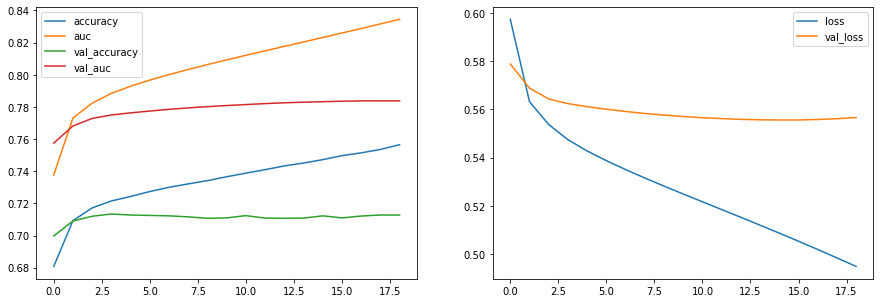

In [ ]:
plot_loss_and_metric_values(din_history,19,4)

### save model

In [ ]:
save_model_and_history_to(din_model,din_history,"Deep_Interst_Network")

## Model Analysis 

Above we implement 6 different classical models in Recommendation system with Deeplearning,The perdormance of each model shows bellow:

In [ ]:
#Reload_model
model_EMBED_MLP,history_EMBED_MLP=reload_model_and_history("EMBED_MLP",MyEMBED_MLP_Model,test_dataset)
#get the acc and auc
EMBED_MLP_loss,EMBED_MLP_acc,EMBED_MLP_auc=model_EMBED_MLP.evaluate(test_dataset)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
653/653 [==============================] - 11s 6ms/step - loss: 0.6964 - accuracy: 0.5199 - auc_61: 0.5105
Consider rewriting this model with the Functional API.


653/653 [==============================] - 5s 4ms/step - loss: 0.6745 - accuracy: 0.6863 - auc_61: 0.7439


In [ ]:
#Reload_model_deep_crossing
model_deep_crossing,history_deep_crossing=reload_model_and_history("Deep_Crossing",Deep_Crossing,test_dataset,dim_stack)
#get the acc and auc
dnc_loss,dnc_acc,dnc_auc=model_deep_crossing.evaluate(test_dataset)

Input dict contained keys ['User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5'] which did not match any model input. They will be ignored by the model.


653/653 [==============================] - 5s 4ms/step - loss: 0.5710 - accuracy: 0.7014 - auc_62: 0.7669


In [ ]:
#Reload_model_nerual_CF
model_Nerual_CF,history_Nerual_CF=reload_model_and_history("Nerual_CF",NerualCF,test_dataset,[movieId_mf_64,userId_mf_64,0.8,regularizers.l2(1.2)])
#get the acc and aucre
Nerual_CF_loss,Nerual_CF_acc,Nerual_CF_auc=model_Nerual_CF.evaluate(test_dataset)

653/653 [==============================] - 3s 3ms/step - loss: 0.5792 - accuracy: 0.7065 - auc_65: 0.7696


In [ ]:
#Reload_model_wide_and_deep
model_wad,history_wad=reload_model_and_history("Wide_and_deep",Wide_And_Deep,test_dataset,None)
#get the acc and aucre
wad_loss,wad_acc,wad_auc=model_wad.evaluate(test_dataset)

653/653 [==============================] - 6s 7ms/step - loss: 0.5619 - accuracy: 0.7080 - auc_66: 0.7751


In [ ]:
#Reload_model_DIN
model_din,history_din=reload_model_and_history("Deep_Interst_Network",Deep_Interest_Network,test_dataset,None)
#get the acc and aucre
din_loss,din_acc,din_auc=model_din.evaluate(test_dataset)

653/653 [==============================] - 13s 5ms/step - loss: 0.5623 - accuracy: 0.7094 - auc_69: 0.7790


In [ ]:
perform=pd.DataFrame(np.zeros((2,6)),index=['accuracy','AUC'],columns=["Base_Embedding_MLP","Deep&Crossing","Neural_CF","Wide&Deep","AFM","DIN"])

In [ ]:
perform["Base_Embedding_MLP"]=[EMBED_MLP_acc,EMBED_MLP_auc]
perform["Deep&Crossing"]=[dnc_acc,dnc_auc]
perform["Neural_CF"]=[Nerual_CF_acc,Nerual_CF_auc]
perform["Wide&Deep"]=[wad_acc,wad_auc]
perform["AFM"]=[afm_acc,afm_auc]
perform["DIN"]=[din_acc,din_auc]
perform.reset_index(inplace=True)
perform

index  Base_Embedding_MLP  Deep&Crossing  Neural_CF  Wide&Deep  \
0  accuracy            0.686303       0.701425   0.706535   0.707965   
1       AUC            0.743945       0.766894   0.769644   0.775110   

        AFM       DIN  
0  0.678690  0.709447  
1  0.731273  0.778979

In [ ]:
perform_melt=pd.melt(perform,id_vars=["index"])
perform_melt.columns=["metrics","Model","Value"]

(0, 0.9)

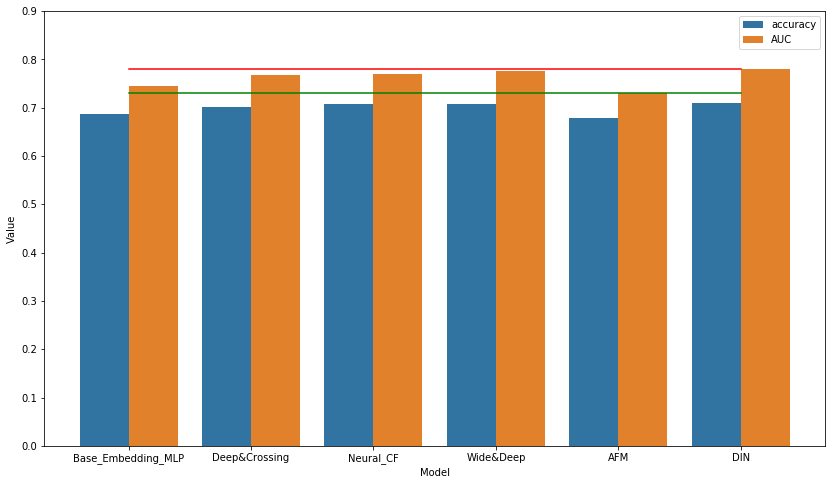

In [ ]:
plt.figure(figsize=(14,8))
sns.barplot(x="Model",y="Value",hue="metrics",data=perform_melt)
sns.lineplot(x=["Base_Embedding_MLP","Deep&Crossing","Neural_CF","Wide&Deep","AFM","DIN"],y=perform["DIN"][1],color="r")
sns.lineplot(x=["Base_Embedding_MLP","Deep&Crossing","Neural_CF","Wide&Deep","AFM","DIN"],y=perform["AFM"][1],color="green")
plt.ylim(0,0.9)

The performance of each model are shown above, we could see that the best model is DIN, its' AUC is 0.779, which is 6.5% larger than the AUC in worst model, which is AFM of 0.731. The Rank of the performance of these models are **DIN>Wide&Deep>Nerual_CF>Deep&Crossing>Base_Embedding_MLP>AFM**. Although the AFM use attention method, since it is actually an Factorization machine method, it did not get much more information about the features, so it is the worst

### ROC curve

In [ ]:
# from sklearn.metrics import roc_curve
# probas_base=model_EMBED_MLP.predict(test_dataset)
# probas_dc=model_deep_crossing.predict(test_dataset)
# probas_ncf=model_Nerual_CF.predict(test_dataset)
# probas_wad=model_wad.predict(test_dataset)
# probas_afm=afm_model.predict(test_dataset)
probas_din=model_din.predict(test_dataset)

In [ ]:
base_fpr, base_tpr, _ = roc_curve(y_test, probas_base)
dc_fpr, dc_tpr, _ = roc_curve(y_test, probas_dc)
ncf_fpr, ncf_tpr, _ = roc_curve(y_test, probas_ncf)
wad_fpr, wad_tpr, _ = roc_curve(y_test, probas_wad)
afm_fpr, afm_tpr, _ = roc_curve(y_test, probas_afm)
din_fpr, din_tpr, _ = roc_curve(y_test, probas_din)

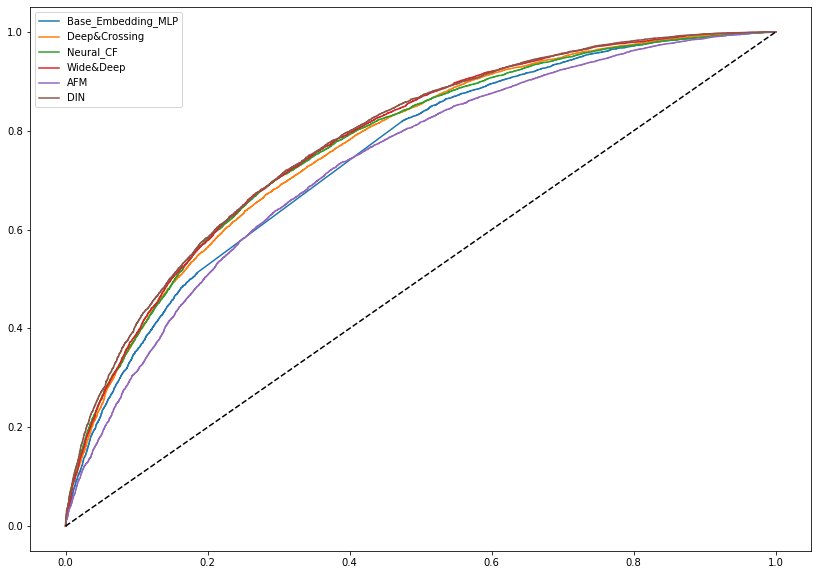

In [ ]:
# plot the roc curve for the model
plt.figure(figsize=(14,10))
plt.plot(base_fpr, base_tpr)
plt.plot(dc_fpr, dc_tpr)
plt.plot(ncf_fpr, ncf_tpr)
plt.plot(wad_fpr, wad_tpr)
plt.plot(afm_fpr, afm_tpr)
plt.plot(din_fpr, din_tpr)
plt.plot([0,1],[0,1],linestyle='--',color='black')
plt.legend(["Base_Embedding_MLP","Deep&Crossing","Neural_CF","Wide&Deep","AFM","DIN"])

The above shows the ROC curve, we could also see that AFM is whe worst model and base_embedding_MLP is the second worse model.

# Real life recommendation movies that were not seen by user

Here we will self-made a dataset for some user id with a list of the movie that he or she did not see before and use our recommendation model to recommend about 5 movies. The recommendation movie will be ranked as the prediction probablity by the models, more close to 1 the movie will more recommended.
____________________________________
For example, user 405 already saw 736 movies out of 1682 movies, however, she still didn't see the rest 946 movies, So we will build a dataset with user id=405 and movie id is the rest 946 movie ids, then we feed thos dataset into models to see the top 5 movies that model think user 405 will like. It is the simulation of the reality, which means this is no any label for us to validate the prediction. But made us really excited to do the real job.
* we will choose people in the top 10 rating means table.
* we wiil choose people in the least 10 rating means table also.

In [1015]:
movie_features_data=pd.read_csv("train_local/movie_features.csv")
movie_features_data

movie id                                movie title  year  \
0            1                           Toy Story (1995)  1995   
1            2                           GoldenEye (1995)  1995   
2            3                          Four Rooms (1995)  1995   
3            4                          Get Shorty (1995)  1995   
4            5                             Copycat (1995)  1995   
...        ...                                        ...   ...   
1677      1678                          Mat' i syn (1997)  1998   
1678      1679                           B. Monkey (1998)  1998   
1679      1680                       Sliding Doors (1998)  1998   
1680      1681                        You So Crazy (1994)  1994   
1681      1682  Scream of Stone (Schrei aus Stein) (1991)  1996   

      movieMeanRating  movieStd  ratingCount movieGenre1 movieGenre2  \
0            3.878319  0.927897          452   Animation  Children's   
1            3.206107  0.966497          131      Action   Adventure   
2            3.033333  1.212760           90    Thriller           0   
3            3.550239  0.965069          209      Action      Comedy   
4            3.302326  0.946446           86       Crime       Drama   
...               ...       ...          ...         ...         ...   
1677         1.000000  0.000000            1       Drama           0   
1678         3.000000  0.000000            1     Romance    Thriller   
1679         2.000000  0.000000            1       Drama     Romance   
1680         3.000000  0.000000            1      Comedy           0   
1681         3.000000  0.000000            1       Drama           0   

     movieGenre3 movieGenre4 movieGenre5 movieGenre6  
0         Comedy           0           0           0  
1       Thriller           0           0           0  
2              0           0           0           0  
3          Drama           0           0           0  
4       Thriller           0           0           0  
...          ...         ...         ...         ...  
1677           0           0           0           0  
1678           0           0           0           0  
1679           0           0           0           0  
1680           0           0           0           0  
1681           0           0           0           0  

[1682 rows x 12 columns]

In [1016]:
def get_not_see_movie_ids(user__id):
    user_characteristics=final_samples[final_samples["user_id"]==user__id]
    movie_saw_list=user_characteristics["movie_id"].unique().tolist()
    
    movie_all_list=movie_features_data["movie id"].unique().tolist()
    return list(set(movie_all_list)-set(movie_saw_list))

In [1017]:
def get_data_of_userids(userids):
    x=pd.DataFrame()
    for userid in userids:
        dic={}
        dic[userid]=get_not_see_movie_ids(userid)
        y=pd.DataFrame(dic)
        x=x.append(y)
    #gather the index to the list
    data_not_see=pd.melt(x)

    # eliminate the null value
    data_not_see=data_not_see[~data_not_see["value"].isnull()]
    data_not_see.columns=["user_id","movie_id"]
    data_not_see["movie_id"]=data_not_see["movie_id"].astype("int64")
    return data_not_see

### combine the user id with the movie ids that they didn't see before

In [1018]:
# get our dataset that user didnot see before.
data_not_see_top10=get_data_of_userids(top_10_user_rating_mean["user_id"])
data_not_see_least10=get_data_of_userids(tail_10_user_rating_mean["user_id"])
data_not_see=data_not_see_top10.append(data_not_see_least10).reset_index(drop=True)
data_not_see

user_id  movie_id
0          118         1
1          118         2
2          118         3
3          118         4
4          118         6
...        ...       ...
31336      865      1678
31337      865      1679
31338      865      1680
31339      865      1681
31340      865      1682

[31341 rows x 2 columns]

### user behaviour and feature extraction

In [1019]:
# then we use the newest user_behaviour and the movie features of that movie id to combine our new dataset
user_newest_status=final_samples.sort_values(by="timestamp").groupby("user_id").tail(1)

user_behaviour_feature=["user_id","userHistoryRatingCount","userHistoryMeanRating","userHistoryStdRating",
               "userLikedTop5_movie_id_1","userLikedTop5_movie_id_2","userLikedTop5_movie_id_3","userLikedTop5_movie_id_4","userLikedTop5_movie_id_5",
               "userRatingGoodMovieAveReleasedYear","userRatingGoodMovieStdReleasedYear",
                "userLiked_movie_genre_1",
                "userLiked_movie_genre_2",
                "userLiked_movie_genre_3",
                "userLiked_movie_genre_4",
                "userLiked_movie_genre_5",
                "User_recent_rated_and_liked_movie_id_1",
                "User_recent_rated_and_liked_movie_id_2",
                "User_recent_rated_and_liked_movie_id_3",
                "User_recent_rated_and_liked_movie_id_4",
                "User_recent_rated_and_liked_movie_id_5","age",
                 "gender", "occupation",  "zip_code"]

# extract the user behaviour and the user features from the dataFrame
user_behaviour_not_see_movie=user_newest_status[user_behaviour_feature][user_newest_status[user_behaviour_feature]["user_id"].isin(data_not_see["user_id"].unique().tolist())]
user_behaviour_not_see_movie.reset_index(drop=True,inplace=True)
user_behaviour_not_see_movie

user_id  userHistoryRatingCount  userHistoryMeanRating  \
0       118               -0.319065               2.189532   
1       181                3.328993              -4.327439   
2       685               -0.833018              -3.176170   
3       225               -0.782630               1.838289   
4       686               -0.329143               2.090692   
5       849               -0.802785               2.583351   
6       427               -0.802785               1.558891   
7       865               -0.379530              -2.771779   
8       928               -0.722165               2.452965   
9       724               -0.188057              -2.889036   
10      688               -0.802785               2.490218   
11      405                6.392556              -3.620855   
12      907                0.446826               1.978626   
13      609               -0.752398              -2.449264   
14      626               -0.712088              -2.755255   
15      206               -0.389608              -3.023828   
16      774                1.222794              -3.173753   
17      507               -0.480305               2.255662   
18      565               -0.691933               1.869333   
19      445                0.315818              -3.376441   

    userHistoryStdRating  userLikedTop5_movie_id_1  userLikedTop5_movie_id_2  \
0              -0.886154                       919                       164   
1              -0.511603                        25                       237   
2              -0.789241                         0                         0   
3              -0.362506                       705                       482   
4              -0.833857                       480                       208   
5              -2.534711                       588                       207   
6              -0.512940                       341                       268   
7               2.276632                         7                       919   
8              -1.721822                       127                       276   
9               1.411122                       313                       272   
10             -1.259049                       288                       682   
11              1.515235                        99                      1063   
12             -1.180126                       366                      1157   
13              3.289841                       287                        15   
14              2.072209                       286                       313   
15              1.862950                       272                       310   
16              0.684143                       180                       193   
17             -0.739125                      1089                       827   
18             -1.063800                       713                        86   
19              0.429659                       340                       959   

    userLikedTop5_movie_id_3  userLikedTop5_movie_id_4  \
0                        234                       320   
1                        288                       270   
2                          0                         0   
3                        136                       172   
4                        135                       528   
5                        197                       676   
6                        303                       938   
7                       1009                       169   
8                          9                      1007   
9                        310                       269   
10                       332                       259   
11                       418                       842   
12                       332                       147   
13                       304                       877   
14                       272                       302   
15                       895                       346   
16                       530      

In [1020]:
#check the weird row with user_id=685
final_samples[final_samples["user_id"]==685]

user_id  movie_id  rating  timestamp  userHistoryRatingCount  \
41877      685       269       3  879451401               -0.933793   
42745      685       302       3  879451401               -0.933793   
42822      685       991       1  879451282               -0.943871   
43287      685       319       2  879451401               -0.933793   
43334      685       340       2  879451401               -0.933793   
46639      685       334       1  879451168               -0.984181   
52297      685       325       3  879451401               -0.933793   
52352      685       327       2  879451234               -0.964026   
54056      685       873       2  879451401               -0.933793   
59215      685       337       2  879451401               -0.933793   
62032      685       299       2  879451540               -0.833018   
68890      685       324       3  879451401               -0.933793   
81610      685       333       1  879451147               -1.004336   
87531      685       882       3  879451401               -0.933793   
96037      685       289       2  879451253               -0.953948   
96062      685       875       3  879451401               -0.933793   
96070      685       886       1  879451211               -0.974103   
96330      685       288       2  879451147               -1.004336   

       userHistoryMeanRating  userHistoryStdRating  userLikedTop5_movie_id_1  \
41877              -4.422297             -1.818805                         0   
42745              -4.422297             -1.818805                         0   
42822              -4.308468             -1.788360                         0   
43287              -4.422297             -1.818805                         0   
43334              -4.422297             -1.818805                         0   
46639              -4.308468             -1.613949                         0   
52297              -4.422297             -1.818805                         0   
52352              -4.649954             -1.862170                         0   
54056              -4.422297             -1.818805                         0   
59215              -4.422297             -1.818805                         0   
62032              -3.176170             -0.789241                         0   
68890              -4.422297             -1.818805                         0   
81610              -4.308468             -1.085533                         0   
87531              -4.422297             -1.818805                         0   
96037              -4.454819             -1.788360                         0   
96062              -4.422297             -1.818805                         0   
96070              -4.513360             -1.734604                         0   
96330              -4.308468             -1.085533                         0   

       userLikedTop5_movie_id_2  userLikedTop5_movie_id_3  ...       age  \
41877                         0                         0  ... -0.080825   
42745                         0                         0  ... -0.080825   
42822                         0                         0  ... -0.080825   
43287                         0                         0  ... -0.080825   
43334                         0                         0  ... -0.080825   
46639                         0                         0  ... -0.080825   
52297                         0                         0  ... -0.080825   
52352                         0                         0  ... -0.080825   
54056                         0                         0  ... -0.080825   
59215                         0                         0  ... -0.080825   
62032                         0                         0  ... -0.080825   
68890                         0                         0  ... -0.080825   
81610                         0                         0  ... -0.080825   
87531                         0                         0  ... -0.080825

Here we suprised see that user 685 did not have any liked movie ids,we could see that the lists of "userLikedTop5_movie_id" and "User_recent_rated_and_liked_movie_id" are all 0 , after chekck her status,we could see all her rating is uder 3, which is very critical. We will see what kind movie our model will suggest her to watch

### movie feature extraction

In [1021]:
movie_data_not_see=final_samples.groupby("movie_id").head(1)
movie_features_not_see=["movie_id","year","movieMeanRating","movieStd","ratingCount","movieGenre1",
                       "movieGenre2","movieGenre3","movieGenre4","movieGenre5",'movieGenre6']
movie_list_not_see=movie_data_not_see[movie_features_not_see][movie_data_not_see[movie_features_not_see]["movie_id"].isin(data_not_see["movie_id"].unique().tolist())]
movie_list_not_see.reset_index(drop=True,inplace=True)

#show the movie that not all the 20 samples see
movie_list_not_see.sort_values(by="movie_id")

movie_id      year  movieMeanRating  movieStd  ratingCount movieGenre1  \
23           1  0.506587         0.679532 -0.486574     2.406333   Animation   
143          2  0.506587        -0.616593 -0.219975    -0.285665      Action   
229          3  0.506587        -0.949727  1.480878    -0.629502    Thriller   
46           4  0.506587         0.046945 -0.229838     0.368466      Action   
72           5  0.506587        -0.431069 -0.358463    -0.663047       Crime   
...        ...       ...              ...       ...          ...         ...   
1644      1678  0.717339        -4.870298 -6.895238    -1.375882       Drama   
1632      1679  0.717339        -1.013998 -6.895238    -1.375882     Romance   
1651      1680  0.717339        -2.942148 -6.895238    -1.375882       Drama   
1667      1681  0.436336        -1.013998 -6.895238    -1.375882      Comedy   
1676      1682  0.576838        -1.013998 -6.895238    -1.375882       Drama   

     movieGenre2 movieGenre3 movieGenre4 movieGenre5 movieGenre6  
23    Children's      Comedy         0.0         0.0         0.0  
143    Adventure    Thriller         0.0         0.0         0.0  
229          0.0         0.0         0.0         0.0         0.0  
46        Comedy       Drama         0.0         0.0         0.0  
72         Drama    Thriller         0.0         0.0         0.0  
...          ...         ...         ...         ...         ...  
1644         0.0         0.0         0.0         0.0         0.0  
1632    Thriller         0.0         0.0         0.0         0.0  
1651     Romance         0.0         0.0         0.0         0.0  
1667         0.0         0.0         0.0         0.0         0.0  
1676         0.0         0.0         0.0         0.0         0.0  

[1682 rows x 11 columns]

### Combine them together to become our real life recommedation dataset

In [1022]:
data_not_see=pd.merge(data_not_see,user_behaviour_not_see_movie,how='left',on='user_id')

data_not_see=pd.merge(data_not_see,movie_list_not_see,how='left',on='movie_id')

data_not_see

user_id  movie_id  userHistoryRatingCount  userHistoryMeanRating  \
0          118         1               -0.319065               2.189532   
1          118         2               -0.319065               2.189532   
2          118         3               -0.319065               2.189532   
3          118         4               -0.319065               2.189532   
4          118         6               -0.319065               2.189532   
...        ...       ...                     ...                    ...   
31336      865      1678               -0.379530              -2.771779   
31337      865      1679               -0.379530              -2.771779   
31338      865      1680               -0.379530              -2.771779   
31339      865      1681               -0.379530              -2.771779   
31340      865      1682               -0.379530              -2.771779   

       userHistoryStdRating  userLikedTop5_movie_id_1  \
0                 -0.886154                       919   
1                 -0.886154                       919   
2                 -0.886154                       919   
3                 -0.886154                       919   
4                 -0.886154                       919   
...                     ...                       ...   
31336              2.276632                         7   
31337              2.276632                         7   
31338              2.276632                         7   
31339              2.276632                         7   
31340              2.276632                         7   

       userLikedTop5_movie_id_2  userLikedTop5_movie_id_3  \
0                           164                       234   
1                           164                       234   
2                           164                       234   
3                           164                       234   
4                           164                       234   
...                         ...                       ...   
31336                       919                      1009   
31337                       919                      1009   
31338                       919                      1009   
31339                       919                      1009   
31340                       919                      1009   

       userLikedTop5_movie_id_4  userLikedTop5_movie_id_5  ...      year  \
0                           320                       288  ...  0.506587   
1                           320                       288  ...  0.506587   
2                           320                       288  ...  0.506587   
3                           320                       288  ...  0.506587   
4                           320                       288  ...  0.506587   
...                         ...                       ...  ...       ...   
31336                       169                      1240  ...  0.717339   
31337                       169                      1240  ...  0.717339   
31338                       169                      1240  ...  0.717339   
31339                       169                      1240  ...  0.436336   
31340                       169                      1240  ...  0.576838   

       movieMeanRating  movieStd ratingCount movieGenre1 movieGenre2  \
0             0.679532 -0.486574    2.406333   Animation  Children's   
1            -0.616593 -0.219975   -0.285665      Action   Adventure   
2            -0.949727  1.480878   -0.629502    Thriller         0.0   
3             0.046945 -0.229838    0.368466      Action      Comedy   
4             0.098396  2.093627   -1.166225       Drama         0.0   
...                ...       ...         ...         ...         ...   
31336        -4.870298 -6.895238   -1.375882       Drama         0.0   
31337        -1.013998 -6.895238   -1.375882     Romance    Thriller   
31338        -2.942148 -6.895238   -1.375882       Drama     Romance   
31339        -1.013998 -6.895238   -1.375882      Comed

In [1023]:
test_dataset_not_see=tf.data.Dataset.from_tensor_slices((dict(data_not_see)))
#test_dataset_not_see=test_dataset_not_see.shuffle(100) shuffle is no need here, otherwise the data will be not in order
test_dataset_not_see=test_dataset_not_see.batch(batch_size)

* Prediction for movie ids

In [1024]:
data_not_see["base_predict"]=model_EMBED_MLP.predict(test_dataset_not_see)
data_not_see["dc_predict"]=model_deep_crossing.predict(test_dataset_not_see)
data_not_see["ncf_predict"]=model_Nerual_CF.predict(test_dataset_not_see)
data_not_see["wad_predict"]=model_wad.predict(test_dataset_not_see)
data_not_see["afm_predict"]=afm_model.predict(test_dataset_not_see)
data_not_see["din_predict"]=model_din.predict(test_dataset_not_see)

Consider rewriting this model with the Functional API.


Input dict contained keys ['User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5'] which did not match any model input. They will be ignored by the model.
Input dict contained keys ['userHistoryRatingCount', 'userHistoryMeanRating', 'userHistoryStdRating', 'userLikedTop5_movie_id_1', 'userLikedTop5_movie_id_2', 'userLikedTop5_movie_id_3', 'userLikedTop5_movie_id_4', 'userLikedTop5_movie_id_5', 'userRatingGoodMovieAveReleasedYear', 'userRatingGoodMovieStdReleasedYear', 'userLiked_movie_genre_1', 'userLiked_movie_genre_2', 'userLiked_movie_genre_3', 'userLiked_movie_genre_4', 'userLiked_movie_genre_5', 'User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5', 'age', 'gender', 'occupation

### our final dataset about movies were not seen by user

In [1025]:
data_not_see

user_id  movie_id  userHistoryRatingCount  userHistoryMeanRating  \
0          118         1               -0.319065               2.189532   
1          118         2               -0.319065               2.189532   
2          118         3               -0.319065               2.189532   
3          118         4               -0.319065               2.189532   
4          118         6               -0.319065               2.189532   
...        ...       ...                     ...                    ...   
31336      865      1678               -0.379530              -2.771779   
31337      865      1679               -0.379530              -2.771779   
31338      865      1680               -0.379530              -2.771779   
31339      865      1681               -0.379530              -2.771779   
31340      865      1682               -0.379530              -2.771779   

       userHistoryStdRating  userLikedTop5_movie_id_1  \
0                 -0.886154                       919   
1                 -0.886154                       919   
2                 -0.886154                       919   
3                 -0.886154                       919   
4                 -0.886154                       919   
...                     ...                       ...   
31336              2.276632                         7   
31337              2.276632                         7   
31338              2.276632                         7   
31339              2.276632                         7   
31340              2.276632                         7   

       userLikedTop5_movie_id_2  userLikedTop5_movie_id_3  \
0                           164                       234   
1                           164                       234   
2                           164                       234   
3                           164                       234   
4                           164                       234   
...                         ...                       ...   
31336                       919                      1009   
31337                       919                      1009   
31338                       919                      1009   
31339                       919                      1009   
31340                       919                      1009   

       userLikedTop5_movie_id_4  userLikedTop5_movie_id_5  ...  movieGenre3  \
0                           320                       288  ...       Comedy   
1                           320                       288  ...     Thriller   
2                           320                       288  ...          0.0   
3                           320                       288  ...        Drama   
4                           320                       288  ...          0.0   
...                         ...                       ...  ...          ...   
31336                       169                      1240  ...          0.0   
31337                       169                      1240  ...          0.0   
31338                       169                      1240  ...          0.0   
31339                       169                      1240  ...          0.0   
31340                       169                      1240  ...          0.0   

       movieGenre4 movieGenre5 movieGenre6 base_predict dc_predict  \
0              0.0         0.0         0.0     0.993989   0.922079   
1              0.0         0.0         0.0     0.969018   0.822397   
2              0.0         0.0         0.0     0.981450   0.773435   
3              0.0         0.0         0.0     0.906089   0.854380   
4              0.0         0.0         0.0     0.999356   0.911261   
...            ...         ...         ...          ...        ...   
31336          0.0         0.0         0.0     0.594440   0.463444   
31337          0.0         0.0         0.0     0.440429   0.302628   
31338          0.0         0.0         0.0     0.594440   0.483377   
31339          0.0         0.0         

## real recommendation about top 5 movies of every model

Then we will use the dateset above to really recommend user that model think user will like.
* we will use the probability to rank the top5 movies
* the mean probability of these top 5 movies will be calculated and to check wether the model successfully found good moive
* if the mean probability >0.5 , then the model found good movies by itself, if not, then the model failed to recommend movies to users.

### din model

In [1026]:
din_recommendation=data_not_see.sort_values(by="din_predict",ascending=False).groupby("user_id").head(5)
din_recommendation=din_recommendation.sort_values(by="user_id")
din_recommendation.reset_index(drop=True,inplace=True)
din_recommendation

user_id  movie_id  userHistoryRatingCount  userHistoryMeanRating  \
0       118      1599               -0.319065               2.189532   
1       118      1467               -0.319065               2.189532   
2       118      1293               -0.319065               2.189532   
3       118      1653               -0.319065               2.189532   
4       118      1201               -0.319065               2.189532   
..      ...       ...                     ...                    ...   
95      928      1467               -0.722165               2.452965   
96      928      1293               -0.722165               2.452965   
97      928      1653               -0.722165               2.452965   
98      928      1599               -0.722165               2.452965   
99      928      1201               -0.722165               2.452965   

    userHistoryStdRating  userLikedTop5_movie_id_1  userLikedTop5_movie_id_2  \
0              -0.886154                       919                       164   
1              -0.886154                       919                       164   
2              -0.886154                       919                       164   
3              -0.886154                       919                       164   
4              -0.886154                       919                       164   
..                   ...                       ...                       ...   
95             -1.721822                       127                       276   
96             -1.721822                       127                       276   
97             -1.721822                       127                       276   
98             -1.721822                       127                       276   
99             -1.721822                       127                       276   

    userLikedTop5_movie_id_3  userLikedTop5_movie_id_4  \
0                        234                       320   
1                        234                       320   
2                        234                       320   
3                        234                       320   
4                        234                       320   
..                       ...                       ...   
95                         9                      1007   
96                         9                      1007   
97                         9                      1007   
98                         9                      1007   
99                         9                      1007   

    userLikedTop5_movie_id_5  ...  movieGenre3  movieGenre4 movieGenre5  \
0                        288  ...          0.0          0.0         0.0   
1                        288  ...          0.0          0.0         0.0   
2                        288  ...      Fantasy       Sci-Fi         0.0   
3                        288  ...          0.0          0.0         0.0   
4                        288  ...          0.0          0.0         0.0   
..                       ...  ...          ...          ...         ...   
95                       246  ...          0.0          0.0         0.0   
96                       246  ...      Fantasy       Sci-Fi         0.0   
97                       246  ...          0.0          0.0         0.0   
98                       246  ...          0.0          0.0         0.0   
99                       246  ...          0.0          0.0         0.0   

   movieGenre6 base_predict dc_predict ncf_predict  wad_predict  afm_predict  \
0          0.0     0.999783   0.950481    0.846979     0.914367     0.690506   
1          0.0     0.999901   0.940667    0.830427     0.919376     0.628211   
2          0.0     0.999970   0.926669    0.701848     0.917056     0.544798   
3          0.0     0.999694   0.935027    0.819689     0.917882     0.691092   
4          0.0     0.999857   0.944334    0.854439     0.924762     0.641632   
..         ...          ...        ...         ...          ...          ...   
95         0.0     0

In [1027]:
def get_top_5_mean_recommendation_value(model_predict):
    return data_not_see.sort_values(by=model_predict,ascending=False).groupby("user_id").head(5).groupby("user_id").mean()[model_predict]

* **mean probability of these 5 movies predicted by models**

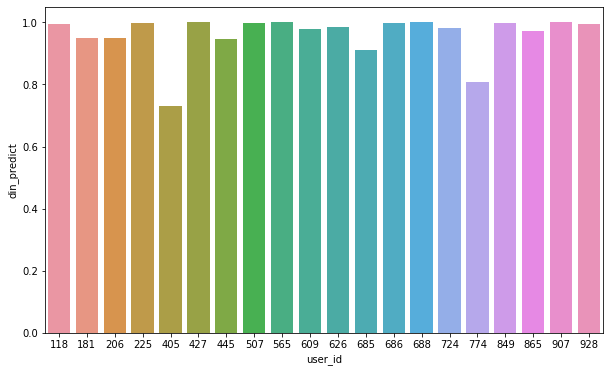

In [1028]:
plt.figure(figsize=(10,6))
sns.barplot(get_top_5_mean_recommendation_value("din_predict").index,get_top_5_mean_recommendation_value("din_predict"))

We could see that DIN recommend 5 movies all with a good recommendation values(probablity the model predict), and as for 405 who already saw most of the movies(736).We could see the top 5 movie mean value is a little bit smaller than others,which show how critical her was for movie, but the model give the mean values stil higher than 0.7. And for 685 which we know that she actually did not see any good movies(rating>3.5), DIN also good to remcommend 5 movies with strong recommendation value(larger than 0.9).

In [1029]:
# pd.DataFrame(din_recommendation["movie_id"].values.reshape(20,-1),index=din_recommendation["user_id"].unique().tolist())

Show the recommendation movie titles by DIN model

In [1030]:
def get_movie_title_data(din_recommendation):
    #get the movie title in correspongder user id
    movie_titles=[]
    for i in range(din_recommendation["movie_id"].shape[0]):
        movieid=din_recommendation["movie_id"].iloc[i]
        movie_titles.append(list(movie_features_data[movie_features_data["movie id"]==movieid]["movie title"])[0])

    index_din=din_recommendation["user_id"].unique().tolist()   
    movie_matrix=[]
    movie_row=[]
    for i in range(len(movie_titles)+1):
        if i % 5==0 and i!=0:
            movie_matrix.append(movie_row)
            movie_row=[]
            if i==len(movie_titles):
                break
        movie_row.append(movie_titles[i])
    din_recommend_movie=pd.DataFrame(movie_matrix,index=din_recommendation["user_id"].unique().tolist(),columns=["movie1","movie2","movie3","movie4","movie5"])
    return din_recommend_movie
get_movie_title_data(din_recommendation)

movie1  \
118                      Someone Else's America (1995)   
181                      Someone Else's America (1995)   
206  Entertaining Angels: The Dorothy Day Story (1996)   
225               Saint of Fort Washington, The (1993)   
405  Entertaining Angels: The Dorothy Day Story (1996)   
427               Saint of Fort Washington, The (1993)   
445               Saint of Fort Washington, The (1993)   
507                               Aiqing wansui (1994)   
565                                    Star Kid (1997)   
609                      Great Day in Harlem, A (1994)   
626  Entertaining Angels: The Dorothy Day Story (1996)   
685                                    Star Kid (1997)   
686         Marlene Dietrich: Shadow and Light (1996)    
688               Saint of Fort Washington, The (1993)   
724  Entertaining Angels: The Dorothy Day Story (1996)   
774                          Santa with Muscles (1996)   
849                                    Star Kid (1997)   
865  Entertaining Angels: The Dorothy Day Story (1996)   
907                      Someone Else's America (1995)   
928               Saint of Fort Washington, The (1993)   

                                                movie2  \
118               Saint of Fort Washington, The (1993)   
181  Entertaining Angels: The Dorothy Day Story (1996)   
206                          Santa with Muscles (1996)   
225                      Someone Else's America (1995)   
405                          Santa with Muscles (1996)   
427         Marlene Dietrich: Shadow and Light (1996)    
445         Marlene Dietrich: Shadow and Light (1996)    
507               Saint of Fort Washington, The (1993)   
565               Saint of Fort Washington, The (1993)   
609                          Santa with Muscles (1996)   
626               Saint of Fort Washington, The (1993)   
685  Entertaining Angels: The Dorothy Day Story (1996)   
686                      Someone Else's America (1995)   
688                                    Star Kid (1997)   
724                                    Star Kid (1997)   
774                      Great Day in Harlem, A (1994)   
849  Entertaining Angels: The Dorothy Day Story (1996)   
865         Marlene Dietrich: Shadow and Light (1996)    
907  Entertaining Angels: The Dorothy Day Story (1996)   
928                                    Star Kid (1997)   

                                                movie3  \
118                                    Star Kid (1997)   
181                                 Prefontaine (1997)   
206                      Great Day in Harlem, A (1994)   
225  Entertaining Angels: The Dorothy Day Story (1996)   
405                      Great Day in Harlem, A (1994)   
427                                    Star Kid (1997)   
445                      Someone Else's America (1995)   
507  Entertaining Angels: The Dorothy Day Story (1996)   
565         Marlene Dietrich: Shadow and Light (1996)    
609  Entertaining Angels: The Dorothy Day Story (1996)   
626                                    Star Kid (1997)   
685         Marlene Dietrich: Shadow and Light (1996)    
686  Entertaining Angels: The Dorothy Day Story (1996)   
688  Entertaining Angels: The Dorothy Day Story (1996)   
724                          Santa with Muscles (1996)   
774                                    Star Kid (1997)   
849                               Aiqing wansui (1994)   
865                      Great Day in Harlem, A (1994)   
907         Marlene Dietrich: Shadow and Light (1996)    
928  Entertaining Angels: The Dorothy Day Story (1996)   

                                                movie4  \
118  Entertaining Angels: The Dorothy Day Story (1996)   
181                          Santa with Muscles (1996)   
206         Marlene Dietrich: Shadow and Light (1996)    
225         Marlene Dietrich: Shadow and Light (1996)    
405                                 Prefontaine (1997)   
427  Entertaining Angels: The Dorothy Day S

### AFM model

In [804]:
# recommendation top 5 movies of every model
## AFM model
afm_recommendation=data_not_see.sort_values(by="afm_predict",ascending=False).groupby("user_id").head(5)
afm_recommendation=afm_recommendation.sort_values(by="user_id")
afm_recommendation.reset_index(drop=True,inplace=True)
afm_recommendation

user_id  movie_id  userHistoryRatingCount  userHistoryMeanRating  \
0       118        64               -0.319065               2.189532   
1       118       272               -0.319065               2.189532   
2       118      1637               -0.319065               2.189532   
3       118       275               -0.319065               2.189532   
4       118       484               -0.319065               2.189532   
..      ...       ...                     ...                    ...   
95      928       285               -0.722165               2.452965   
96      928       528               -0.722165               2.452965   
97      928        64               -0.722165               2.452965   
98      928        23               -0.722165               2.452965   
99      928       223               -0.722165               2.452965   

    userHistoryStdRating  userLikedTop5_movie_id_1  userLikedTop5_movie_id_2  \
0              -0.886154                       919                       164   
1              -0.886154                       919                       164   
2              -0.886154                       919                       164   
3              -0.886154                       919                       164   
4              -0.886154                       919                       164   
..                   ...                       ...                       ...   
95             -1.721822                       127                       276   
96             -1.721822                       127                       276   
97             -1.721822                       127                       276   
98             -1.721822                       127                       276   
99             -1.721822                       127                       276   

    userLikedTop5_movie_id_3  userLikedTop5_movie_id_4  \
0                        234                       320   
1                        234                       320   
2                        234                       320   
3                        234                       320   
4                        234                       320   
..                       ...                       ...   
95                         9                      1007   
96                         9                      1007   
97                         9                      1007   
98                         9                      1007   
99                         9                      1007   

    userLikedTop5_movie_id_5  ...  movieGenre3  movieGenre4 movieGenre5  \
0                        288  ...          0.0          0.0         0.0   
1                        288  ...          0.0          0.0         0.0   
2                        288  ...          0.0          0.0         0.0   
3                        288  ...          0.0          0.0         0.0   
4                        288  ...          0.0          0.0         0.0   
..                       ...  ...          ...          ...         ...   
95                       246  ...          0.0          0.0         0.0   
96                       246  ...          0.0          0.0         0.0   
97                       246  ...          0.0          0.0         0.0   
98                       246  ...          0.0          0.0         0.0   
99                       246  ...          0.0          0.0         0.0   

   movieGenre6 base_predict dc_predict ncf_predict  wad_predict  afm_predict  \
0          0.0     0.999980   0.989430    0.998452     0.893358     0.966417   
1          0.0     0.999968   0.984048    0.997961     0.896823     0.947912   
2          0.0     0.823787   0.854631    0.931887     0.611305     0.928588   
3          0.0     0.999286   0.971548    0.978919     0.921118     0.929130   
4          0.0     0.999716   0.974223    0.991964     0.906964     0.931991   
..         ...          ...        ...         ...          ...          ...   
95         0.0     0

* **mean probability of these 5 movies predicted by models**

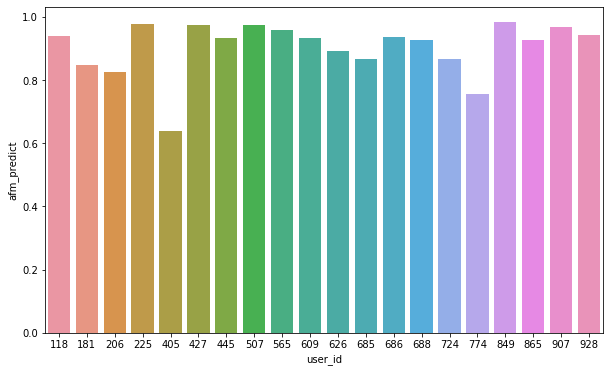

In [805]:
plt.figure(figsize=(10,6))
sns.barplot(get_top_5_mean_recommendation_value("afm_predict").index,get_top_5_mean_recommendation_value("afm_predict"))

Here we could see that the mean value of top 5 movies recommended by AFM is much lower than DIN, and the movie value of user 405 is only around 0.6,other performance are also not very high, then let's see the recommendation of AFM

In [807]:
#get the movie title in correspongder user id
get_movie_title_data(afm_recommendation)

movie1  \
118                Shawshank Redemption, The (1994)   
181                                Star Wars (1977)   
206                                Star Wars (1977)   
225          One Flew Over the Cuckoo's Nest (1975)   
405                       As Good As It Gets (1997)   
427           Day the Earth Stood Still, The (1951)   
445                             Sunset Blvd. (1950)   
507  Midnight in the Garden of Good and Evil (1997)   
565                                     Bent (1997)   
609     My Life as a Dog (Mitt liv som hund) (1985)   
626                                Boot, Das (1981)   
685                Shawshank Redemption, The (1994)   
686                                  Contact (1997)   
688                Shawshank Redemption, The (1994)   
724                           Close Shave, A (1995)   
774                                    Fresh (1994)   
849                        Big Lebowski, The (1998)   
865                           Secrets & Lies (1996)   
907                         Grand Day Out, A (1992)   
928                           Secrets & Lies (1996)   

                                                movie2  \
118                           Good Will Hunting (1997)   
181                                 Rear Window (1954)   
206             One Flew Over the Cuckoo's Nest (1975)   
225                              Secrets & Lies (1996)   
405                              Close Shave, A (1995)   
427                              Primary Colors (1998)   
445                   Silence of the Lambs, The (1991)   
507                           L.A. Confidential (1997)   
565                              Apocalypse Now (1979)   
609                                   Lone Star (1996)   
626                   Silence of the Lambs, The (1991)   
685                         Usual Suspects, The (1995)   
686                              Twelve Monkeys (1995)   
688                   Silence of the Lambs, The (1991)   
724                   Shawshank Redemption, The (1994)   
774                              Close Shave, A (1995)   
849                 Truth or Consequences, N.M. (1997)   
865                              Primary Colors (1998)   
907  Horseman on the Roof, The (Hussard sur le toit...   
928                         Killing Fields, The (1984)   

                               movie3  \
118                 Girls Town (1996)   
181  Silence of the Lambs, The (1991)   
206         Lawrence of Arabia (1962)   
225             Flesh and Bone (1993)   
405      Cat on a Hot Tin Roof (1958)   
427           Jean de Florette (1986)   
445                  Boot, Das (1981)   
507                 Set It Off (1996)   
565  Shawshank Redemption, The (1994)   
609  Shawshank Redemption, The (1994)   
626  Shawshank Redemption, The (1994)   
685             Close Shave, A (1995)   
686                    Stalker (1979)   
688             Secrets & Lies (1996)   
724                    Titanic (1997)   
774                    Titanic (1997)   
849                    Carpool (1996)   
865           Schindler's List (1993)   
907                    Amadeus (1984)   
928  Shawshank Redemption, The (1994)   

                                                movie4  \
118                       Sense and Sensibility (1995)   
181                   Shawshank Redemption, The (1994)   
206                   Silence of the Lambs, The (1991)   
225                               Kaspar Hauser (1993)   
405                          African Queen, The (1951)   
427                   Shawshank Redemption, The (1994)   
445                                  GoodFellas (1990)   
507                 Truth or Consequences, N.M. (1997)   
565               Bridge on the River Kwai, The (1957)   
609                                 Rear Window (1954)   
626                                 Taxi Driver (1976)   
685                            Schindler's List (1993)   
686  Until the End of the World (Bis ans Ende der W...

### Wide & Deep Model

In [1031]:
## WAD model
wad_recommendation=data_not_see.sort_values(by="wad_predict",ascending=False).groupby("user_id").head(5)
wad_recommendation=wad_recommendation.sort_values(by="user_id")
wad_recommendation.reset_index(drop=True,inplace=True)

* **mean probability of these 5 movies predicted by models**

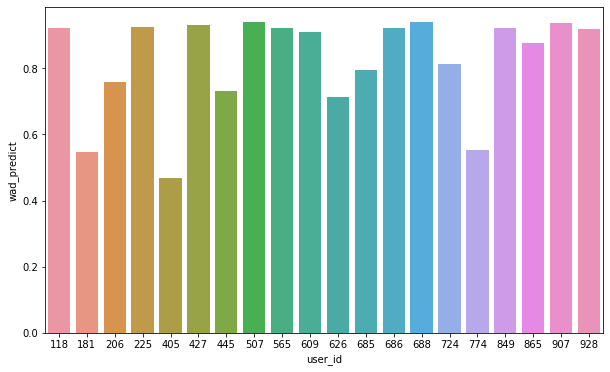

In [1032]:
plt.figure(figsize=(10,6))
sns.barplot(get_top_5_mean_recommendation_value("wad_predict").index,get_top_5_mean_recommendation_value("wad_predict"))

The second most good model is Wide & deep, but in our slef-made data set, it fails to find a good movie for user 405, and the the value of movies in 181 and 774 is also not very good.And other probability is not very high too,which indicates that wide & deep may not stable and will change a lot in different dataset.

In [1033]:
#get the movie title in correspongder user id
get_movie_title_data(wad_recommendation)

movie1  \
118        Saint of Fort Washington, The (1993)   
181        Saint of Fort Washington, The (1993)   
206                          Prefontaine (1997)   
225               Someone Else's America (1995)   
405               Great Day in Harlem, A (1994)   
427  Marlene Dietrich: Shadow and Light (1996)    
445                          Prefontaine (1997)   
507               Great Day in Harlem, A (1994)   
565                         12 Angry Men (1957)   
609                        Aiqing wansui (1994)   
626                        Aiqing wansui (1994)   
685               Great Day in Harlem, A (1994)   
686                             Star Kid (1997)   
688              They Made Me a Criminal (1939)   
724               Great Day in Harlem, A (1994)   
774                        Aiqing wansui (1994)   
849                          Prefontaine (1997)   
865  Marlene Dietrich: Shadow and Light (1996)    
907                          Prefontaine (1997)   
928              They Made Me a Criminal (1939)   

                                                movie2  \
118         Marlene Dietrich: Shadow and Light (1996)    
181  Entertaining Angels: The Dorothy Day Story (1996)   
206                      Great Day in Harlem, A (1994)   
225                            Schindler's List (1993)   
405                      Someone Else's America (1995)   
427                                    Star Kid (1997)   
445  Entertaining Angels: The Dorothy Day Story (1996)   
507  Entertaining Angels: The Dorothy Day Story (1996)   
565         Marlene Dietrich: Shadow and Light (1996)    
609               Saint of Fort Washington, The (1993)   
626                                 Prefontaine (1997)   
685         Marlene Dietrich: Shadow and Light (1996)    
686         Marlene Dietrich: Shadow and Light (1996)    
688                                 Prefontaine (1997)   
724  Entertaining Angels: The Dorothy Day Story (1996)   
774               Saint of Fort Washington, The (1993)   
849                     They Made Me a Criminal (1939)   
865               Saint of Fort Washington, The (1993)   
907                              Third Man, The (1949)   
928                                    Star Kid (1997)   

                                                movie3  \
118                               Aiqing wansui (1994)   
181                                 Prefontaine (1997)   
206                     They Made Me a Criminal (1939)   
225                               Aiqing wansui (1994)   
405                               Aiqing wansui (1994)   
427                      Great Day in Harlem, A (1994)   
445         Marlene Dietrich: Shadow and Light (1996)    
507                                 Prefontaine (1997)   
565                     They Made Me a Criminal (1939)   
609                      Great Day in Harlem, A (1994)   
626  Entertaining Angels: The Dorothy Day Story (1996)   
685                                 Prefontaine (1997)   
686                          Santa with Muscles (1996)   
688                              Godfather, The (1972)   
724                     They Made Me a Criminal (1939)   
774                                 Prefontaine (1997)   
849                          Santa with Muscles (1996)   
865  Entertaining Angels: The Dorothy Day Story (1996)   
907               Saint of Fort Washington, The (1993)   
928               Saint of Fort Washington, The (1993)   

                                                movie4  \
118                      Great Day in Harlem, A (1994)   
181         Marlene Dietrich: Shadow and Light (1996)    
206               Saint of Fort Washington, The (1993)   
225                     They Made Me a Criminal (1939)   
405                     They Made Me a Criminal (1939)   
427               Saint of Fort Washington, The (1993)   
445                     They Made Me a Criminal (1939)   
507         Marlene Dietrich: Shadow and Light (1996)    
565      

### Nurual CF model

* **mean probability of these 5 movies predicted by models**

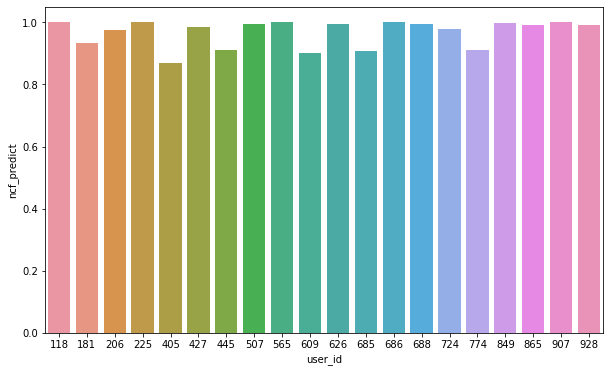

In [1034]:
# Nerual CF
## Nurual CF model
ncf_recommendation=data_not_see.sort_values(by="ncf_predict",ascending=False).groupby("user_id").head(5)
ncf_recommendation=ncf_recommendation.sort_values(by="user_id")
ncf_recommendation.reset_index(drop=True,inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(get_top_5_mean_recommendation_value("ncf_predict").index,get_top_5_mean_recommendation_value("ncf_predict"))

In [1035]:
#get the movie title in correspongder user id
get_movie_title_data(wad_recommendation)

movie1  \
118        Saint of Fort Washington, The (1993)   
181        Saint of Fort Washington, The (1993)   
206                          Prefontaine (1997)   
225               Someone Else's America (1995)   
405               Great Day in Harlem, A (1994)   
427  Marlene Dietrich: Shadow and Light (1996)    
445                          Prefontaine (1997)   
507               Great Day in Harlem, A (1994)   
565                         12 Angry Men (1957)   
609                        Aiqing wansui (1994)   
626                        Aiqing wansui (1994)   
685               Great Day in Harlem, A (1994)   
686                             Star Kid (1997)   
688              They Made Me a Criminal (1939)   
724               Great Day in Harlem, A (1994)   
774                        Aiqing wansui (1994)   
849                          Prefontaine (1997)   
865  Marlene Dietrich: Shadow and Light (1996)    
907                          Prefontaine (1997)   
928              They Made Me a Criminal (1939)   

                                                movie2  \
118         Marlene Dietrich: Shadow and Light (1996)    
181  Entertaining Angels: The Dorothy Day Story (1996)   
206                      Great Day in Harlem, A (1994)   
225                            Schindler's List (1993)   
405                      Someone Else's America (1995)   
427                                    Star Kid (1997)   
445  Entertaining Angels: The Dorothy Day Story (1996)   
507  Entertaining Angels: The Dorothy Day Story (1996)   
565         Marlene Dietrich: Shadow and Light (1996)    
609               Saint of Fort Washington, The (1993)   
626                                 Prefontaine (1997)   
685         Marlene Dietrich: Shadow and Light (1996)    
686         Marlene Dietrich: Shadow and Light (1996)    
688                                 Prefontaine (1997)   
724  Entertaining Angels: The Dorothy Day Story (1996)   
774               Saint of Fort Washington, The (1993)   
849                     They Made Me a Criminal (1939)   
865               Saint of Fort Washington, The (1993)   
907                              Third Man, The (1949)   
928                                    Star Kid (1997)   

                                                movie3  \
118                               Aiqing wansui (1994)   
181                                 Prefontaine (1997)   
206                     They Made Me a Criminal (1939)   
225                               Aiqing wansui (1994)   
405                               Aiqing wansui (1994)   
427                      Great Day in Harlem, A (1994)   
445         Marlene Dietrich: Shadow and Light (1996)    
507                                 Prefontaine (1997)   
565                     They Made Me a Criminal (1939)   
609                      Great Day in Harlem, A (1994)   
626  Entertaining Angels: The Dorothy Day Story (1996)   
685                                 Prefontaine (1997)   
686                          Santa with Muscles (1996)   
688                              Godfather, The (1972)   
724                     They Made Me a Criminal (1939)   
774                                 Prefontaine (1997)   
849                          Santa with Muscles (1996)   
865  Entertaining Angels: The Dorothy Day Story (1996)   
907               Saint of Fort Washington, The (1993)   
928               Saint of Fort Washington, The (1993)   

                                                movie4  \
118                      Great Day in Harlem, A (1994)   
181         Marlene Dietrich: Shadow and Light (1996)    
206               Saint of Fort Washington, The (1993)   
225                     They Made Me a Criminal (1939)   
405                     They Made Me a Criminal (1939)   
427               Saint of Fort Washington, The (1993)   
445                     They Made Me a Criminal (1939)   
507         Marlene Dietrich: Shadow and Light (1996)    
565      

Nerual CF model in our self_made model can redommend movies well, and it is good for nearly every movies, this is beacuse Nerual CF only consider the movie Id and User id , so it always will find some relationship since there are only two inputs, so it performs good did not mean the result is correct, the two inputs may be eliminate many informations, so the result is not convinced compared to other models

### Deep_crossing

* **mean probability of these 5 movies predicted by models**

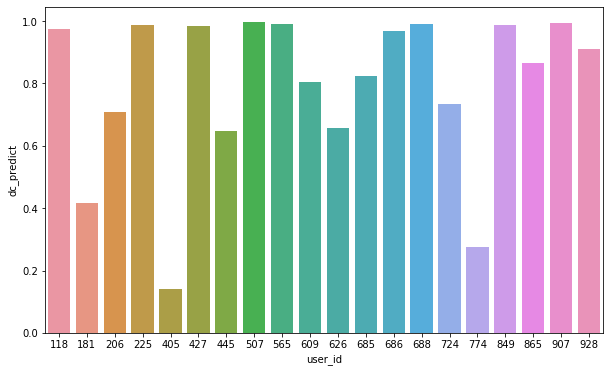

In [1036]:
# Deep_crossing
## deep_crossing model
dc_recommendation=data_not_see.sort_values(by="dc_predict",ascending=False).groupby("user_id").head(5)
dc_recommendation=dc_recommendation.sort_values(by="user_id")
dc_recommendation.reset_index(drop=True,inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(get_top_5_mean_recommendation_value("dc_predict").index,get_top_5_mean_recommendation_value("dc_predict"))

Deep&crossing is just like wide and deep model, it fails to recomment movies for 181,405,774,and other performance are also not very good compared to DIN

### Base_embedding _MLP model

* **mean probability of these 5 movies predicted by models**

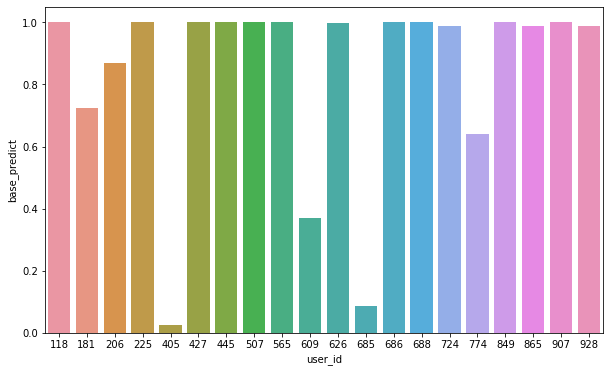

In [1037]:
# Base_MLP
## Base_MLP model
bs_recommendation=data_not_see.sort_values(by="base_predict",ascending=False).groupby("user_id").head(5)
bs_recommendation=bs_recommendation.sort_values(by="user_id")
bs_recommendation.reset_index(drop=True,inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(get_top_5_mean_recommendation_value("base_predict").index,get_top_5_mean_recommendation_value("base_predict"))

Base model also failed to recommend film to user 405,609,685, movies recommend to 774 is also not very high, but other recommedation values seems good,other values are more close to 1

# Summary

* we first explore our three dataset including rating, user-files and movie-files,**we use NaN value imputation, normalizaiton to get our data**
* 
* the first rating files **only contains 4 columns**: user id ,movie id, rating and timestamp, so we diged the **movie features** like movie aevrage rating, movie standard deviation rating ,released year and etc. We also diged the **user features** based on time, because we don't want to add future behaviours before the timestamp, then we add user average rating, user most liked top 5 movie ids and genres and etc. So we extend our rating files from **only 4 columns to nearly 40 columns**, which contains a lot of information about the dataset.
* 
* after we finished our final dataset, data visualization was carried out, and we first focuesed on the movies,it shows that **"Star War"** is the most popular movie and many people set a rate on it, while **"drama" is the most popular movie genre** that dicrectors like at that time, and most of the movies are shot **after 1992**. Then we focused on the user behaviours, is shows that most of the people are nice and the 4 is most rated by users. **User 405** which is a young lady is the champion to see the most movie, which is 736 out of 1682. However, such experience made her more critical that her mean rating value to all the movie she saw is **only near 1.8**. Further more, we could find out user 849, and user 688 are the most nice persons out of the 943 users, their mean rating is extremely high, they know waht they want to see and watch the good movies they liked. user 181 and user405, are the most critical two persons.
* 
* We implement 6 different models for recommendation systems, they are base embedding models, Deep&crossing model, Nerual Cf model, Wide&Deep model, AFM model and DIN model. some of the model are fine-tuned by changing the hyperparamters. And the result shows that the Rank of model is **DIN>Wide&Deep>Nerual_CF>Deep&Crossing>Base_Embedding_MLP>AFM**. The ROC curve also prove this rank. AUC of DIN is largest and near 78% while the least one which is AFM is only 73.1%, which shows that DIN is very good model in capture the information between users and movies. 
* 
* After all the models are established, we **self-made a dataset** to recommend some user about the movies that she or he did not see before, we choose the top 10 nice persons and the top 10 critical persons to recomend there movies.The dataset is combined by the **user newest behaviours** and movie features. After prediction, the top 5 recommended movies are ouput by each model. It shows that not all the models can successfully find movies for user.Wide& Deep fails to recommend **user 405**,a little failed of **181,774**, Deep&Crossing failed to recommend movie for user **181,405,774**, Base model failed to recommend for user  **405,609,685**. If we check the user id carefully, **all these user ids are in the top 10 critical persons**, their accent for movies are really hard for these models to predict.
* 
* However, three other models **DIN,AFM,nerual CF** is good to recommend all the movies to users, and here it seems that Nerual CF are better than DIN and AMF.However, **Nerual CF only need user id and movie id** as inputs, so actually it can not be very correct to recommend users and there are many information maybe lost, so the recommendation result may be not convinced as much as other two models. Then the performance of AFM is least in test set,and it also only use the categorical features,there are also many informantion lost. In this case, AFM also is not convinced as much as DIN.
* 
* In fact, **We could realize that in all the models with all features as inputes (base_model,Deep_crossing,wide & deep,DIN), only DIN successfully recommend** all the critical users about the movies, it indicates that models are sometimes can not deal with many information about the user and movies and can not find the inner regulation, here **only DIN worked good and seems find the regulation**. So, **DIN is the most convinced model**, since first it contains every information we extracted, second the performance is also the best, third it can recommend critical individuals movies.